In [1]:
import tensorflow as tf
import sys
sys.path.append("..")
import tools
import matplotlib.pyplot as plt
from astroML.crossmatch import crossmatch_angular
import numpy as np
from lsst.daf.butler import Butler
import pandas as pd
import multiprocessing
import os
%load_ext autoreload
%autoreload 2

2024-04-13 01:33:57.113678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 01:33:57.113730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 01:33:57.114665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 01:33:57.121255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 01:33:59.864794: W tensorflow/compiler/tf2

In [79]:
def create_NN_prediction (dataset_path, model_path="../DATA/Trained_model"):
    dataset_test = tf.data.TFRecordDataset([dataset_path])
    tfrecord_shape = tools.model.get_shape_of_quadratic_image_tfrecord(dataset_test)
    dataset_test = dataset_test.map(tools.model.parse_function(img_shape=tfrecord_shape, test=True))
    dataset_test = dataset_test.batch(128)
    model = tf.keras.models.load_model(model_path , custom_objects={'F1_Score':tools.model.F1_Score})
    predictions = model.predict(dataset_test)
    p = predictions>0.5
    predictions = tools.data.npy_merge(predictions>0.5, (4176, 2048))
    return predictions

def one_hit (p, injected_calexp, catalog_row, i):
    origin = injected_calexp.getWcs().skyToPixelArray(np.array([catalog_row["ra"]]), np.array([catalog_row["dec"]]),
                                                 degrees=True)
    angle = catalog_row["beta"]
    length = catalog_row["trail_length"]
    mask = np.zeros(injected_calexp.image.array.shape)
    mask = tools.data.draw_one_line(mask, origin, angle, length, line_thickness=6)
    return {'injection_id': catalog_row['injection_id'], 'ra' : catalog_row['ra'], 'dec' : catalog_row['dec'],
                    'trail_length' : catalog_row['trail_length'],'beta' : catalog_row['beta'],
                    'mag' : catalog_row['mag'], 'n' : i, 'x' : round(origin[0][0]), 'y' : round(origin[1][0]), 
                    'detected' : int(((mask==1) & (p==1)).sum()>0)}
    
def compare_NN_predictions (p, repo, output_coll, val_index = None, batch_size=None):
    butler = Butler(repo)
    catalog_ref = list(butler.registry.queryDatasets("injected_postISRCCD_catalog",
                                                     collections=output_coll,
                                                     instrument='HSC'))
    ref = list(butler.registry.queryDatasets("injected_calexp",
                                             collections=output_coll,
                                            instrument='HSC'))
    parameters = []
    if batch_size is None:
        batch_size = os.cpu_count() - 1
    if val_index is None:
        val_index = list (range(len(catalog_ref)))
    for i, index in enumerate(val_index):
        injected_calexp = butler.get("injected_calexp",
                                     dataId=ref[index].dataId,
                                     collections=output_coll)
        catalog = butler.get("injected_postISRCCD_catalog",
                             dataId=catalog_ref[index].dataId,
                             collections=output_coll)
        catalog = catalog[catalog["injection_flag"]==0]
        parameters += [(p[i], injected_calexp, k, i) for k in catalog]
    pool = multiprocessing.Pool(batch_size)
    list_cat = pool.starmap(one_hit, parameters)
    pool.close()
    pool.join()
    return pd.DataFrame(list_cat)

def NN_comparation_histogram_data (model_path, tf_dataset_path, val_index_path, repo, output_coll, 
                                   column_name="trail_length"):
    print ("NN predicting")
    predictions = create_NN_prediction (tf_dataset_path, model_path)
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
        val_index.sort()
    print ("Comparing to true catalog")
    cat = compare_NN_predictions (predictions, repo, output_coll, val_index = val_index)
    return cat[cat["detected"]==1][column_name].to_numpy(), cat[column_name].to_numpy()

In [80]:
def one_LSST_stack_comparison (butler, output_coll, injection_catalog_id, source_catalog_id, calexp_id, 
                               column_name):
        injection_catalog= butler.get("injected_postISRCCD_catalog", 
                                      dataId=injection_catalog_id.dataId, 
                                      collections=output_coll,)
        original_source_catalog= butler.get("src", 
                                   dataId=source_catalog_id.dataId, 
                                   collections=output_coll,)
        source_catalog= butler.get("injected_src", 
                                   dataId=source_catalog_id.dataId, 
                                   collections=output_coll,)
        calexp = butler.get("injected_calexp", 
                            dataId=calexp_id.dataId, 
                            collections=output_coll)
        
        sc = source_catalog.asAstropy().to_pandas()
        osc = original_source_catalog.asAstropy().to_pandas()
        dist, ind = crossmatch_angular(sc[['coord_ra', 'coord_dec']].values, 
                                           osc[['coord_ra', 'coord_dec']].values, 0.04 / 3600)
        source_origin = calexp.getWcs().skyToPixelArray(np.array([source_catalog["coord_ra"][np.isinf(dist)]]), 
                                                        np.array([source_catalog["coord_dec"][np.isinf(dist)]]),
                                                        degrees=False)
        injected_origin = calexp.getWcs().skyToPixelArray(np.array([injection_catalog["ra"]]), 
                                                          np.array([injection_catalog["dec"]]),
                                                          degrees=True)
        angle = injection_catalog["beta"]
        length = injection_catalog["trail_length"]
        mask_source = np.zeros(calexp.image.array.shape)
        mask_source [source_origin[1].astype(int),source_origin[0].astype(int)] = 1
        matched_values = np.array([])
        for j in range (len (angle)):
            mask_inject = tools.data.draw_one_line(np.zeros(calexp.image.array.shape), 
                                                    (injected_origin[0][j], injected_origin[1][j]),
                                                    angle[j], length[j])
            if (mask_inject*mask_source).sum()>0:
                matched_values = np.append(matched_values, injection_catalog[column_name][j])
        return matched_values
            
    

def LSST_stack_comparation_histogram_data(repo, output_coll, val_index_path, 
                                          column_name="trail_length", batch_size=None):
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
        val_index.sort()
    butler = Butler(repo)
    injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=output_coll, instrument='HSC'))
    source_catalog_ids = list(butler.registry.queryDatasets("injected_src", collections=output_coll, instrument='HSC'))
    calexp_ids = list(butler.registry.queryDatasets("injected_calexp", collections=output_coll, instrument='HSC'))
    parameters = [(butler, output_coll, 
                    injection_catalog_ids[i], source_catalog_ids[i], 
                    calexp_ids[i], column_name) for i in val_index]
    if batch_size is None:
        batch_size = os.cpu_count() - 1
    pool = multiprocessing.Pool(batch_size)
    list_cat = pool.starmap(one_LSST_stack_comparison, parameters)
    pool.close()
    pool.join()
    return np.concatenate(list_cat)

In [81]:
def create_xyp (tf_dataset_path, model_path):
    predictions = create_NN_prediction (tf_dataset_path, model_path)
    dataset_test = tf.data.TFRecordDataset([tf_dataset_path])
    tfrecord_shape = tools.model.get_shape_of_quadratic_image_tfrecord(dataset_test)
    dataset_test = dataset_test.map(tools.model.parse_function(img_shape=tfrecord_shape, test=False))
    x = np.empty([30624,128,128,1])
    y = np.empty([30624,128,128,1])
    counter=0
    for i in dataset_test:
        next_counter = counter+1
        x[counter] = i[0]
        y[counter] = i[1]
        counter = next_counter
    #dataset_test = tools.data.tfdataset_merge (dataset_test, (4176, 2048))
    #truths = tools.data.dataset_to_numpy(dataset_test)
    calexp = tools.data.npy_merge(x, (4176, 2048))
    truths = tools.data.npy_merge(y, (4176, 2048))
    return calexp, truths, predictions

In [10]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test1.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_02"
model = "../DATA/Trained_model1"
x,y,p = create_xyp (tfrecord_path, model)

240/240 [==============================] - 13s 54ms/step


2024-04-13 02:02:14.914442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11388212309810330669


In [83]:
tfrecord_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/test2.tfrecord"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
collection = "u/kmrakovc/single_frame_injection_03"
model = "../DATA/Trained_model1"
NN_detected_asteroids_0, true_asteroids_0 = NN_comparation_histogram_data (model,
                                                                           tfrecord_path,
                                                                           val_index_path,
                                                                           repo_path,
                                                                           collection,
                                                                          column_name=["n", "x", "y", "detected", "trail_length", "mag"])
x,y,p = create_xyp (tfrecord_path, model)
#LSST_stack_detected_asteroids_0= LSST_stack_comparation_histogram_data(repo_path, 
#                                                                       collection, 
#                                                                       val_index_path,
#                                                                      column_name="mag")

NN predicting
240/240 [==============================] - 13s 54ms/step


2024-04-13 06:03:20.372666: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11388212309810330669


Comparing to true catalog
240/240 [==============================] - 13s 54ms/step


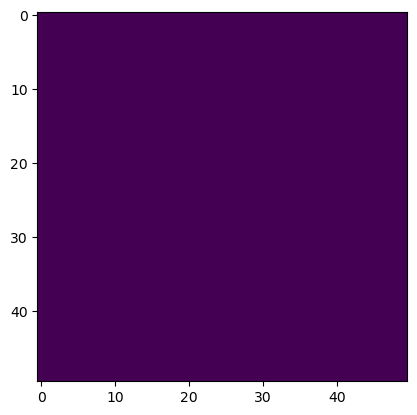

In [75]:
plt.imshow(y[0, 2748-25:2748+25, 1700-25:1700+25])

In [76]:
x[0].shape

(4176, 2048)

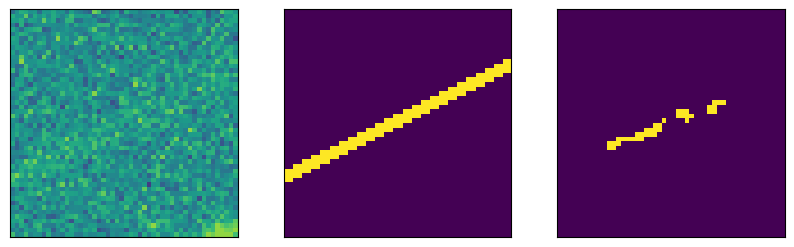

N: 0.0  x: 161.0  y: 1808.0  mag: 23.844356390148842  trail: 68.0


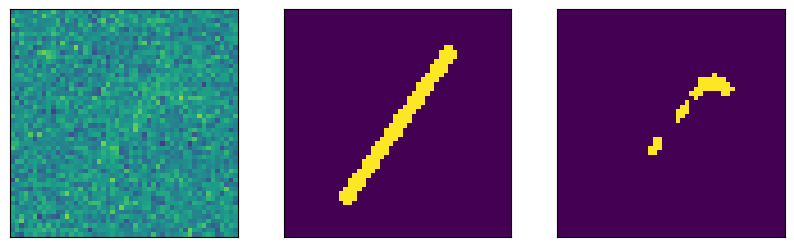

N: 0.0  x: 2962.0  y: 489.0  mag: 23.895281317082087  trail: 39.0


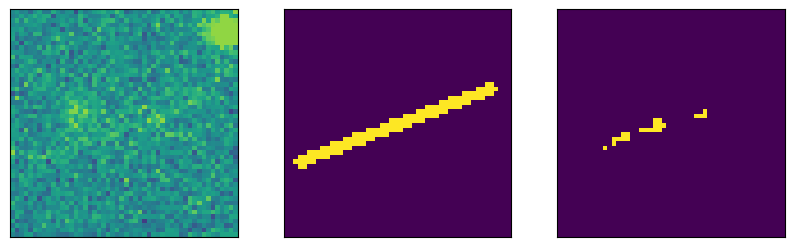

N: 0.0  x: 3567.0  y: 217.0  mag: 23.809692094069582  trail: 45.0


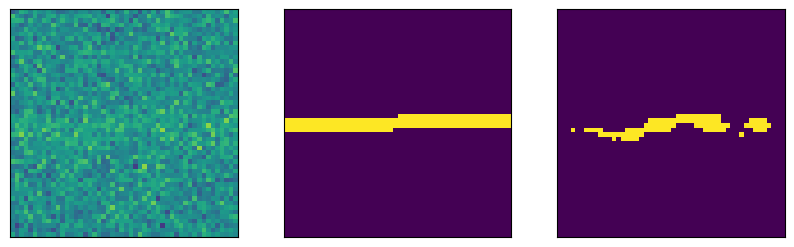

N: 0.0  x: 3176.0  y: 576.0  mag: 23.775629830282387  trail: 56.0


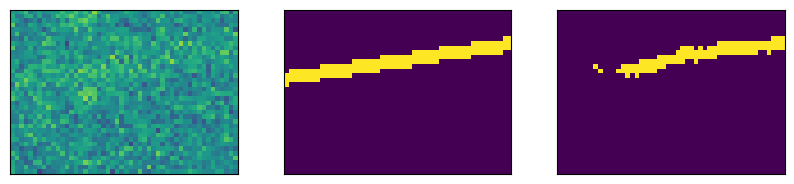

N: 0.0  x: 11.0  y: 447.0  mag: 23.684203263926836  trail: 67.0


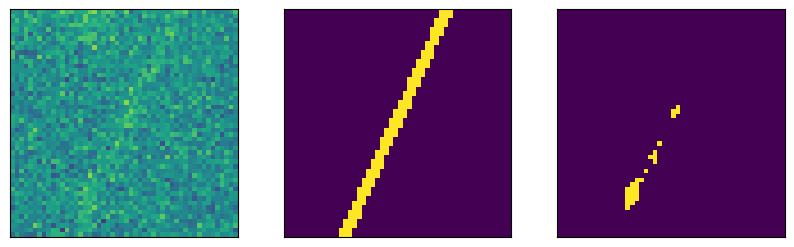

N: 0.0  x: 3092.0  y: 892.0  mag: 23.77276105573  trail: 62.0


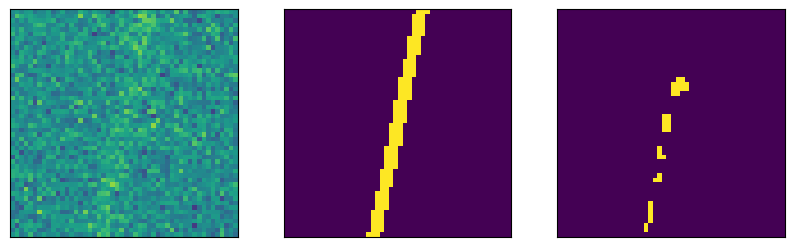

N: 0.0  x: 1548.0  y: 988.0  mag: 23.714526626716864  trail: 64.0


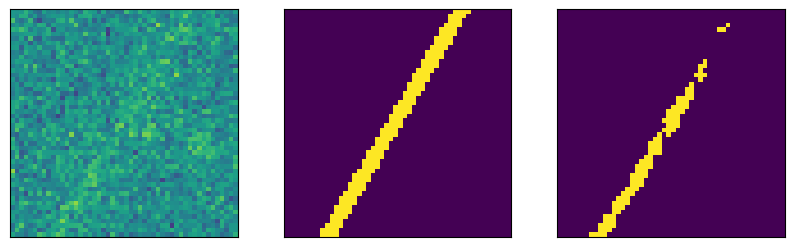

N: 0.0  x: 1839.0  y: 434.0  mag: 23.729296037389865  trail: 63.0


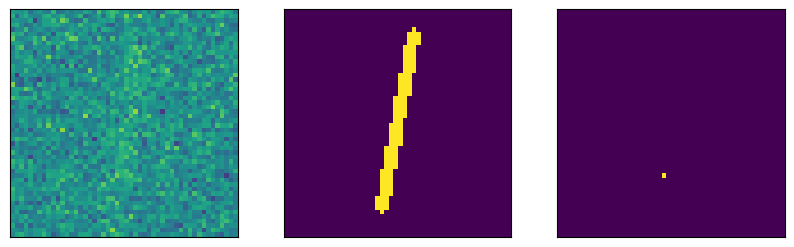

N: 0.0  x: 1572.0  y: 1949.0  mag: 23.573824731940157  trail: 38.0


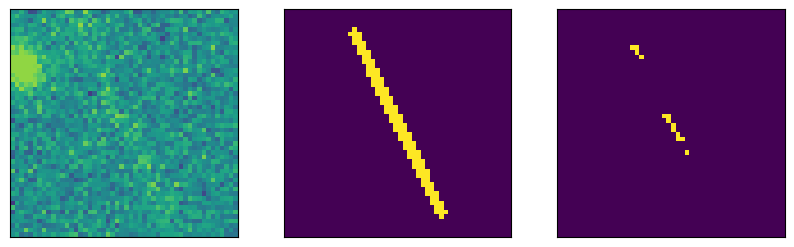

N: 0.0  x: 3063.0  y: 346.0  mag: 23.570460945680413  trail: 43.0


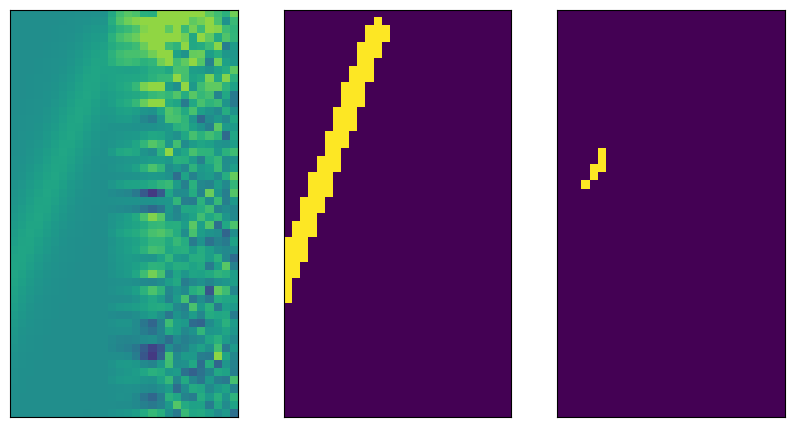

N: 1.0  x: 2542.0  y: 3.0  mag: 23.57796176539382  trail: 49.0


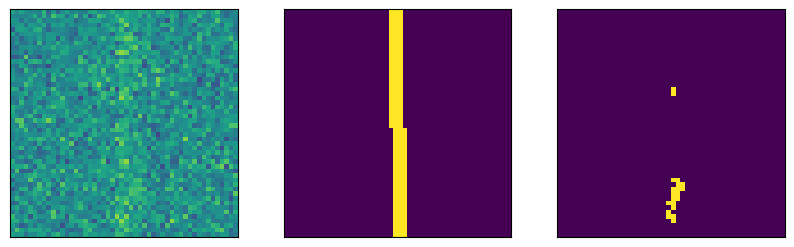

N: 1.0  x: 3304.0  y: 1993.0  mag: 23.814776949703802  trail: 72.0


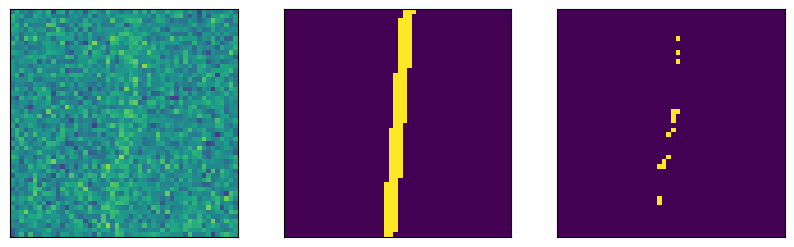

N: 1.0  x: 4045.0  y: 1116.0  mag: 23.777153860679356  trail: 60.0


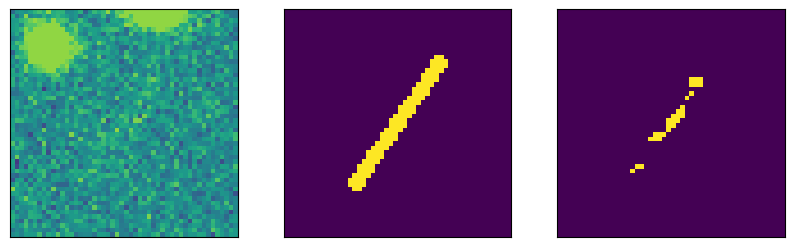

N: 1.0  x: 3622.0  y: 1934.0  mag: 23.67742301284412  trail: 33.0


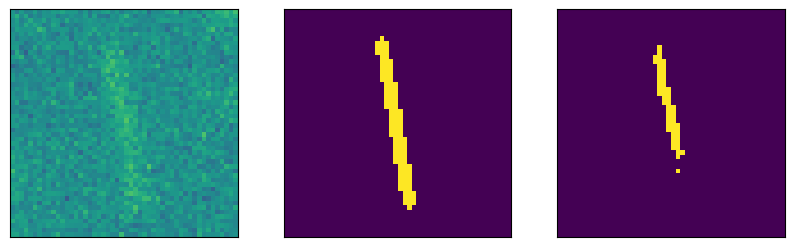

N: 2.0  x: 1471.0  y: 1274.0  mag: 23.642254405023717  trail: 35.0


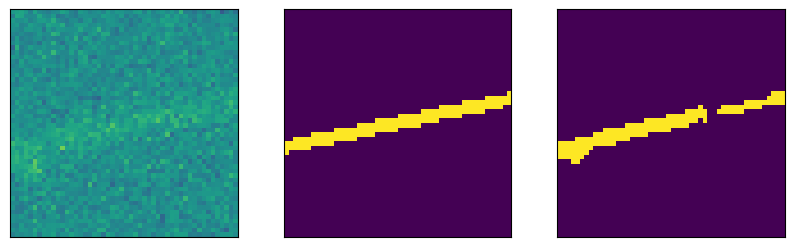

N: 2.0  x: 3991.0  y: 503.0  mag: 23.91756356045118  trail: 63.0


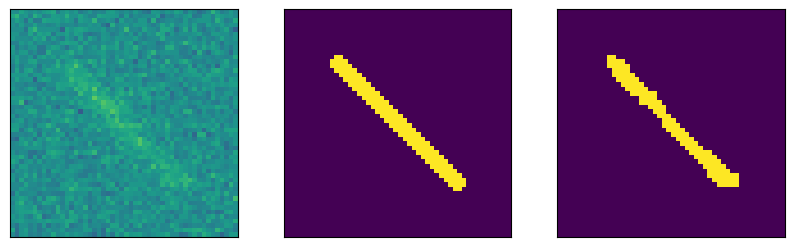

N: 2.0  x: 879.0  y: 1490.0  mag: 23.703213865346278  trail: 39.0


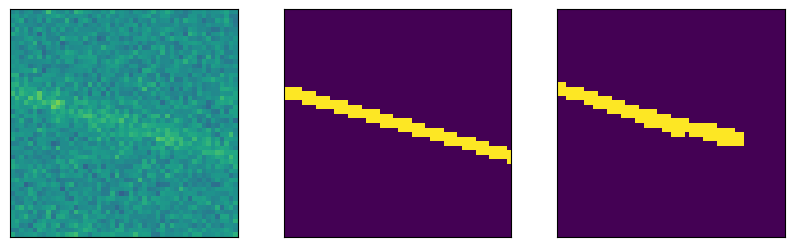

N: 2.0  x: 2222.0  y: 111.0  mag: 23.735698281739666  trail: 68.0


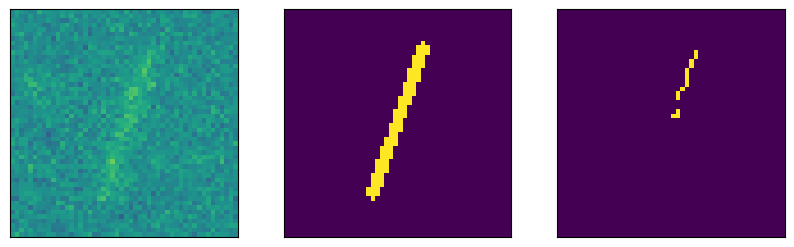

N: 2.0  x: 1532.0  y: 152.0  mag: 23.624582400811985  trail: 34.0


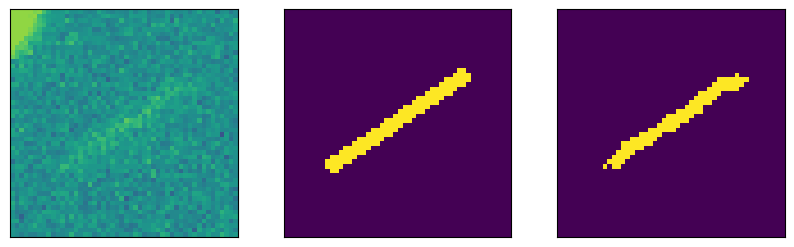

N: 2.0  x: 3278.0  y: 1886.0  mag: 23.789488183630237  trail: 35.0


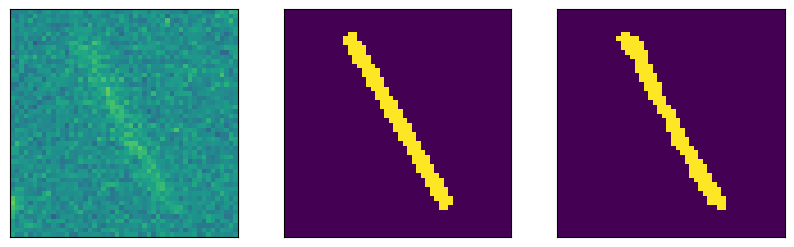

N: 2.0  x: 474.0  y: 305.0  mag: 23.690608311507706  trail: 42.0


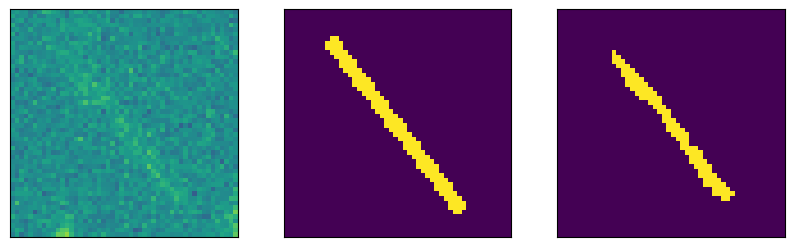

N: 2.0  x: 1041.0  y: 1716.0  mag: 23.90662149337782  trail: 45.0


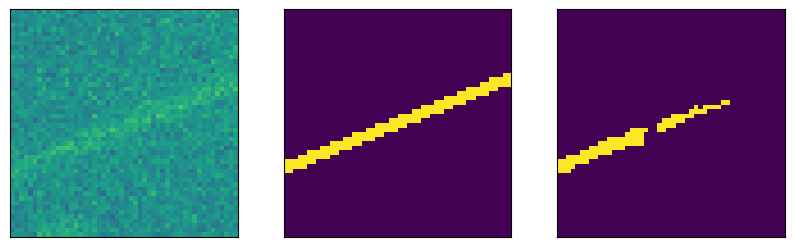

N: 2.0  x: 601.0  y: 261.0  mag: 23.8530457512634  trail: 72.0


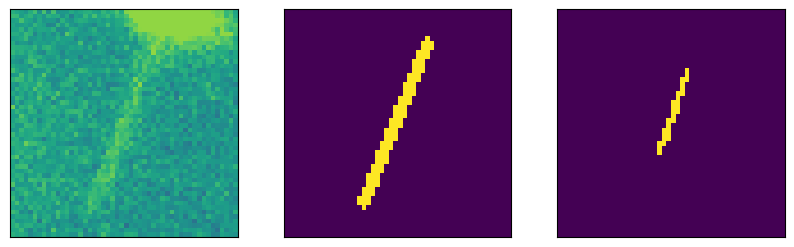

N: 2.0  x: 3382.0  y: 1116.0  mag: 23.584934597409905  trail: 38.0


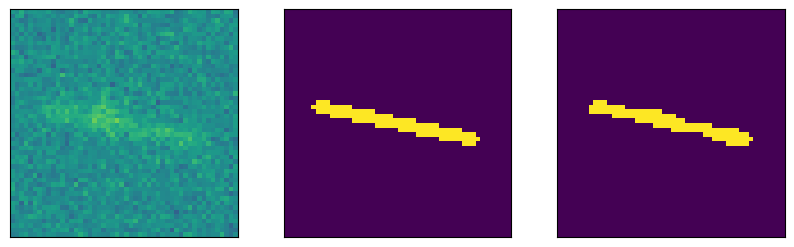

N: 2.0  x: 989.0  y: 1981.0  mag: 23.659250886888056  trail: 35.0


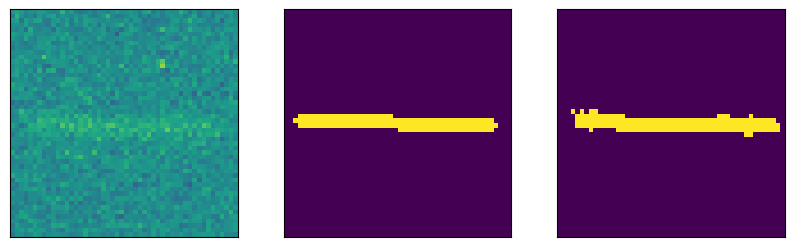

N: 2.0  x: 3743.0  y: 721.0  mag: 23.776763704732314  trail: 42.0


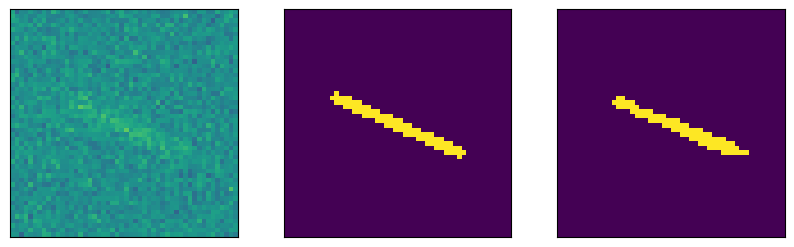

N: 2.0  x: 316.0  y: 145.0  mag: 23.803639165210807  trail: 30.0


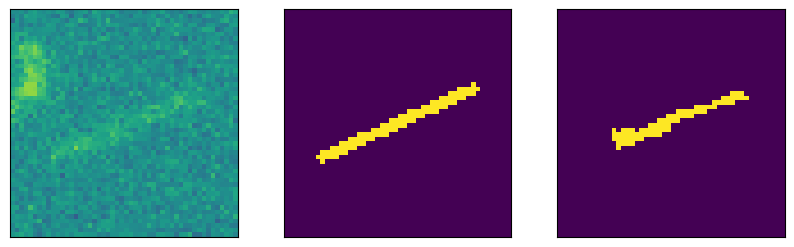

N: 2.0  x: 3066.0  y: 473.0  mag: 23.632579652846523  trail: 37.0


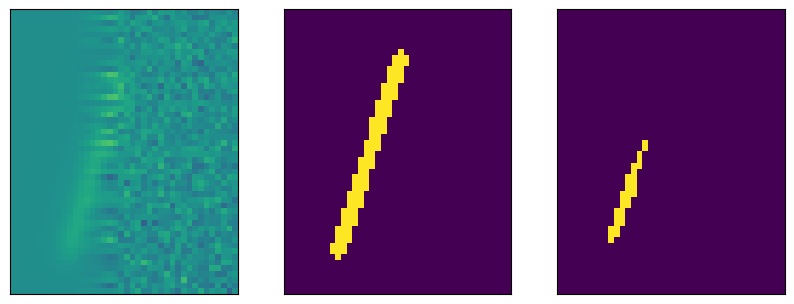

N: 2.0  x: 2209.0  y: 15.0  mag: 23.896764170293938  trail: 36.0


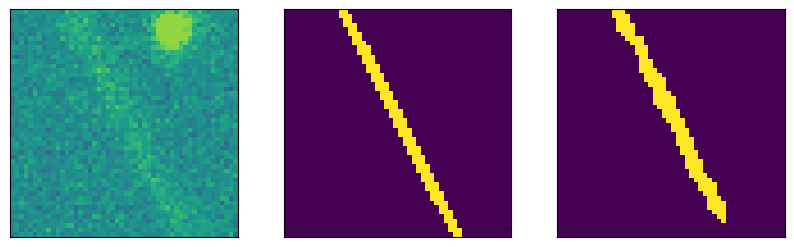

N: 3.0  x: 3286.0  y: 499.0  mag: 23.70659600192104  trail: 71.0


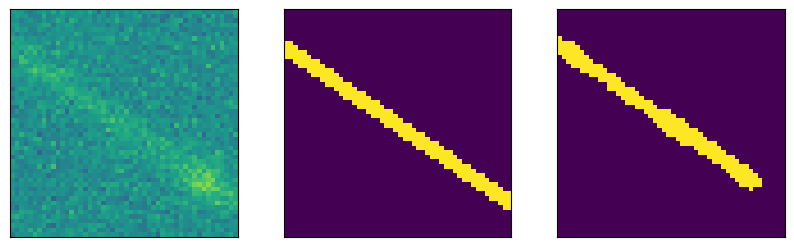

N: 3.0  x: 1688.0  y: 447.0  mag: 23.548359196125286  trail: 66.0


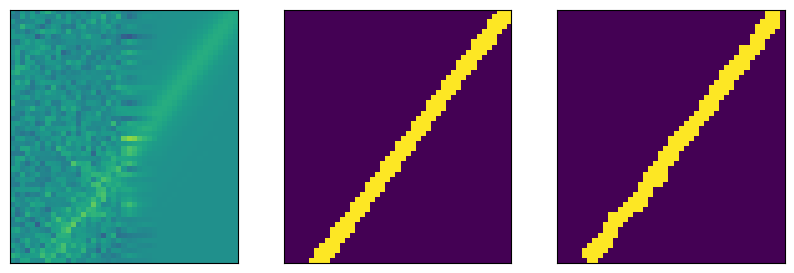

N: 3.0  x: 2590.0  y: 2028.0  mag: 23.580240739829737  trail: 66.0


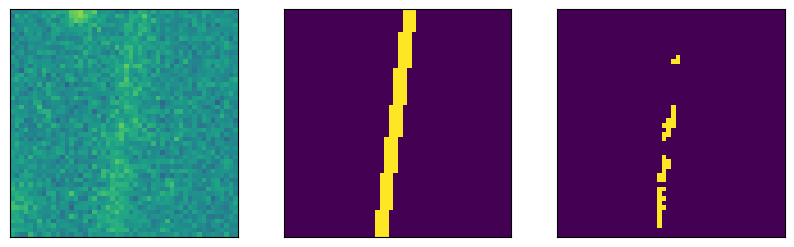

N: 3.0  x: 1809.0  y: 628.0  mag: 23.642724784942605  trail: 62.0


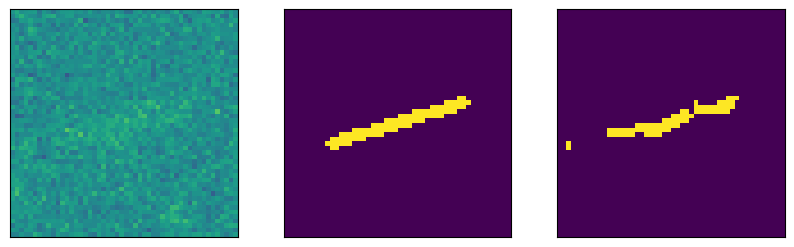

N: 3.0  x: 414.0  y: 1843.0  mag: 23.869686302740426  trail: 30.0


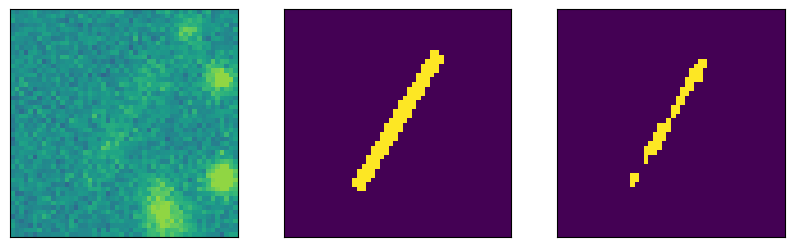

N: 3.0  x: 2837.0  y: 1366.0  mag: 23.781474875167483  trail: 33.0


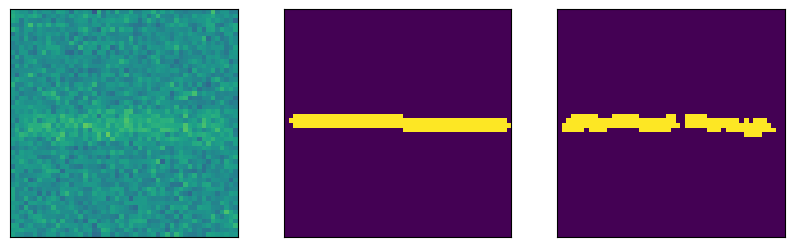

N: 3.0  x: 488.0  y: 1662.0  mag: 23.574544312778926  trail: 46.0


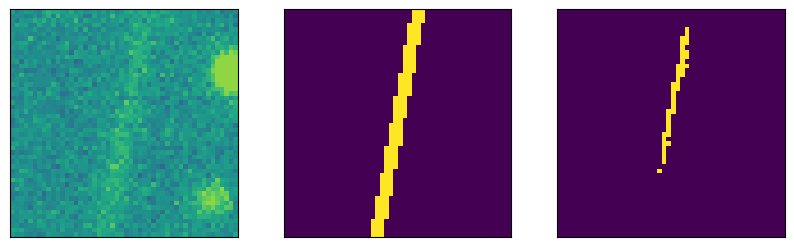

N: 3.0  x: 1232.0  y: 1924.0  mag: 23.547637743258846  trail: 61.0


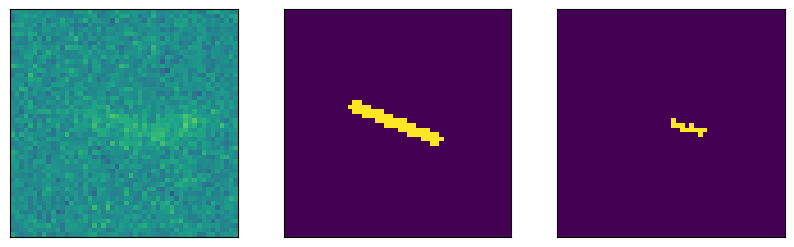

N: 3.0  x: 3063.0  y: 770.0  mag: 23.661832912637596  trail: 20.0


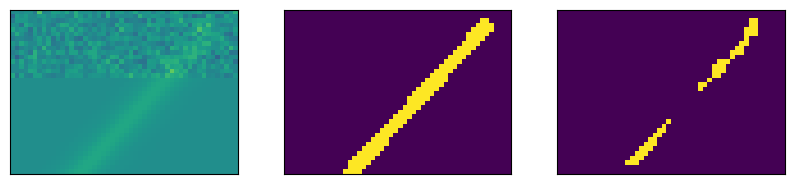

N: 3.0  x: 4165.0  y: 765.0  mag: 23.747114825973902  trail: 57.0


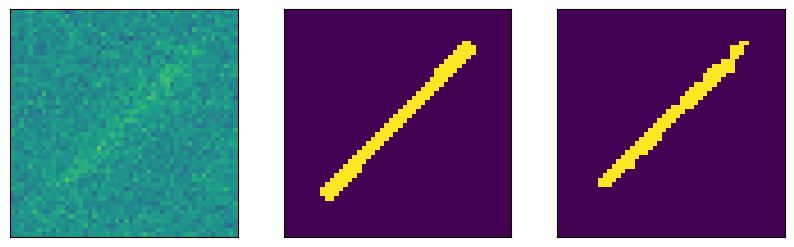

N: 3.0  x: 3627.0  y: 1875.0  mag: 23.74887565740576  trail: 44.0


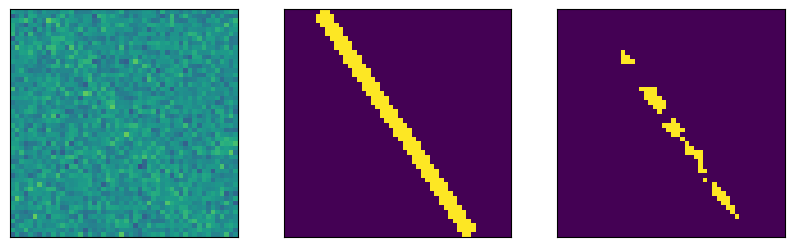

N: 6.0  x: 1440.0  y: 1774.0  mag: 23.604856416607756  trail: 57.0


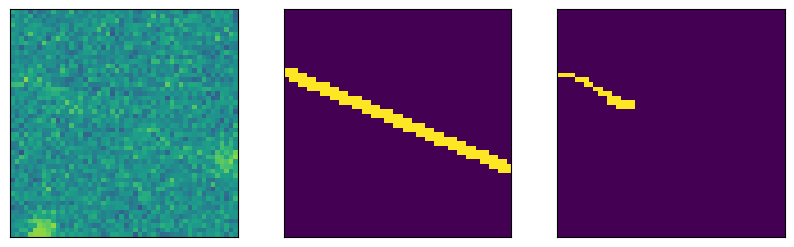

N: 6.0  x: 541.0  y: 1999.0  mag: 23.692950243315128  trail: 71.0


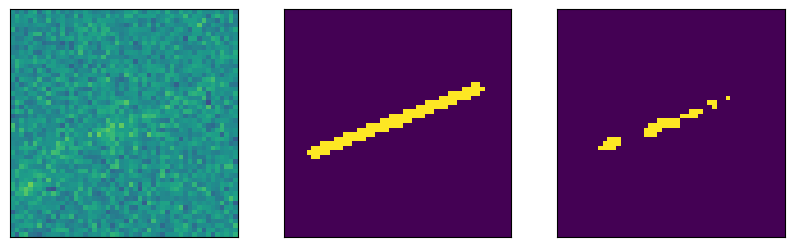

N: 6.0  x: 583.0  y: 826.0  mag: 23.59598045942364  trail: 39.0


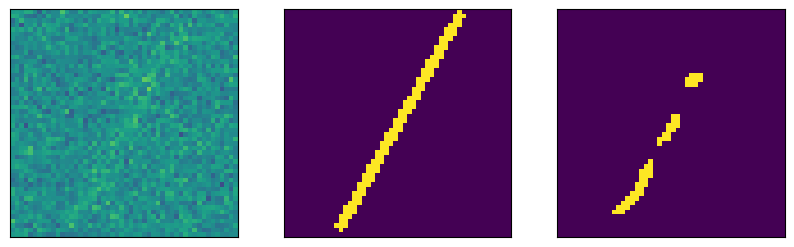

N: 6.0  x: 1677.0  y: 1192.0  mag: 23.633154609476797  trail: 53.0


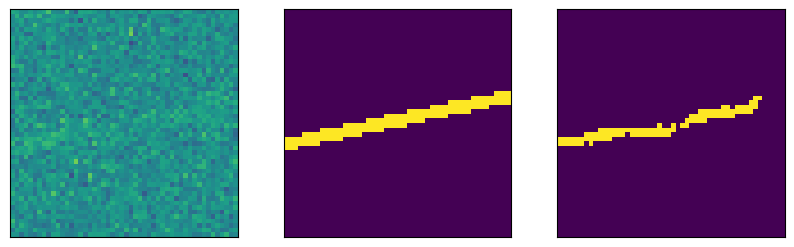

N: 6.0  x: 1768.0  y: 1768.0  mag: 23.658817993936502  trail: 57.0


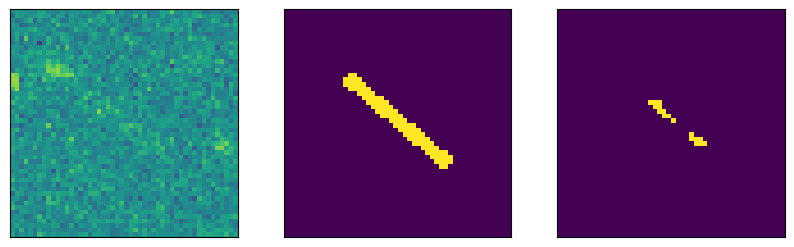

N: 6.0  x: 3877.0  y: 1804.0  mag: 23.748772571736783  trail: 28.0


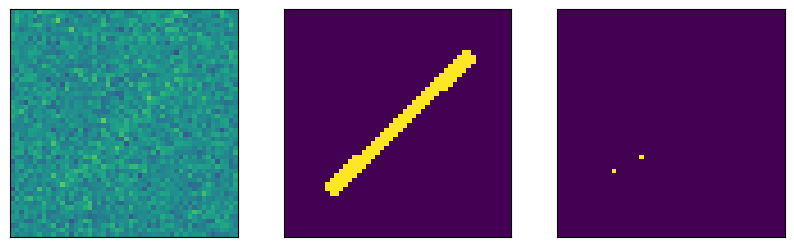

N: 6.0  x: 2450.0  y: 122.0  mag: 23.768246013272268  trail: 42.0


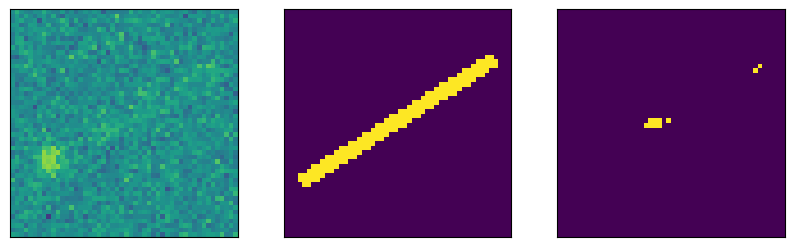

N: 7.0  x: 2676.0  y: 225.0  mag: 23.939371876107625  trail: 49.0


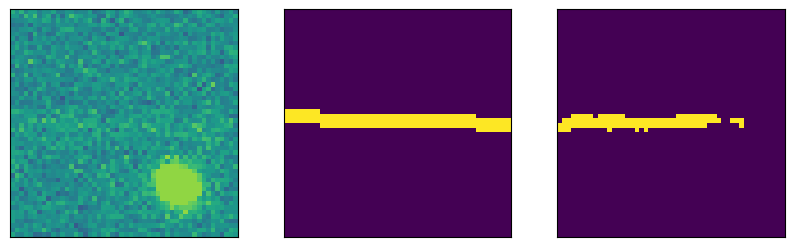

N: 7.0  x: 672.0  y: 1703.0  mag: 23.7498922713543  trail: 67.0


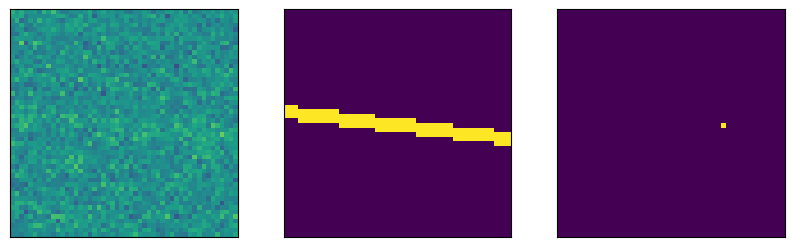

N: 7.0  x: 2595.0  y: 893.0  mag: 23.78658061601148  trail: 68.0


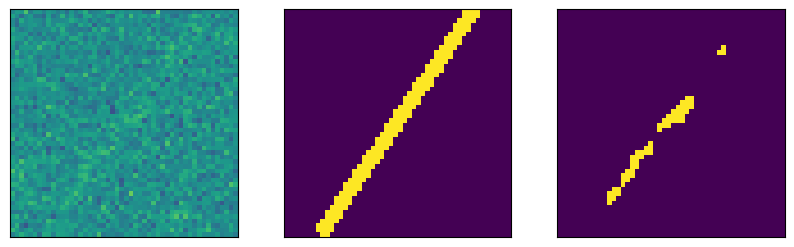

N: 7.0  x: 1822.0  y: 1344.0  mag: 23.96354776003615  trail: 58.0


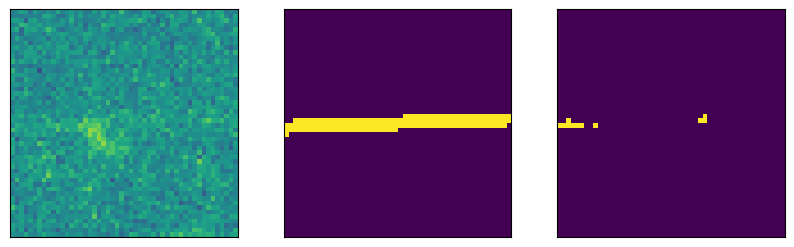

N: 7.0  x: 2675.0  y: 1213.0  mag: 23.651499836212732  trail: 72.0


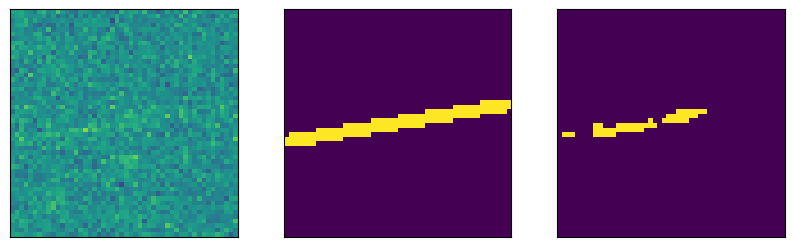

N: 7.0  x: 648.0  y: 681.0  mag: 23.963503811525616  trail: 55.0


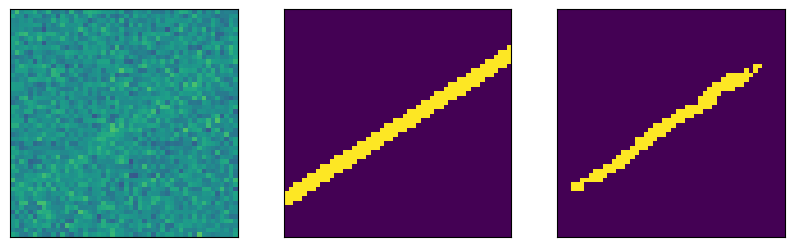

N: 7.0  x: 2497.0  y: 315.0  mag: 23.74452003228639  trail: 59.0


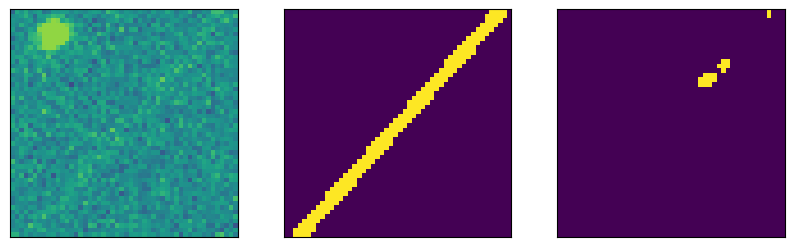

N: 7.0  x: 3546.0  y: 1154.0  mag: 23.664040094156388  trail: 66.0


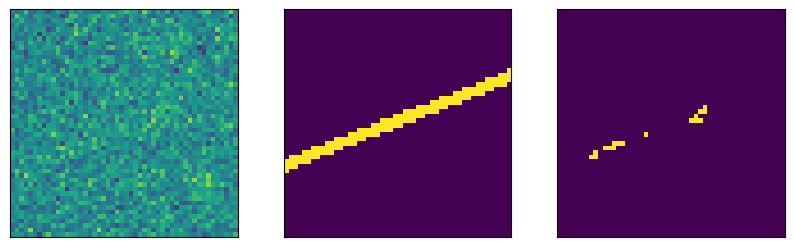

N: 8.0  x: 2877.0  y: 443.0  mag: 23.873492461099534  trail: 65.0


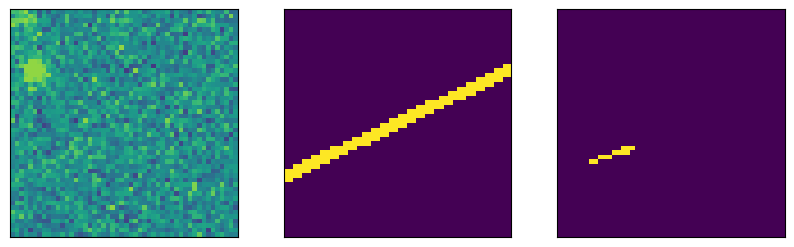

N: 8.0  x: 3885.0  y: 1449.0  mag: 23.974966293649267  trail: 68.0


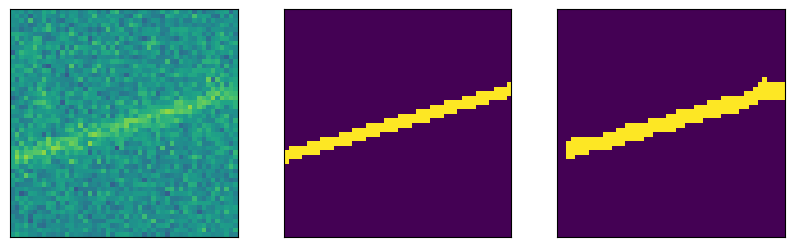

N: 9.0  x: 3982.0  y: 280.0  mag: 23.533874335961773  trail: 54.0


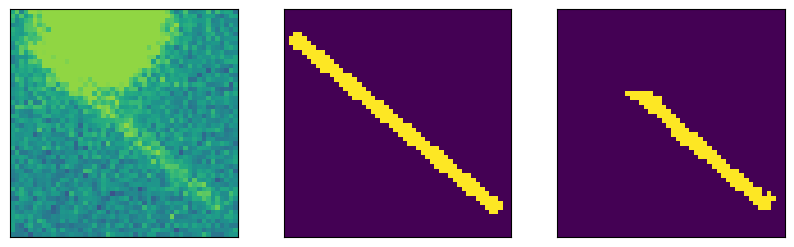

N: 9.0  x: 4104.0  y: 1807.0  mag: 23.673475167205225  trail: 58.0


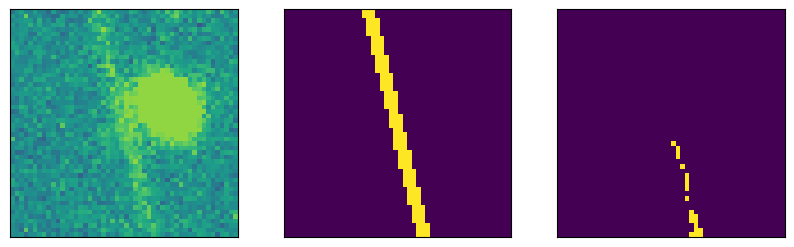

N: 9.0  x: 4117.0  y: 332.0  mag: 23.662411902222654  trail: 60.0


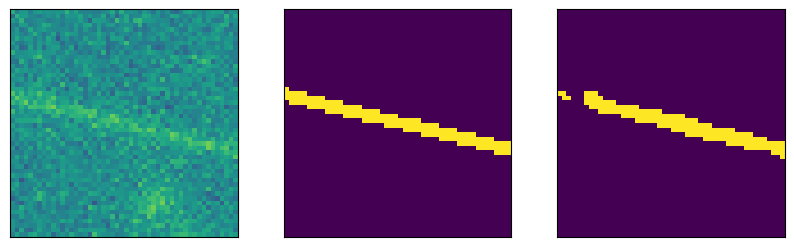

N: 9.0  x: 3789.0  y: 1172.0  mag: 23.888730908492118  trail: 72.0


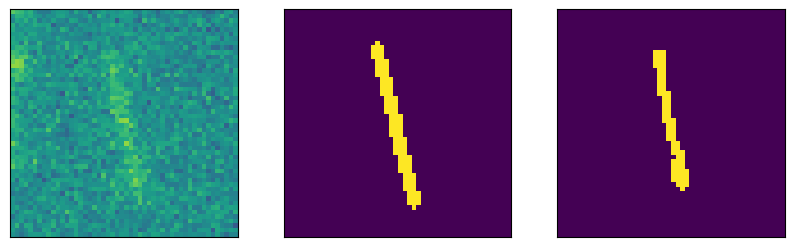

N: 9.0  x: 3001.0  y: 691.0  mag: 23.72775983290759  trail: 35.0


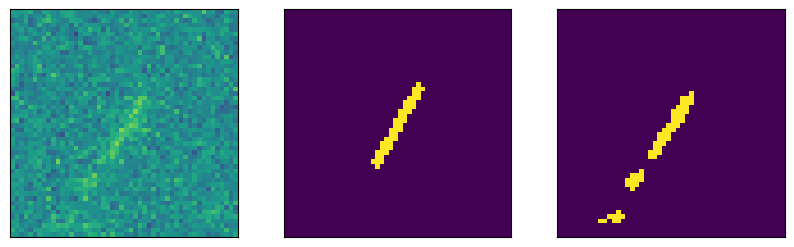

N: 9.0  x: 201.0  y: 368.0  mag: 23.799243719765485  trail: 18.0


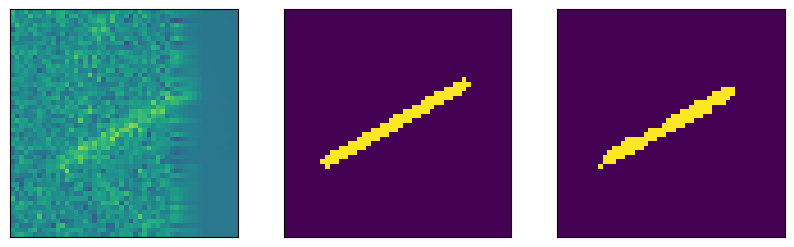

N: 9.0  x: 616.0  y: 2015.0  mag: 23.70329807186985  trail: 34.0


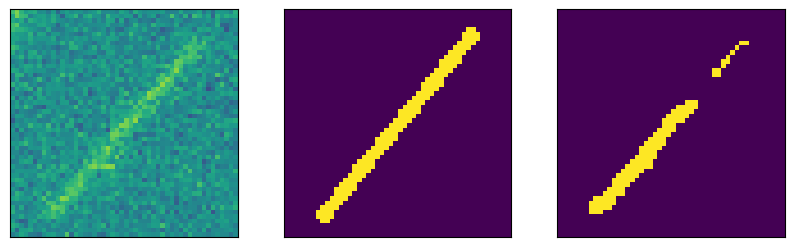

N: 9.0  x: 2822.0  y: 682.0  mag: 23.61313107320905  trail: 52.0


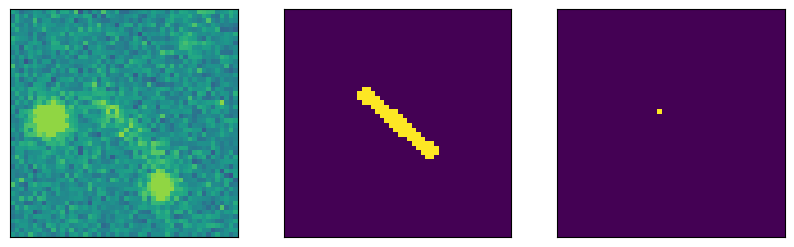

N: 9.0  x: 609.0  y: 164.0  mag: 23.638850424338962  trail: 19.0


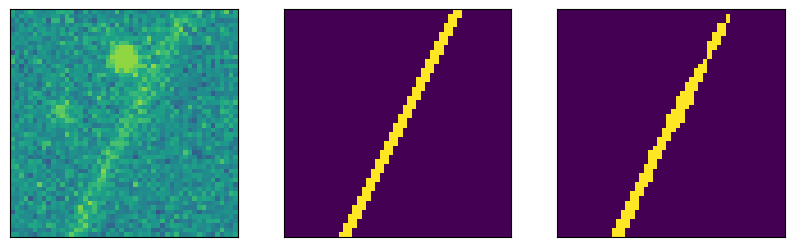

N: 9.0  x: 342.0  y: 1462.0  mag: 23.93840460809844  trail: 59.0


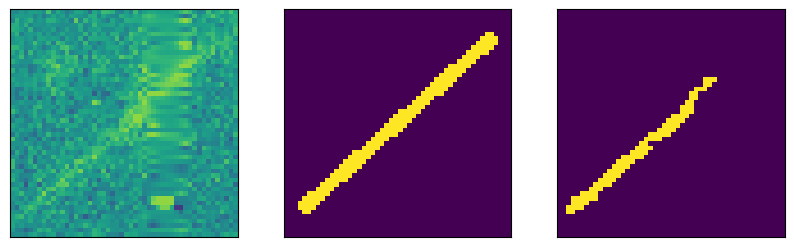

N: 9.0  x: 2122.0  y: 1947.0  mag: 23.92912538630161  trail: 55.0


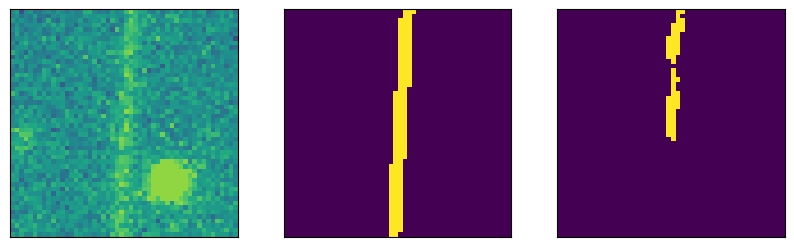

N: 9.0  x: 227.0  y: 447.0  mag: 23.644605752484384  trail: 64.0


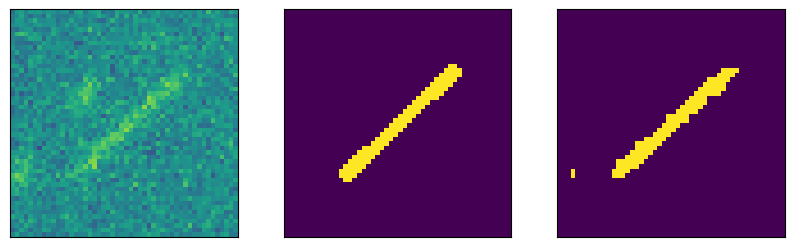

N: 9.0  x: 656.0  y: 280.0  mag: 23.567727471842556  trail: 33.0


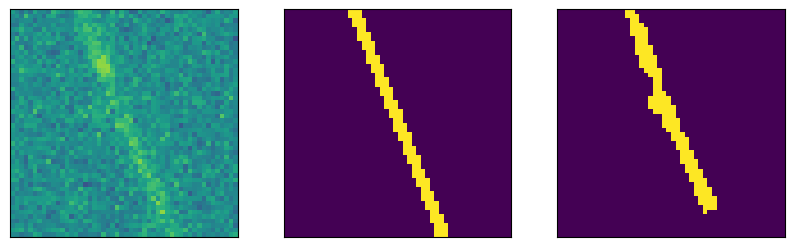

N: 9.0  x: 3051.0  y: 1988.0  mag: 23.924978149512604  trail: 73.0


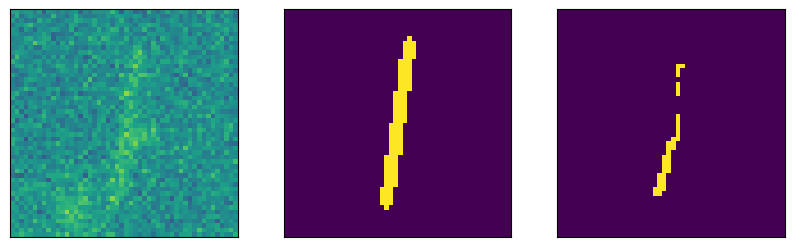

N: 9.0  x: 360.0  y: 1812.0  mag: 23.98473904652742  trail: 35.0


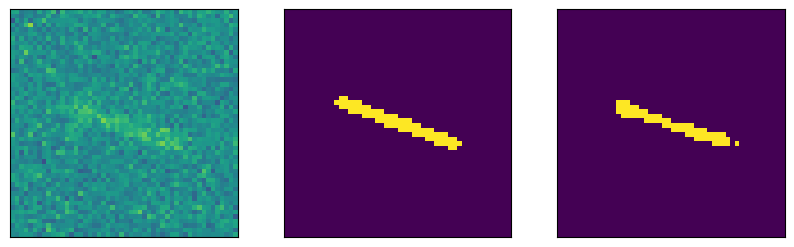

N: 9.0  x: 1641.0  y: 427.0  mag: 23.765145378921265  trail: 27.0


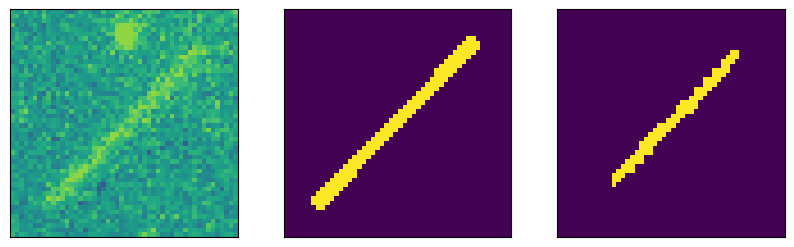

N: 9.0  x: 1465.0  y: 313.0  mag: 23.59529077794284  trail: 49.0


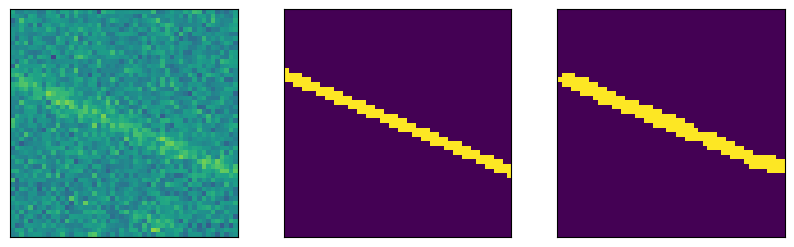

N: 9.0  x: 983.0  y: 95.0  mag: 23.792665795854465  trail: 54.0


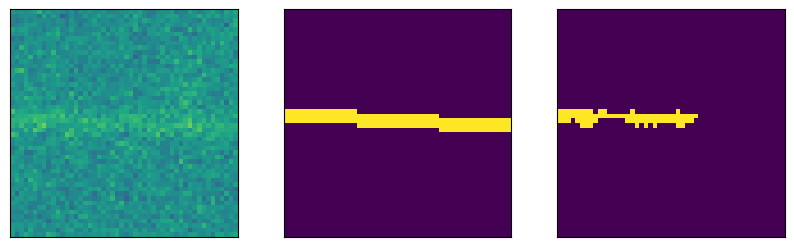

N: 10.0  x: 3967.0  y: 81.0  mag: 23.616944969016423  trail: 71.0


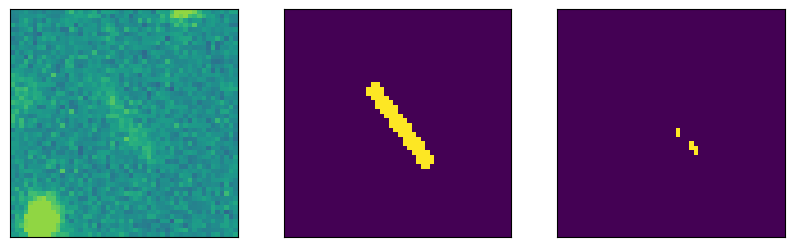

N: 10.0  x: 3419.0  y: 494.0  mag: 23.703703794027025  trail: 20.0


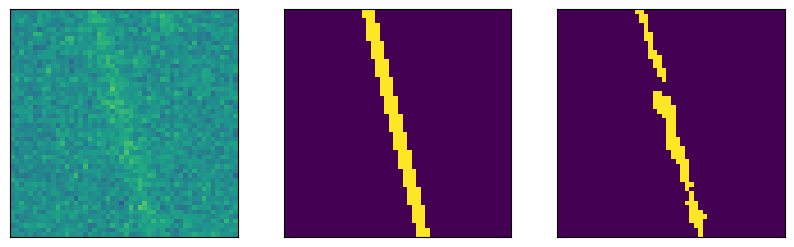

N: 10.0  x: 3976.0  y: 707.0  mag: 23.972737053406576  trail: 58.0


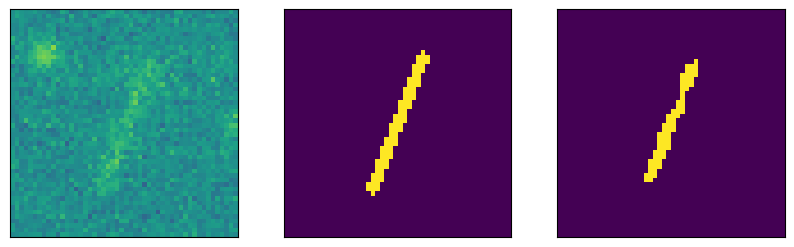

N: 10.0  x: 2076.0  y: 957.0  mag: 23.633681040677406  trail: 31.0


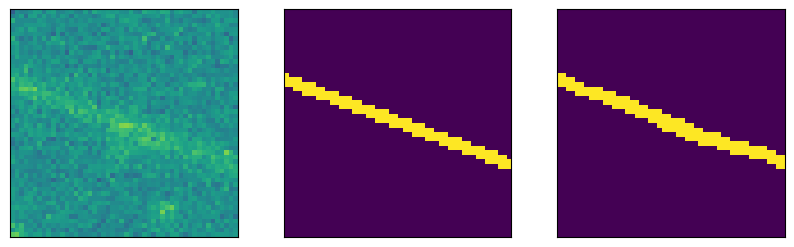

N: 10.0  x: 3957.0  y: 586.0  mag: 23.60019800348472  trail: 60.0


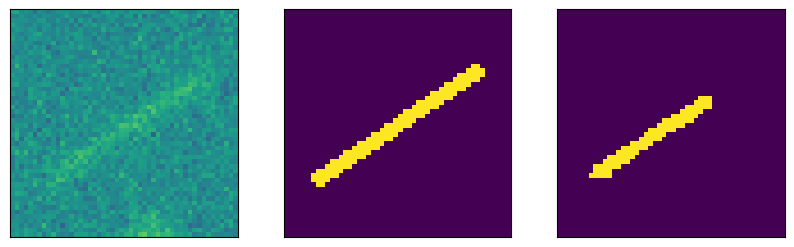

N: 10.0  x: 1556.0  y: 1270.0  mag: 23.685946851391517  trail: 43.0


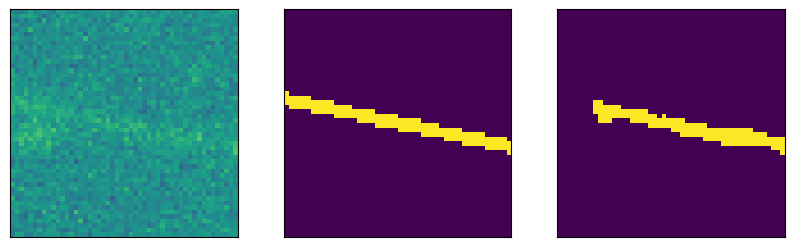

N: 10.0  x: 3934.0  y: 1426.0  mag: 23.97619173537212  trail: 72.0


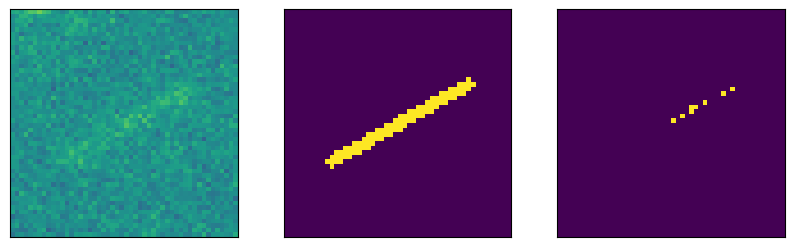

N: 10.0  x: 2240.0  y: 1283.0  mag: 23.692791219276362  trail: 35.0


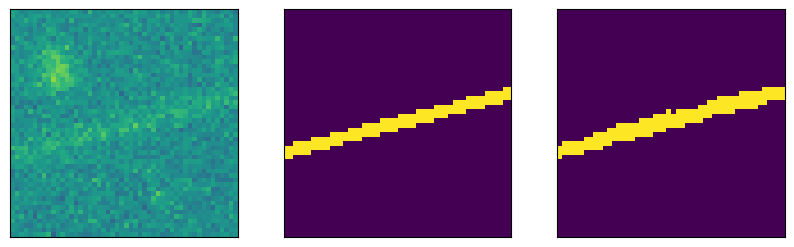

N: 10.0  x: 1180.0  y: 417.0  mag: 23.84968919809525  trail: 67.0


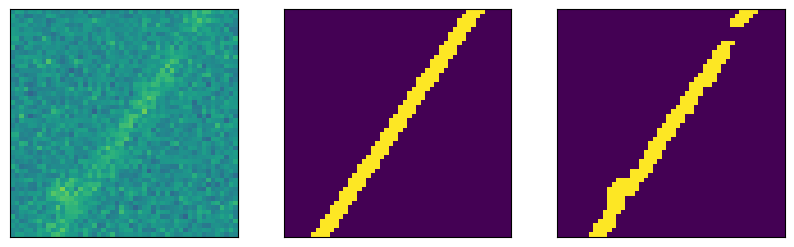

N: 10.0  x: 174.0  y: 956.0  mag: 23.63703784098854  trail: 69.0


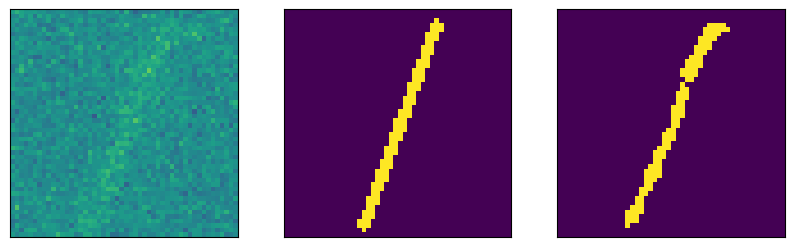

N: 10.0  x: 486.0  y: 543.0  mag: 23.846592503116202  trail: 47.0


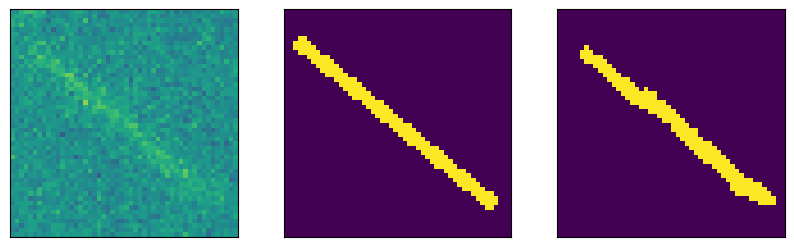

N: 10.0  x: 345.0  y: 936.0  mag: 23.710739948405006  trail: 54.0


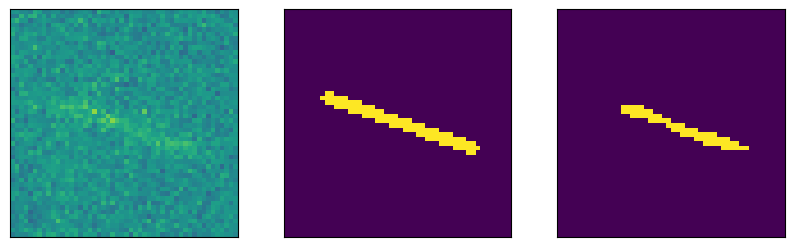

N: 10.0  x: 265.0  y: 197.0  mag: 23.586540875277645  trail: 34.0


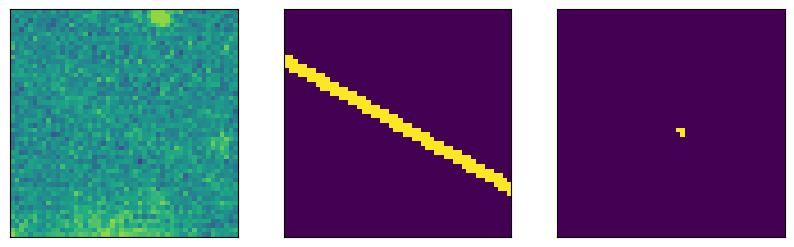

N: 11.0  x: 3389.0  y: 1573.0  mag: 23.84697640557339  trail: 71.0


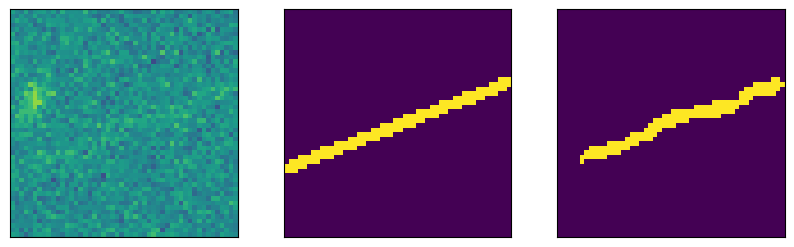

N: 11.0  x: 1966.0  y: 1852.0  mag: 23.65310587959001  trail: 61.0


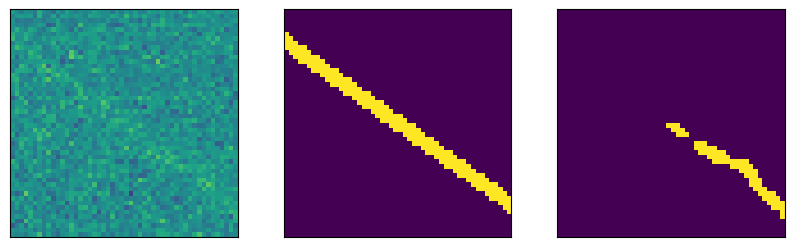

N: 11.0  x: 2306.0  y: 296.0  mag: 23.503465252539048  trail: 70.0


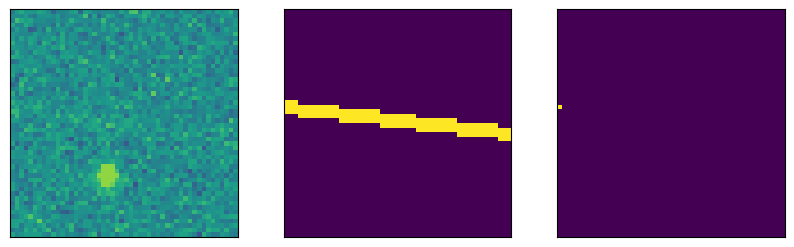

N: 11.0  x: 115.0  y: 846.0  mag: 23.8188416781471  trail: 72.0


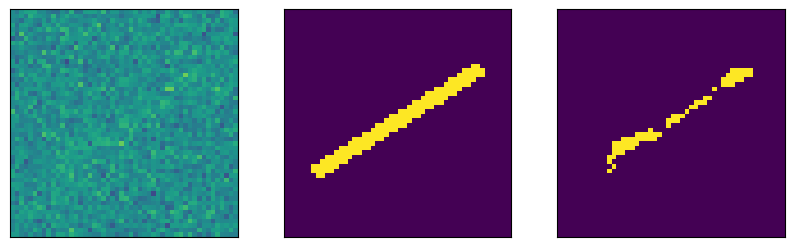

N: 11.0  x: 542.0  y: 1643.0  mag: 23.830082867595692  trail: 41.0


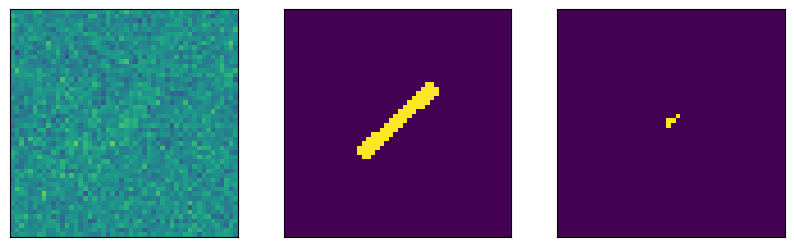

N: 11.0  x: 138.0  y: 161.0  mag: 23.57841796296262  trail: 21.0


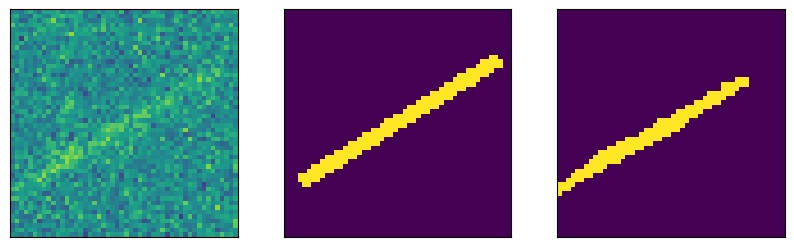

N: 12.0  x: 3467.0  y: 310.0  mag: 23.574969635354826  trail: 49.0


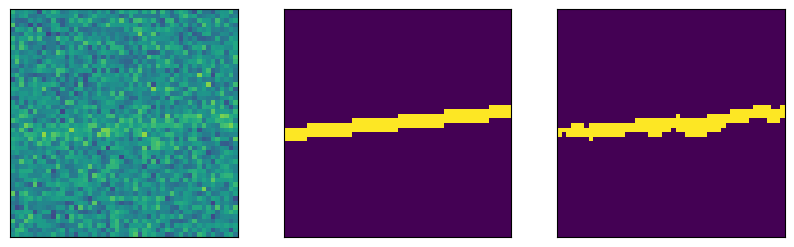

N: 12.0  x: 3115.0  y: 726.0  mag: 23.998012677824924  trail: 71.0


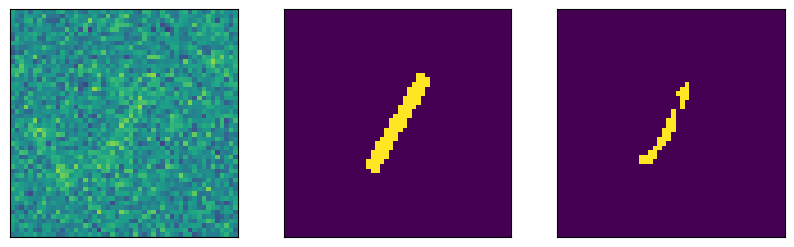

N: 12.0  x: 2644.0  y: 1586.0  mag: 23.542862799603167  trail: 23.0


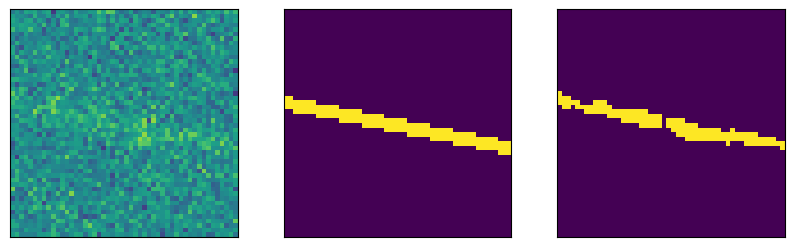

N: 12.0  x: 416.0  y: 341.0  mag: 23.924305976841243  trail: 61.0


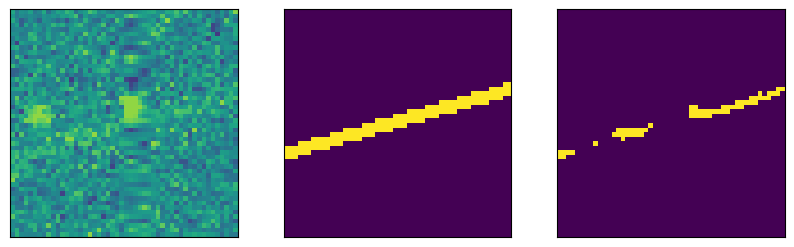

N: 12.0  x: 2061.0  y: 1021.0  mag: 23.948220678140913  trail: 58.0


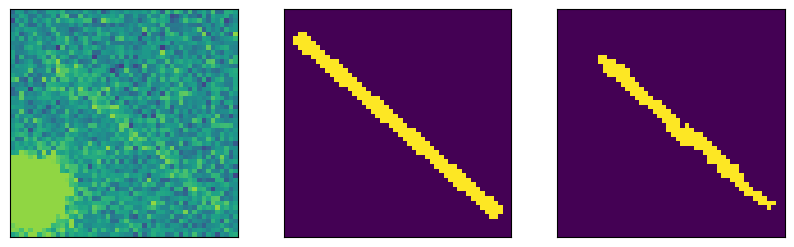

N: 12.0  x: 1069.0  y: 791.0  mag: 23.78065001730701  trail: 57.0


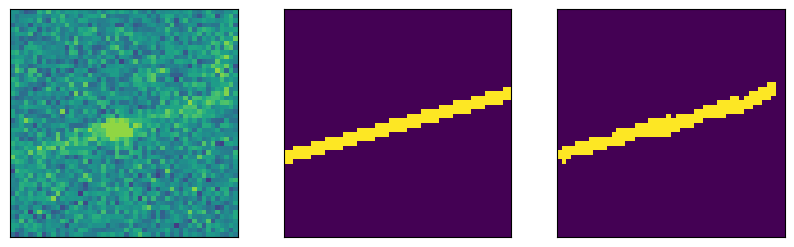

N: 12.0  x: 185.0  y: 103.0  mag: 23.663000065503386  trail: 51.0


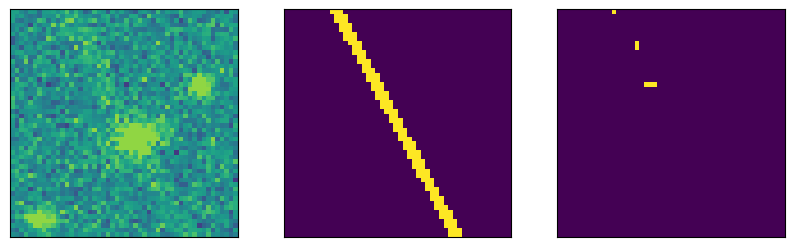

N: 12.0  x: 901.0  y: 91.0  mag: 23.964474472903287  trail: 66.0


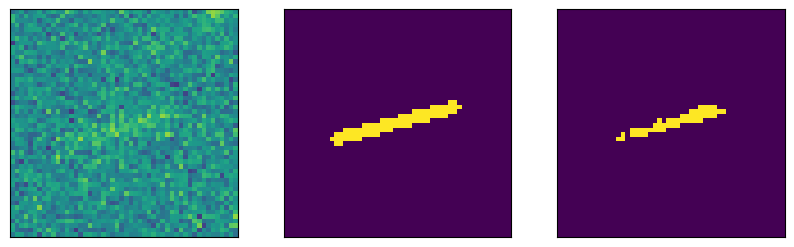

N: 12.0  x: 235.0  y: 600.0  mag: 23.62507672410328  trail: 27.0


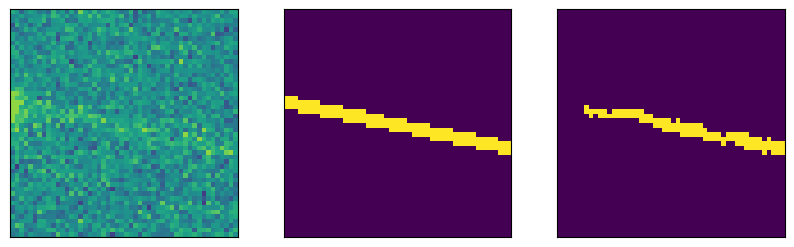

N: 13.0  x: 1800.0  y: 953.0  mag: 23.749271373637956  trail: 60.0


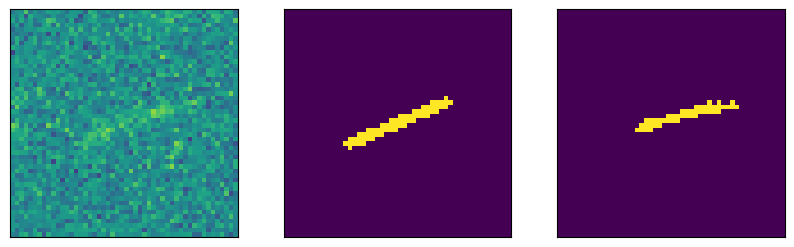

N: 13.0  x: 2163.0  y: 1991.0  mag: 23.683374730547936  trail: 23.0


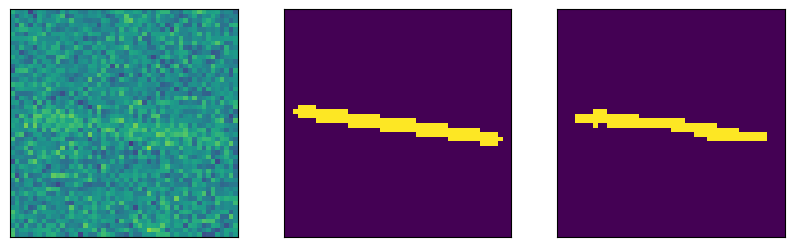

N: 13.0  x: 740.0  y: 1613.0  mag: 23.65494277590487  trail: 44.0


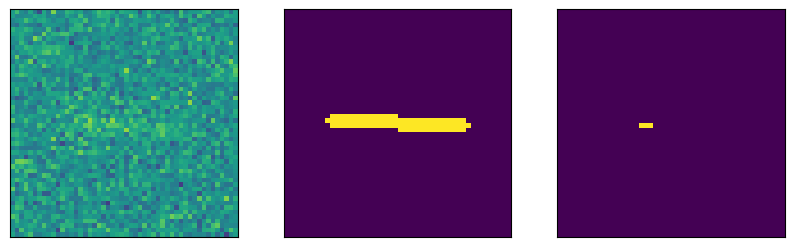

N: 13.0  x: 2610.0  y: 338.0  mag: 23.84568251161138  trail: 29.0


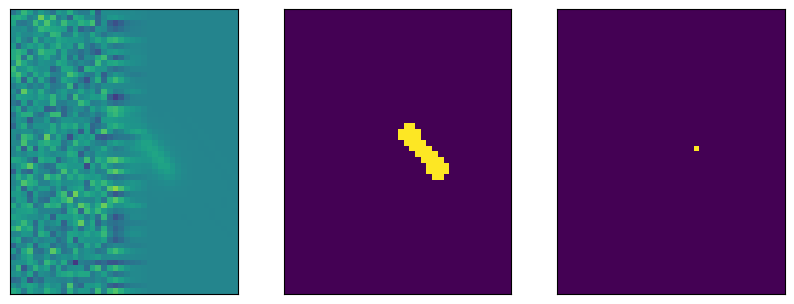

N: 13.0  x: 883.0  y: 2033.0  mag: 23.72277333556867  trail: 10.0


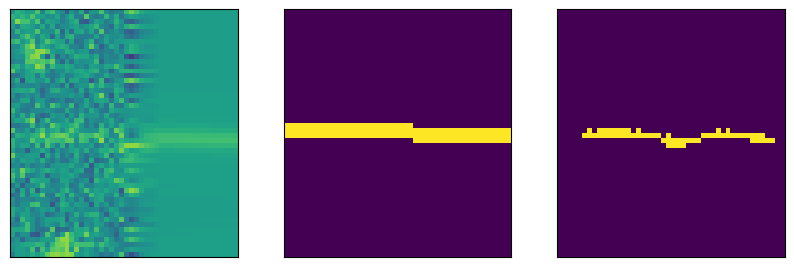

N: 13.0  x: 2970.0  y: 2027.0  mag: 23.706994046715998  trail: 50.0


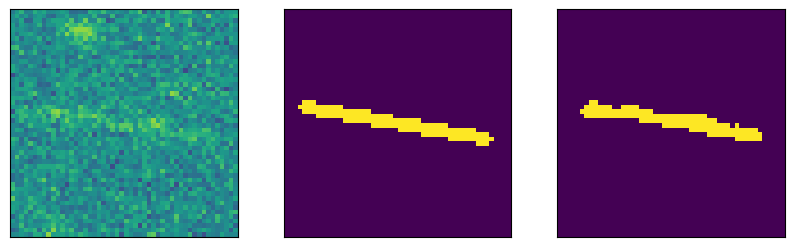

N: 13.0  x: 3512.0  y: 1557.0  mag: 23.504931023060543  trail: 41.0


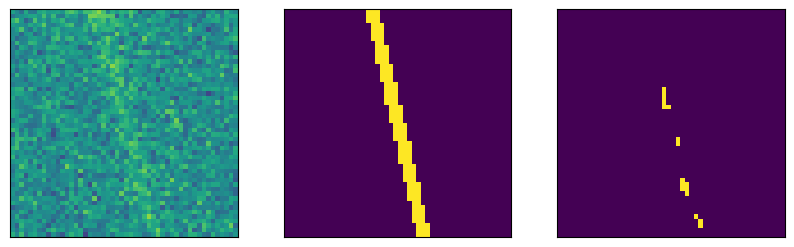

N: 13.0  x: 1228.0  y: 649.0  mag: 23.62594574867517  trail: 59.0


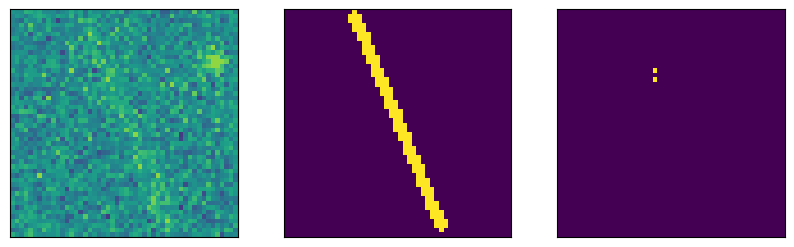

N: 13.0  x: 639.0  y: 409.0  mag: 23.773920873606865  trail: 50.0


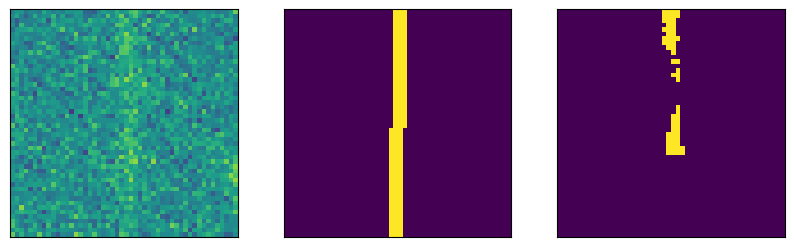

N: 13.0  x: 119.0  y: 1300.0  mag: 23.72834878889576  trail: 58.0


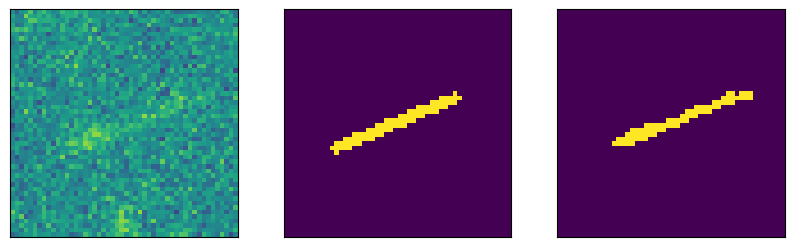

N: 13.0  x: 182.0  y: 1245.0  mag: 23.58263284962468  trail: 29.0


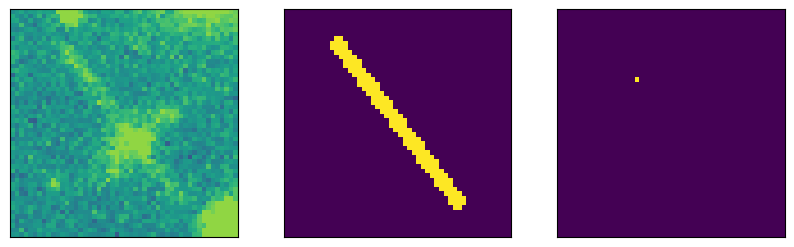

N: 14.0  x: 4048.0  y: 1901.0  mag: 23.745259898690122  trail: 44.0


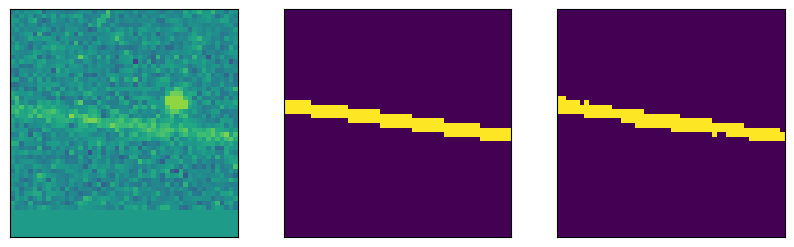

N: 14.0  x: 4136.0  y: 173.0  mag: 23.728308259189056  trail: 58.0


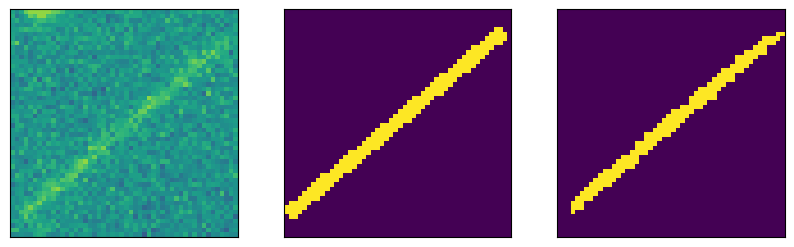

N: 14.0  x: 3147.0  y: 1377.0  mag: 23.782399573431544  trail: 60.0


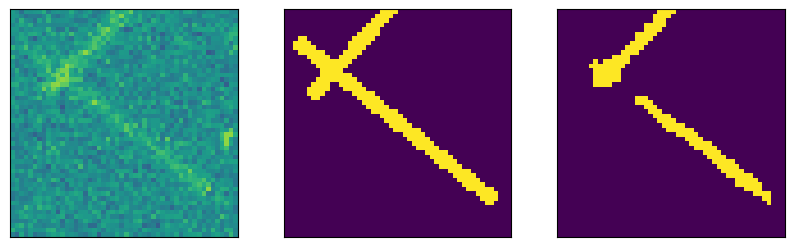

N: 14.0  x: 1719.0  y: 427.0  mag: 23.950800731713663  trail: 54.0


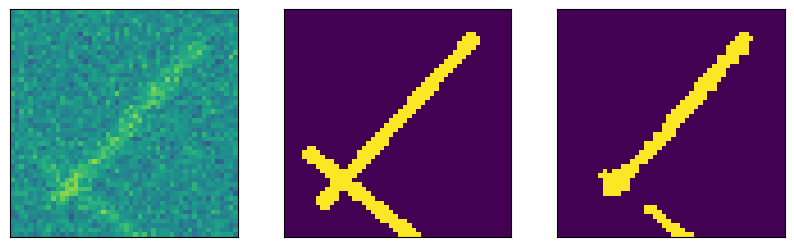

N: 14.0  x: 1695.0  y: 425.0  mag: 23.613206957763776  trail: 49.0


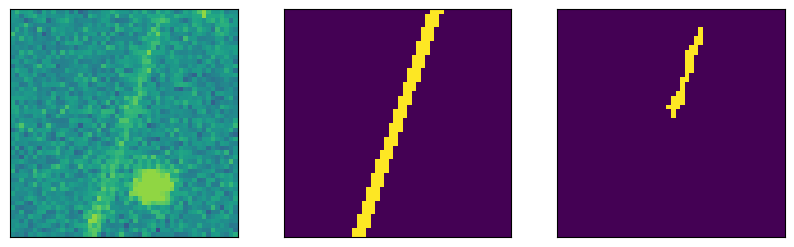

N: 14.0  x: 2131.0  y: 1923.0  mag: 23.8773923757936  trail: 53.0


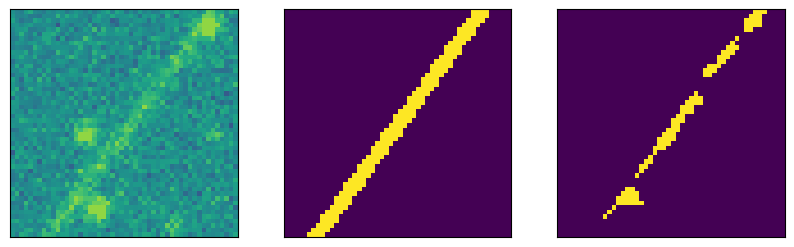

N: 14.0  x: 520.0  y: 1122.0  mag: 23.64907109452417  trail: 70.0


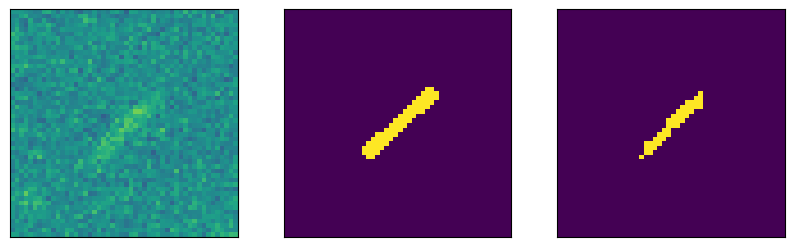

N: 14.0  x: 2099.0  y: 152.0  mag: 23.67722859174824  trail: 19.0


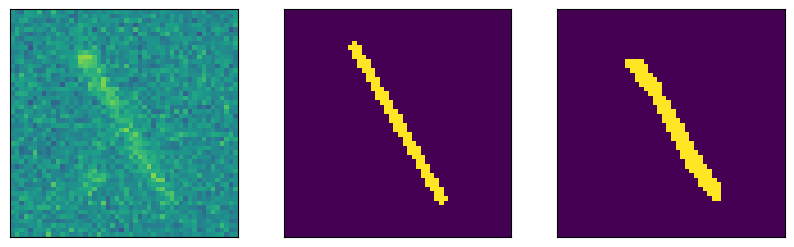

N: 14.0  x: 1423.0  y: 687.0  mag: 23.59921395293273  trail: 39.0


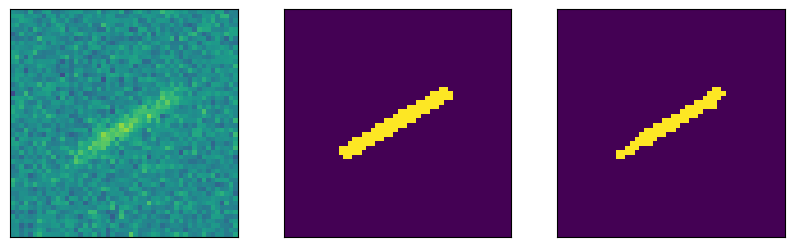

N: 14.0  x: 1049.0  y: 1139.0  mag: 23.50332522827782  trail: 26.0


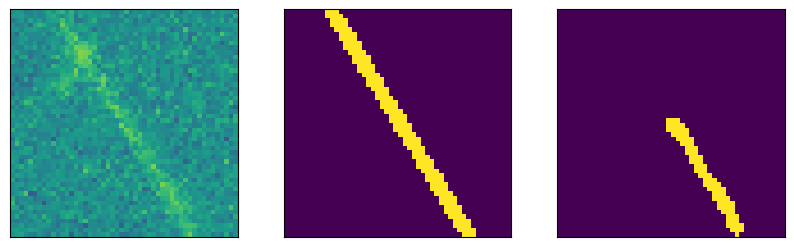

N: 14.0  x: 2050.0  y: 815.0  mag: 23.772833918085105  trail: 57.0


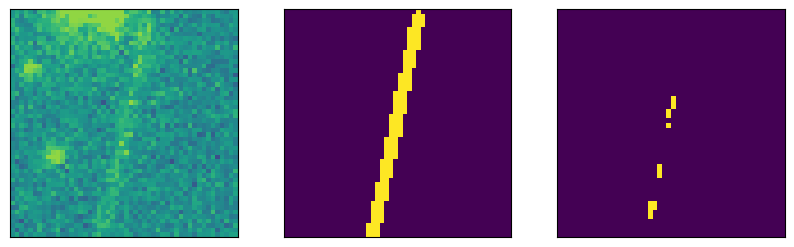

N: 14.0  x: 1103.0  y: 960.0  mag: 23.896407322212465  trail: 49.0


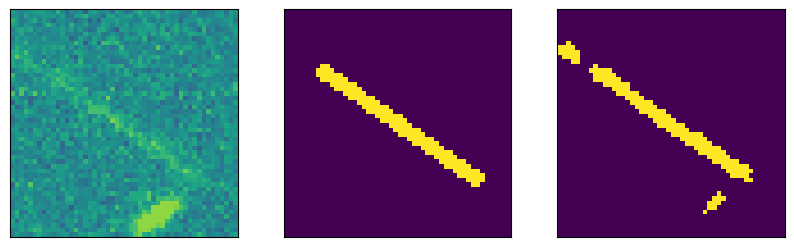

N: 14.0  x: 672.0  y: 575.0  mag: 23.89271268019124  trail: 42.0


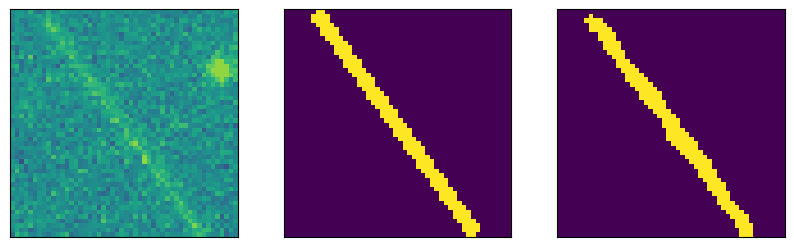

N: 14.0  x: 25.0  y: 1690.0  mag: 23.821180192289745  trail: 59.0


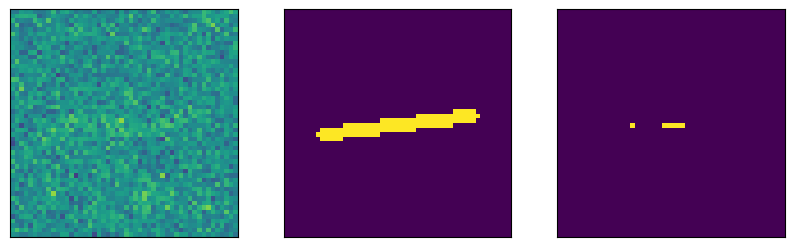

N: 15.0  x: 134.0  y: 139.0  mag: 23.687913739221  trail: 33.0


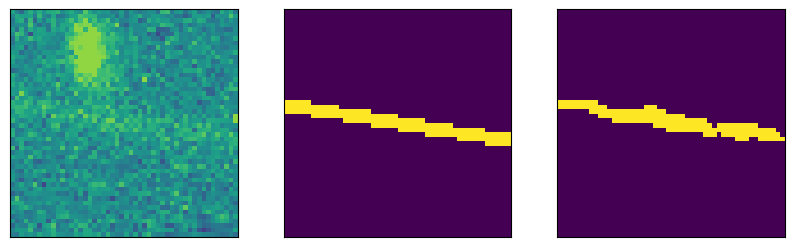

N: 16.0  x: 475.0  y: 1758.0  mag: 23.706031033437363  trail: 69.0


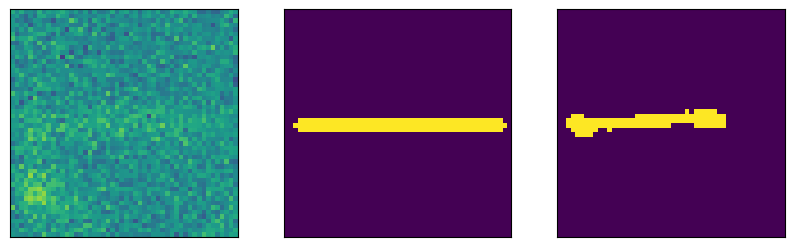

N: 16.0  x: 1372.0  y: 1651.0  mag: 23.83573964823272  trail: 44.0


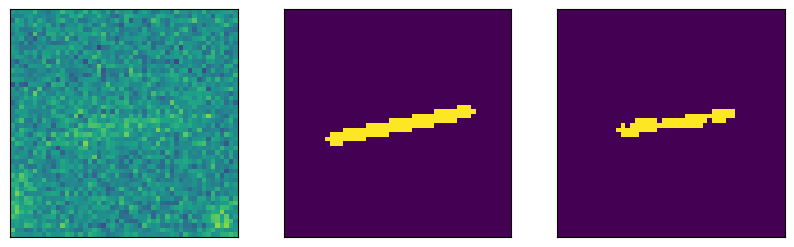

N: 16.0  x: 494.0  y: 1512.0  mag: 23.736255425074305  trail: 31.0


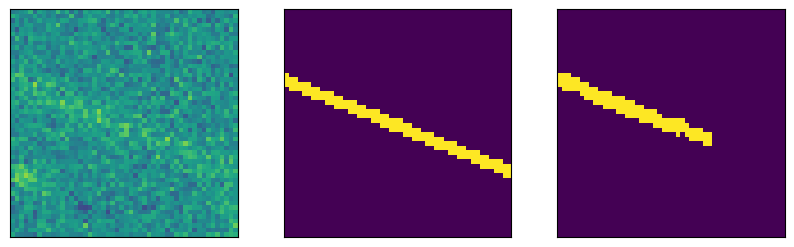

N: 16.0  x: 160.0  y: 884.0  mag: 23.819076508207445  trail: 69.0


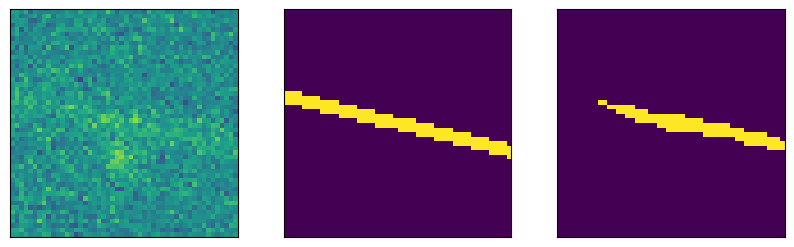

N: 16.0  x: 427.0  y: 1114.0  mag: 23.973667073853075  trail: 64.0


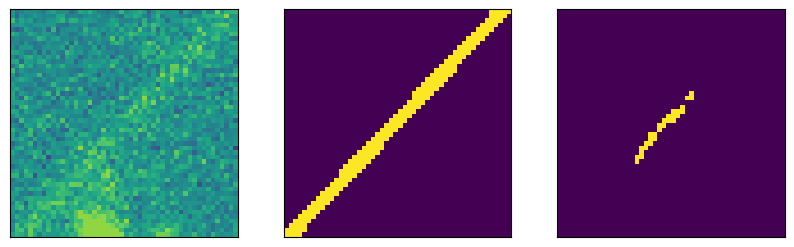

N: 16.0  x: 1132.0  y: 887.0  mag: 23.542740103760107  trail: 71.0


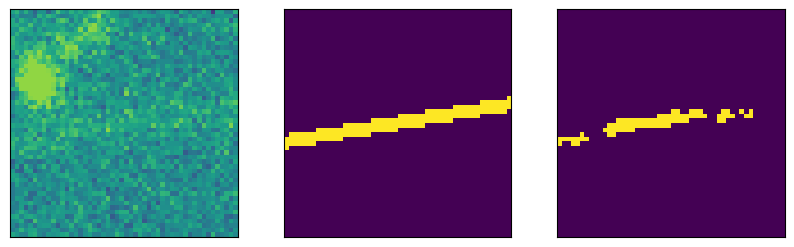

N: 16.0  x: 1228.0  y: 106.0  mag: 23.96106540648455  trail: 66.0


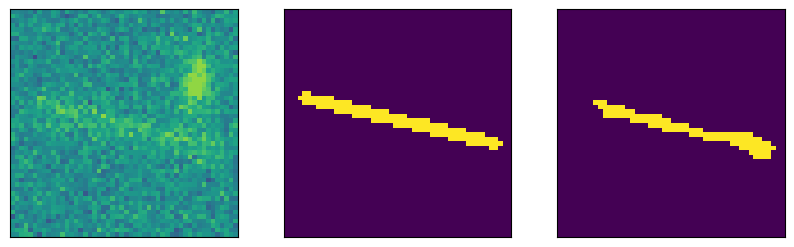

N: 16.0  x: 3337.0  y: 1073.0  mag: 23.512750780165348  trail: 43.0


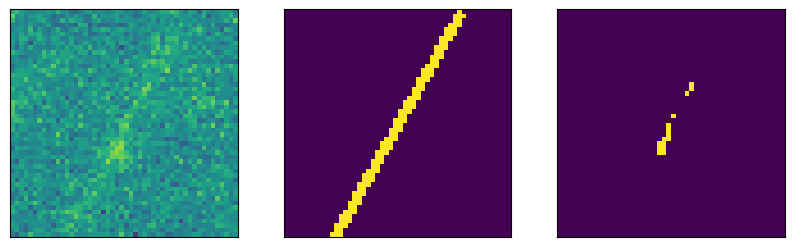

N: 16.0  x: 1877.0  y: 1270.0  mag: 23.949053361005348  trail: 55.0


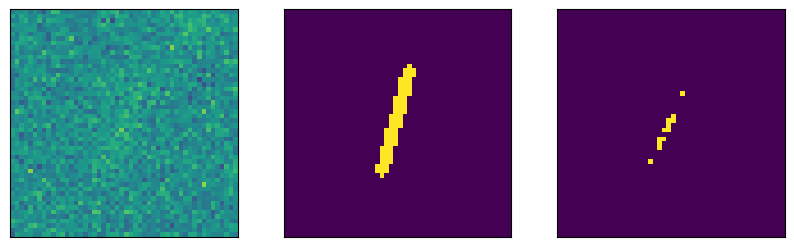

N: 16.0  x: 2196.0  y: 978.0  mag: 23.963494324813034  trail: 22.0


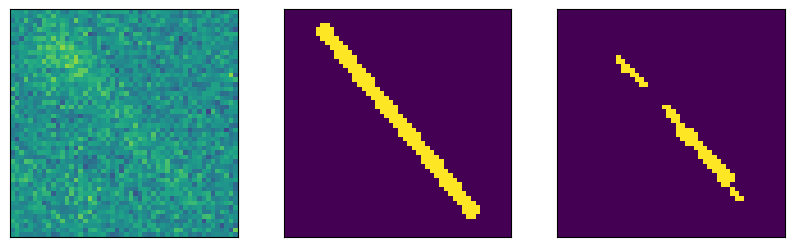

N: 16.0  x: 1316.0  y: 490.0  mag: 23.97824140065321  trail: 52.0


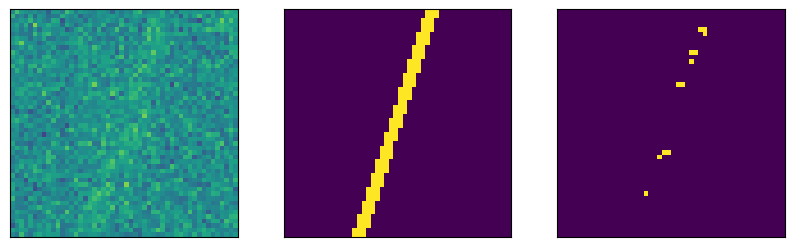

N: 16.0  x: 1472.0  y: 1300.0  mag: 23.99875987735151  trail: 52.0


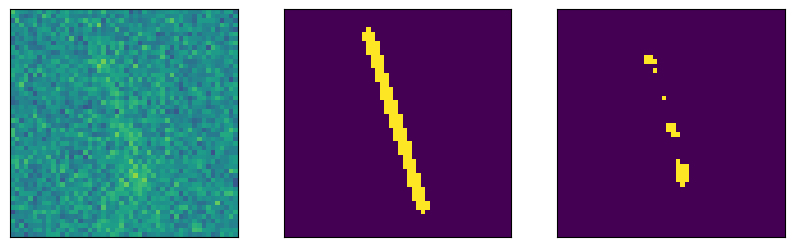

N: 16.0  x: 2154.0  y: 615.0  mag: 23.999894693448965  trail: 40.0


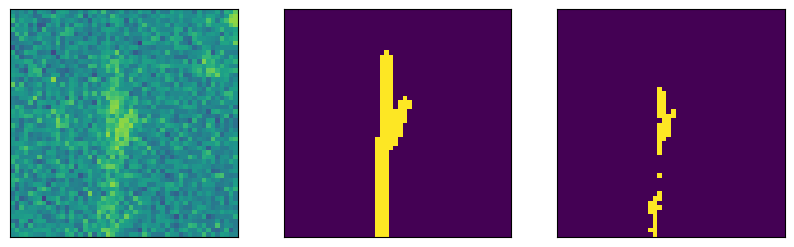

N: 17.0  x: 613.0  y: 1338.0  mag: 23.61603663543169  trail: 9.0


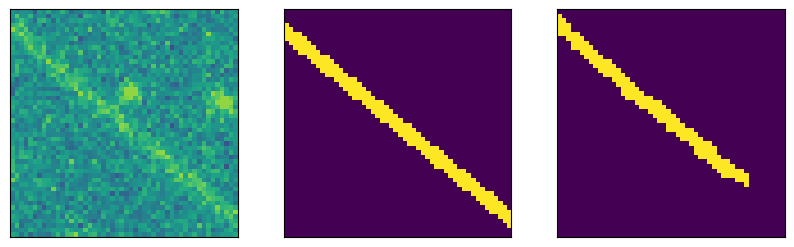

N: 17.0  x: 3569.0  y: 1335.0  mag: 23.77036526373993  trail: 71.0


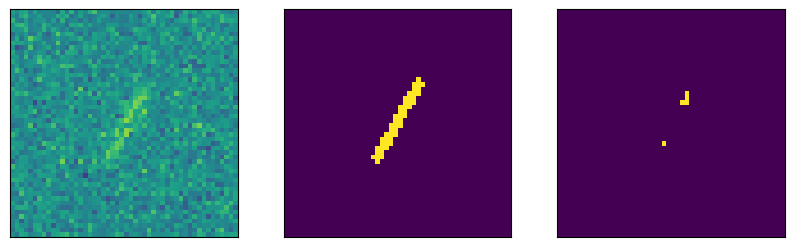

N: 17.0  x: 1112.0  y: 475.0  mag: 23.68182040098287  trail: 18.0


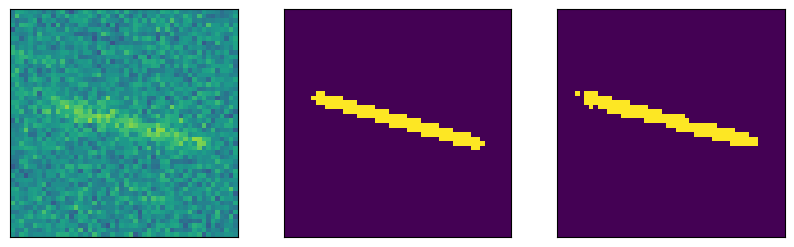

N: 17.0  x: 2837.0  y: 1061.0  mag: 23.686899783528297  trail: 36.0


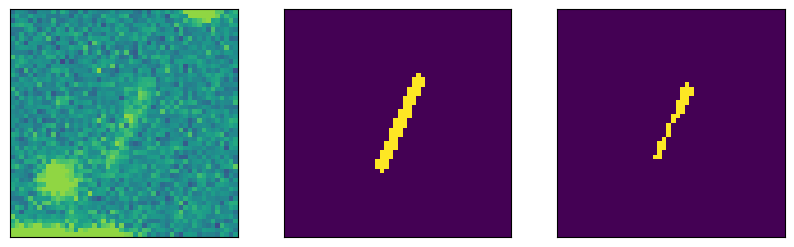

N: 17.0  x: 394.0  y: 592.0  mag: 23.607731648019172  trail: 21.0


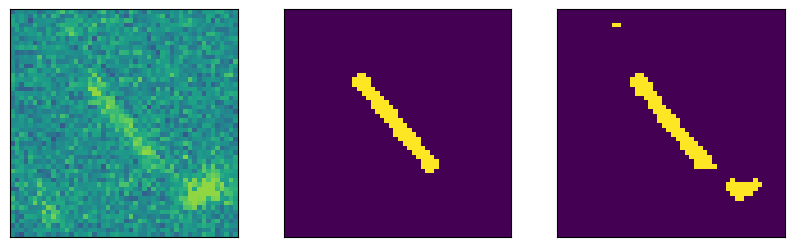

N: 17.0  x: 1453.0  y: 1114.0  mag: 23.538742663319915  trail: 25.0


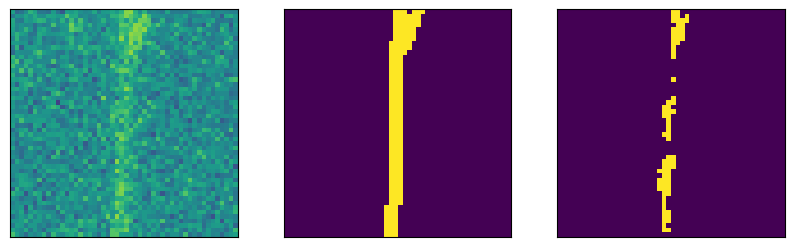

N: 17.0  x: 634.0  y: 1335.0  mag: 23.85776339396678  trail: 71.0


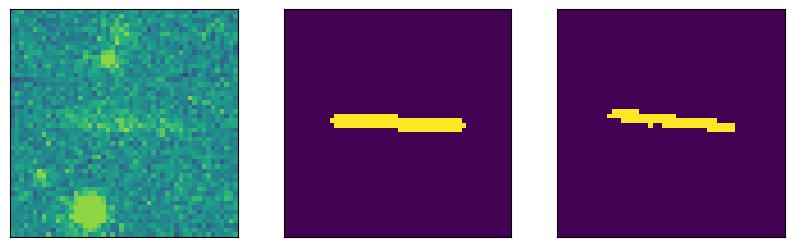

N: 17.0  x: 2913.0  y: 1750.0  mag: 23.965384538219315  trail: 27.0


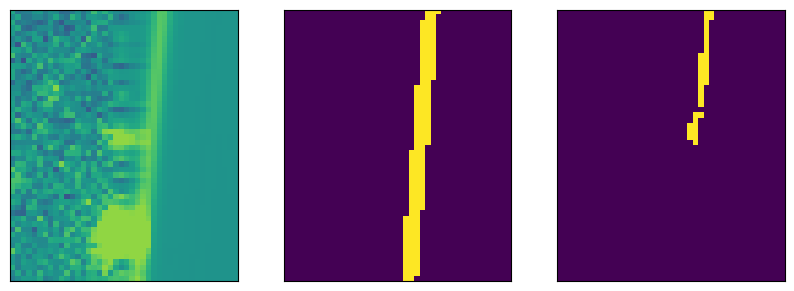

N: 17.0  x: 2173.0  y: 2031.0  mag: 23.652500880168585  trail: 60.0


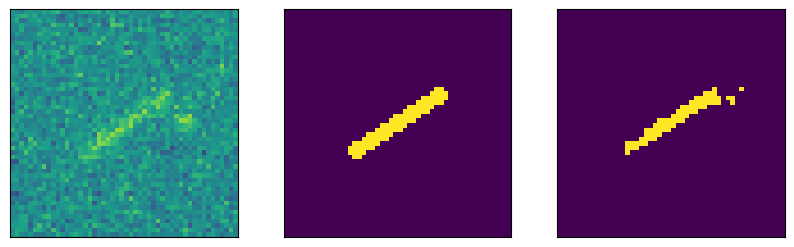

N: 17.0  x: 3942.0  y: 1441.0  mag: 23.5403125602805  trail: 23.0


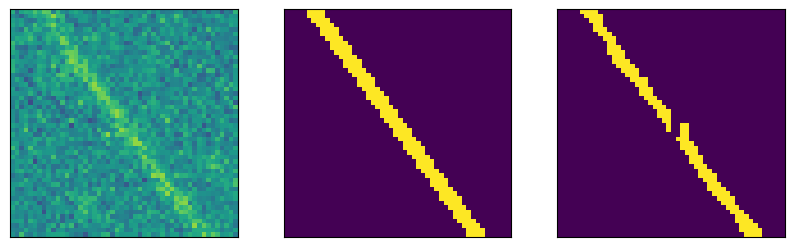

N: 17.0  x: 3939.0  y: 1663.0  mag: 23.669056352510786  trail: 68.0


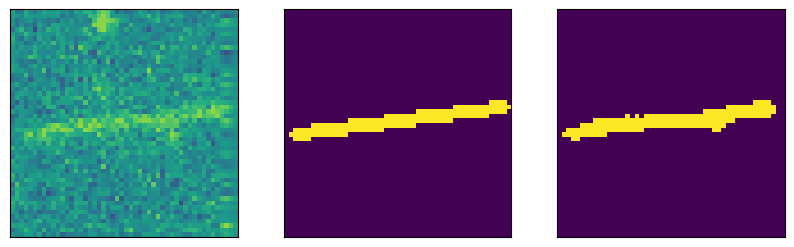

N: 17.0  x: 4072.0  y: 1975.0  mag: 23.551600366145223  trail: 46.0


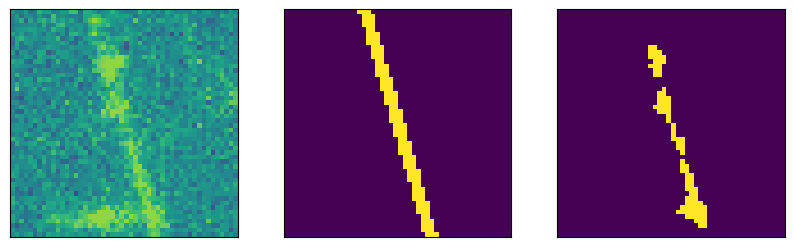

N: 17.0  x: 3612.0  y: 701.0  mag: 23.72347107695363  trail: 53.0


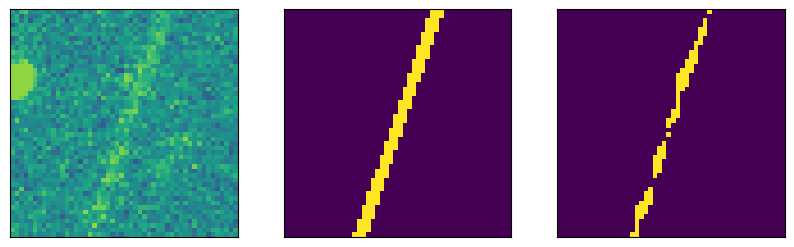

N: 17.0  x: 458.0  y: 1204.0  mag: 23.897017112991346  trail: 65.0


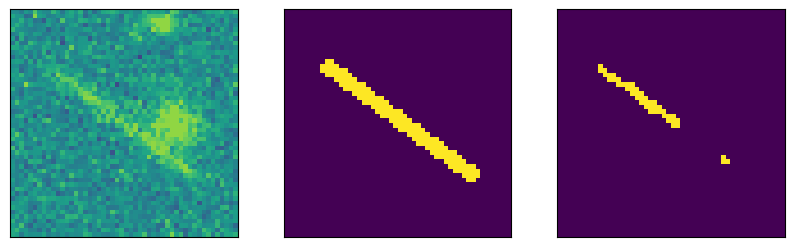

N: 17.0  x: 2750.0  y: 605.0  mag: 23.63058646388639  trail: 40.0


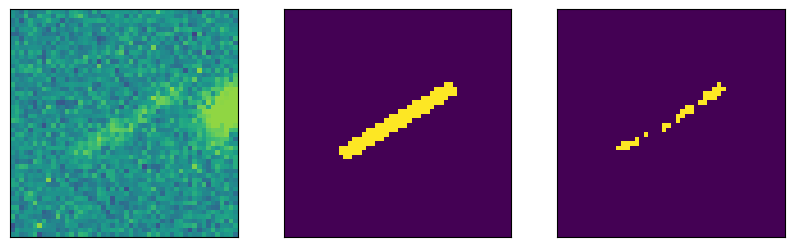

N: 17.0  x: 859.0  y: 1303.0  mag: 23.807300106467604  trail: 27.0


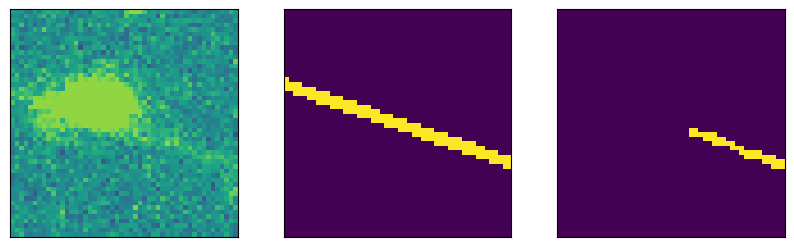

N: 17.0  x: 2639.0  y: 607.0  mag: 23.991989092074004  trail: 70.0


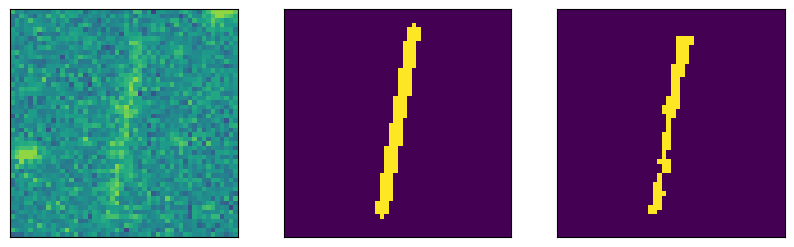

N: 17.0  x: 2111.0  y: 208.0  mag: 23.854428185656605  trail: 41.0


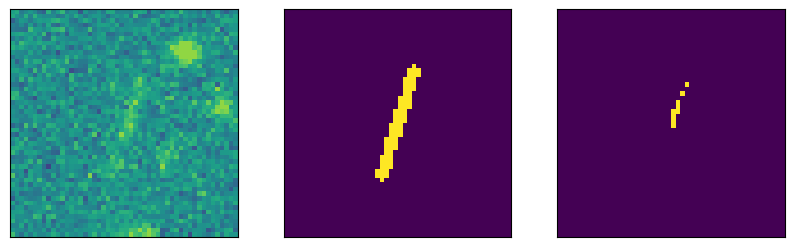

N: 17.0  x: 1890.0  y: 1067.0  mag: 23.932239233937175  trail: 24.0


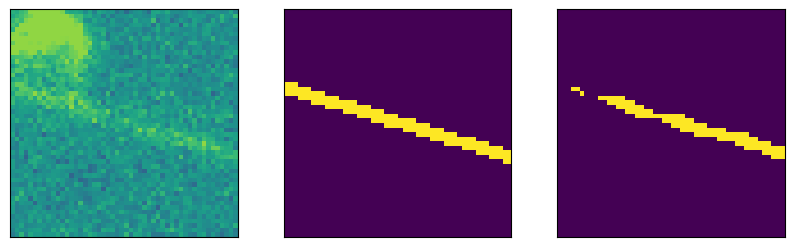

N: 18.0  x: 2465.0  y: 859.0  mag: 23.52888976773816  trail: 71.0


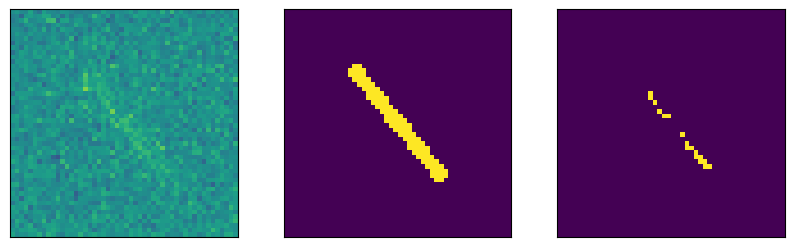

N: 18.0  x: 2652.0  y: 566.0  mag: 23.98760324074572  trail: 30.0


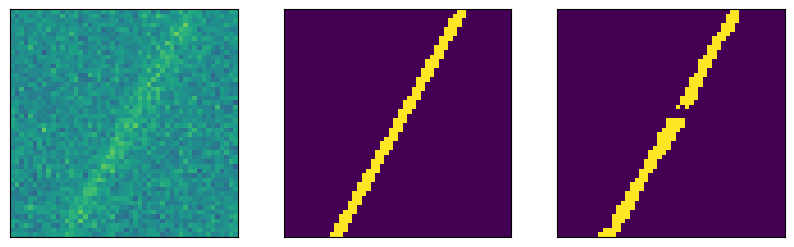

N: 18.0  x: 2562.0  y: 1631.0  mag: 23.648369541731107  trail: 60.0


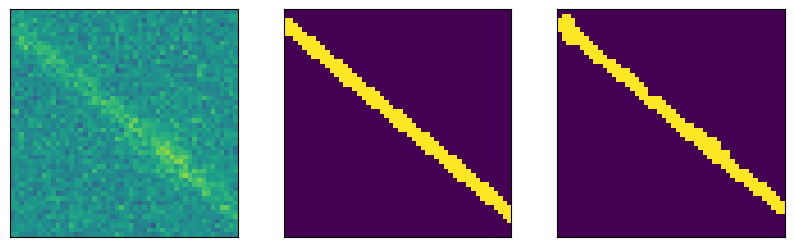

N: 18.0  x: 2739.0  y: 344.0  mag: 23.578384230634065  trail: 66.0


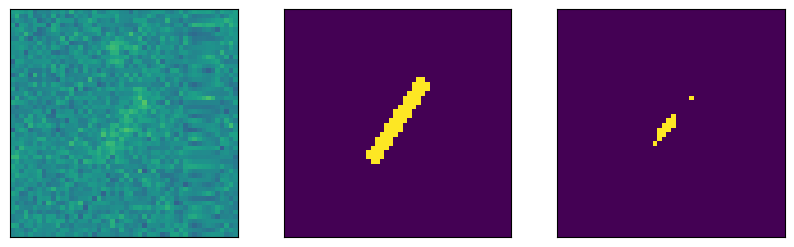

N: 18.0  x: 3284.0  y: 1007.0  mag: 23.603288474361715  trail: 19.0


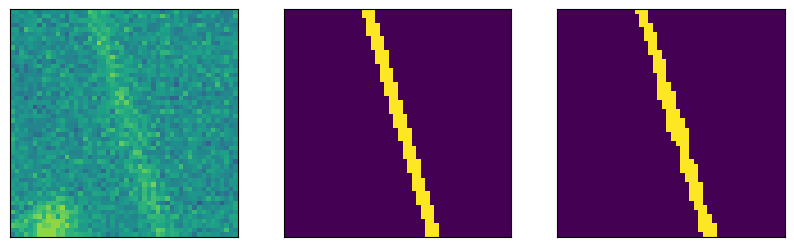

N: 18.0  x: 1086.0  y: 1716.0  mag: 23.700388557311303  trail: 70.0


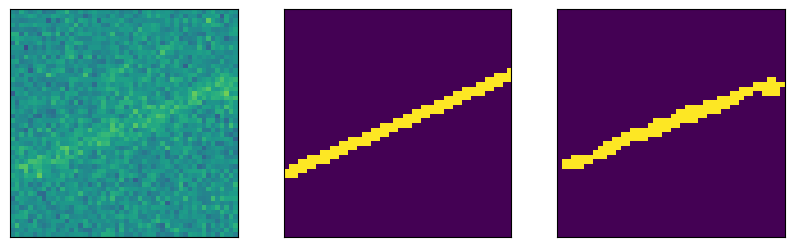

N: 18.0  x: 1169.0  y: 1727.0  mag: 23.783407734798242  trail: 54.0


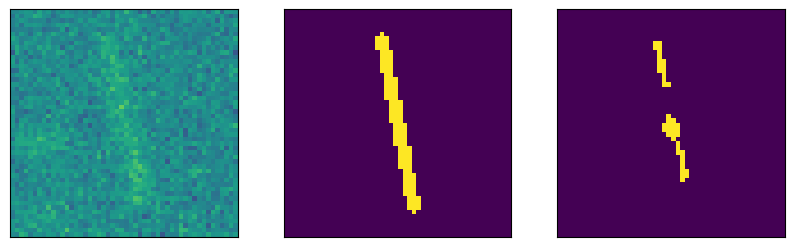

N: 18.0  x: 515.0  y: 931.0  mag: 23.58487391512232  trail: 38.0


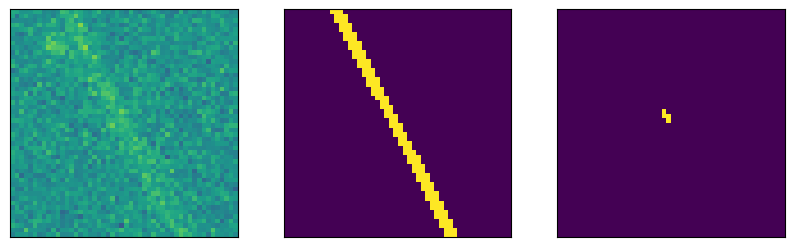

N: 18.0  x: 1278.0  y: 1893.0  mag: 23.70099604267136  trail: 70.0


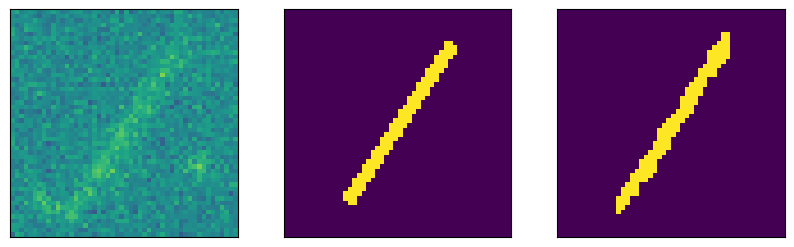

N: 18.0  x: 1608.0  y: 1293.0  mag: 23.548240674957484  trail: 40.0


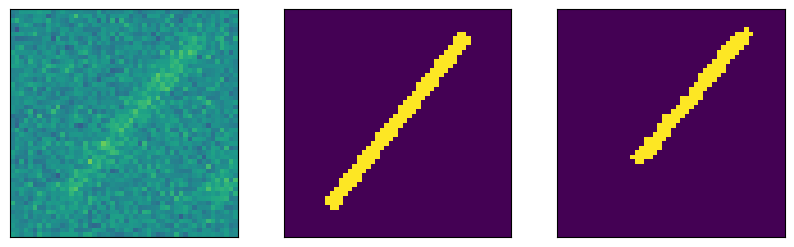

N: 18.0  x: 3318.0  y: 195.0  mag: 23.646241677347053  trail: 46.0


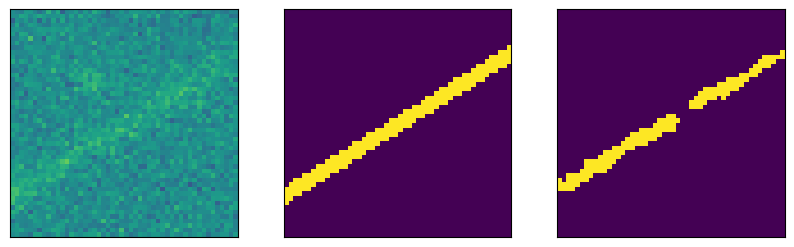

N: 18.0  x: 3091.0  y: 381.0  mag: 23.91617325982927  trail: 73.0


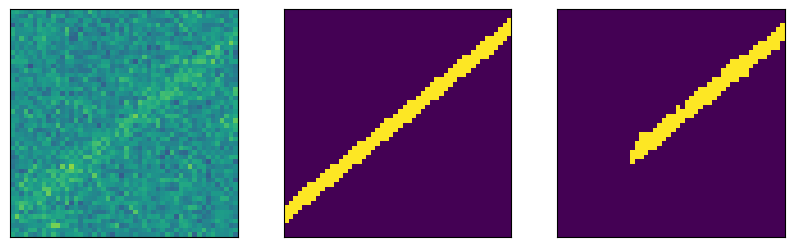

N: 23.0  x: 3398.0  y: 1418.0  mag: 23.939506148036866  trail: 66.0


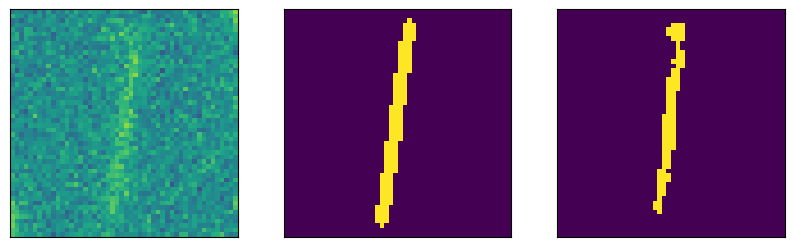

N: 23.0  x: 2909.0  y: 1236.0  mag: 23.55382517114609  trail: 43.0


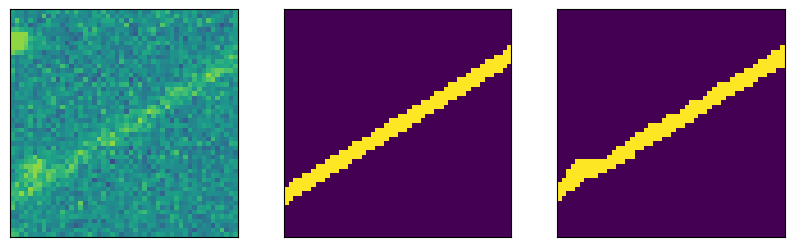

N: 23.0  x: 2248.0  y: 1344.0  mag: 23.508587219626513  trail: 65.0


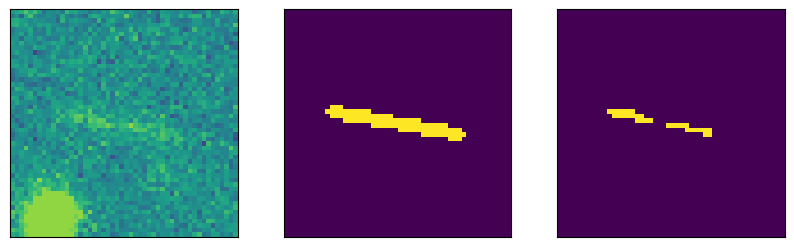

N: 23.0  x: 2602.0  y: 1769.0  mag: 23.55837923851885  trail: 28.0


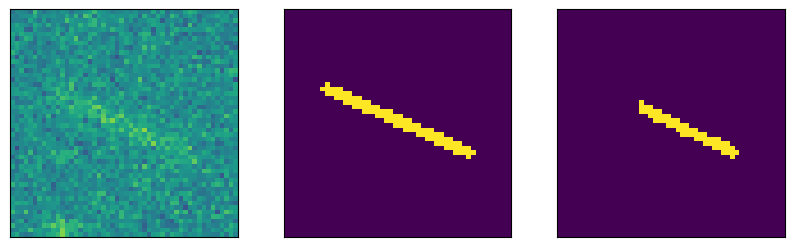

N: 23.0  x: 1980.0  y: 1929.0  mag: 23.678816663381063  trail: 34.0


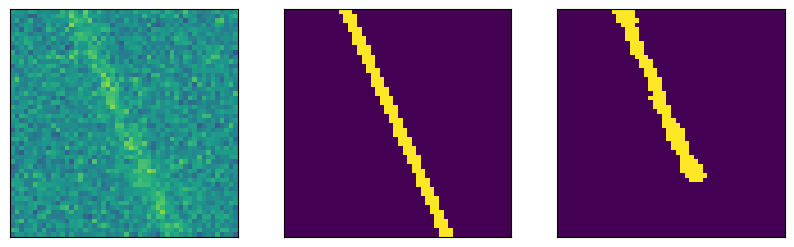

N: 23.0  x: 753.0  y: 1252.0  mag: 23.610088851726594  trail: 68.0


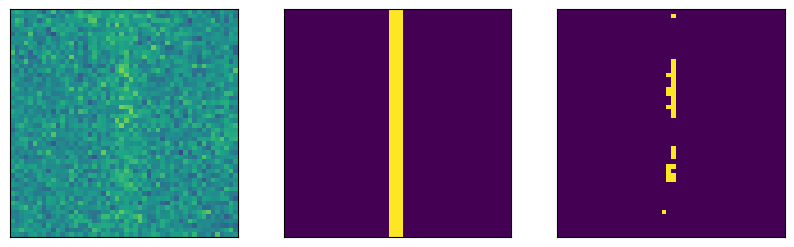

N: 23.0  x: 611.0  y: 1507.0  mag: 23.963435578943272  trail: 59.0


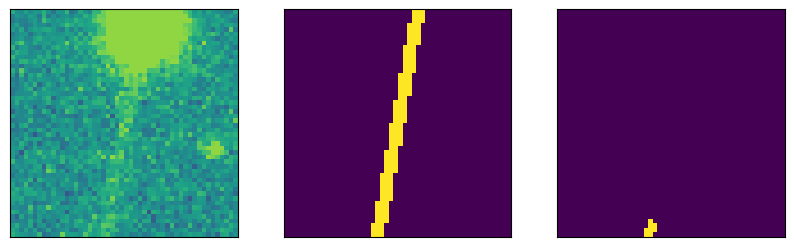

N: 23.0  x: 3112.0  y: 1985.0  mag: 23.650944140343864  trail: 63.0


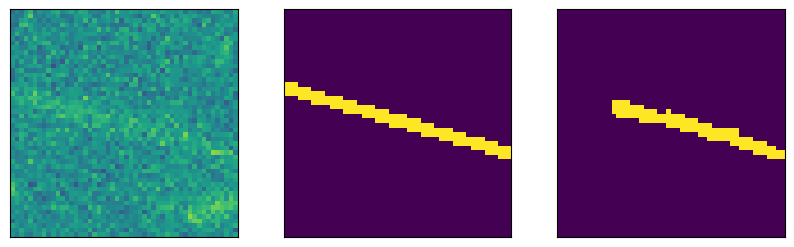

N: 23.0  x: 2445.0  y: 1678.0  mag: 23.85221413078307  trail: 57.0


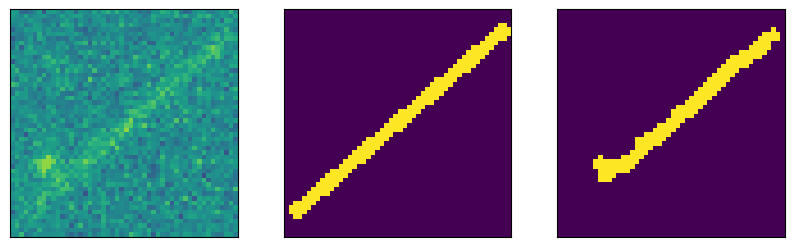

N: 23.0  x: 2584.0  y: 658.0  mag: 23.67797103183907  trail: 62.0


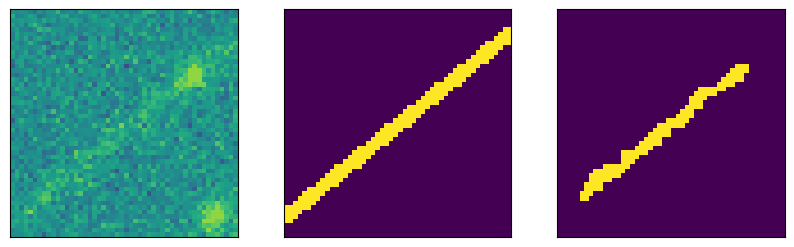

N: 23.0  x: 3311.0  y: 725.0  mag: 23.996693136141467  trail: 63.0


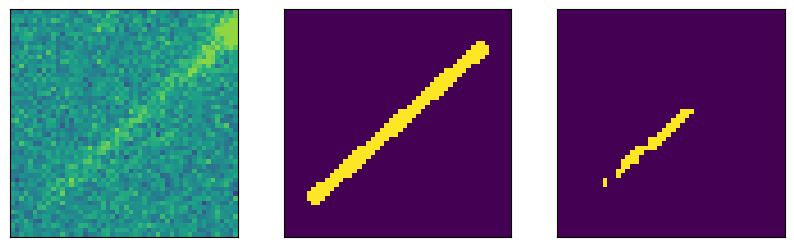

N: 23.0  x: 260.0  y: 322.0  mag: 23.777809101564173  trail: 49.0


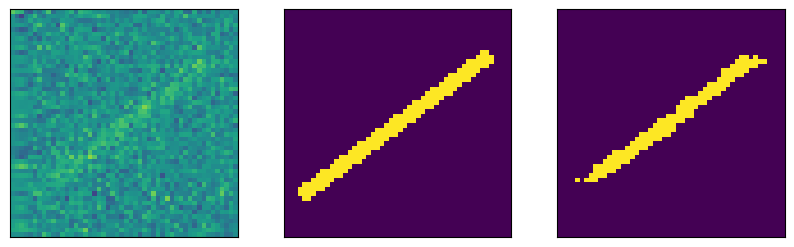

N: 23.0  x: 438.0  y: 40.0  mag: 23.93503600748799  trail: 50.0


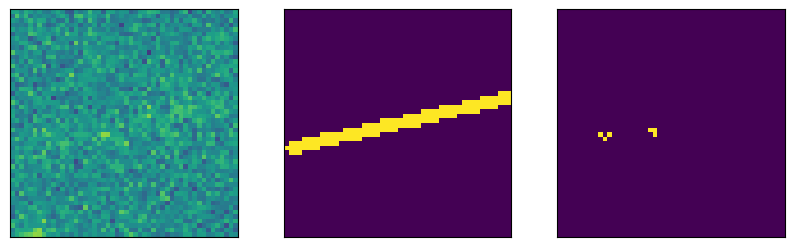

N: 25.0  x: 3303.0  y: 633.0  mag: 23.612726171568827  trail: 50.0


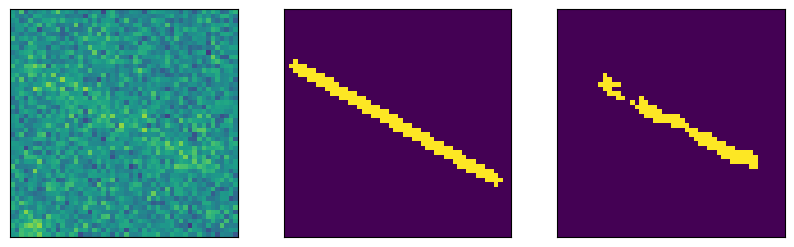

N: 25.0  x: 4057.0  y: 401.0  mag: 23.5083669691761  trail: 51.0


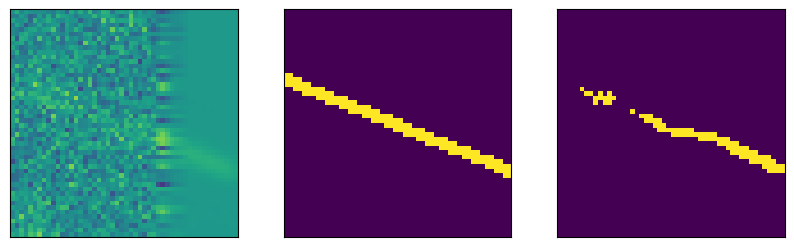

N: 25.0  x: 1056.0  y: 2018.0  mag: 23.62078641465897  trail: 53.0


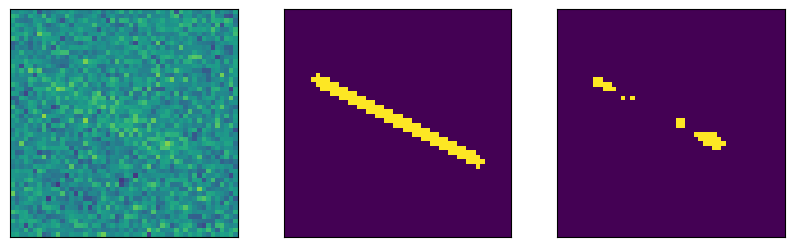

N: 25.0  x: 2588.0  y: 935.0  mag: 23.816432605823696  trail: 40.0


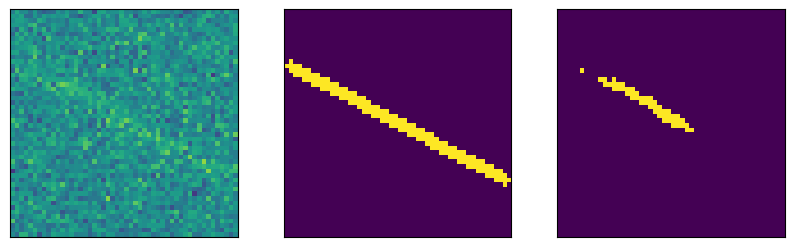

N: 25.0  x: 3068.0  y: 476.0  mag: 23.720125658360292  trail: 54.0


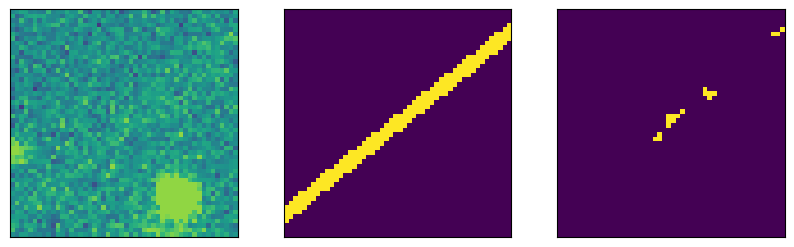

N: 25.0  x: 353.0  y: 459.0  mag: 23.800980609480245  trail: 68.0


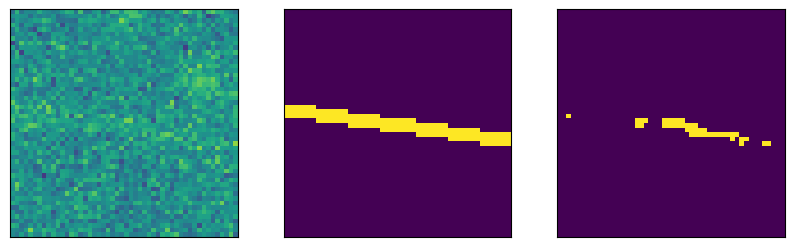

N: 25.0  x: 2888.0  y: 265.0  mag: 23.83849410489174  trail: 73.0


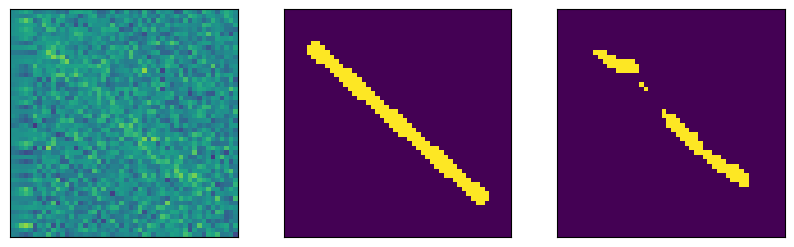

N: 25.0  x: 4114.0  y: 59.0  mag: 23.661053202781822  trail: 49.0


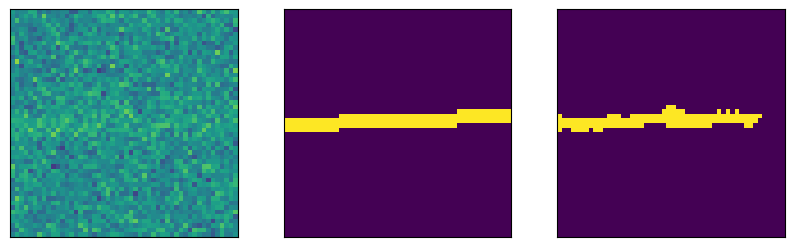

N: 26.0  x: 2102.0  y: 1082.0  mag: 23.655715877320382  trail: 53.0


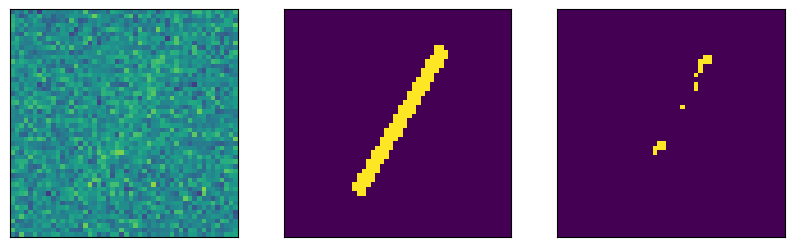

N: 26.0  x: 3116.0  y: 1361.0  mag: 23.770758417506684  trail: 35.0


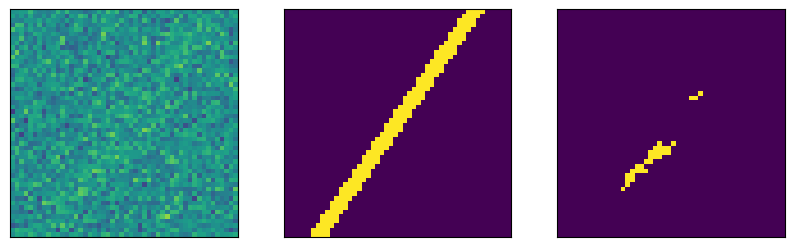

N: 26.0  x: 221.0  y: 1978.0  mag: 23.88865078359298  trail: 61.0


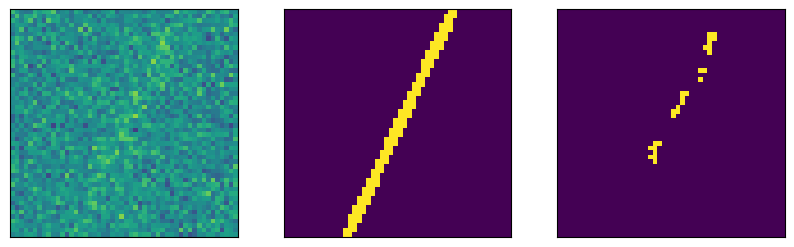

N: 26.0  x: 996.0  y: 701.0  mag: 23.84483520707804  trail: 56.0


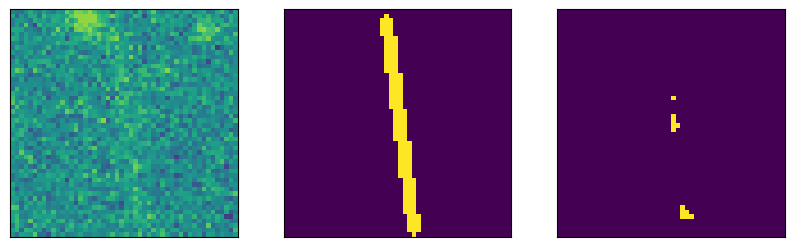

N: 26.0  x: 3516.0  y: 1379.0  mag: 23.540171476864497  trail: 47.0


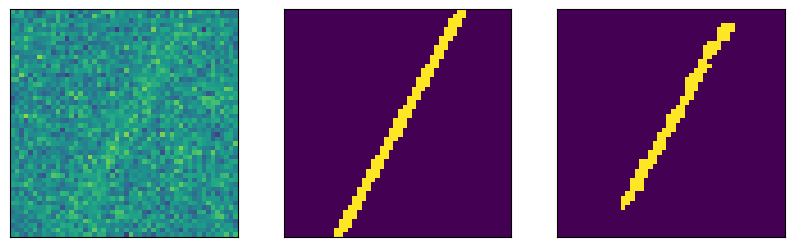

N: 26.0  x: 2714.0  y: 1614.0  mag: 23.506734645707457  trail: 58.0


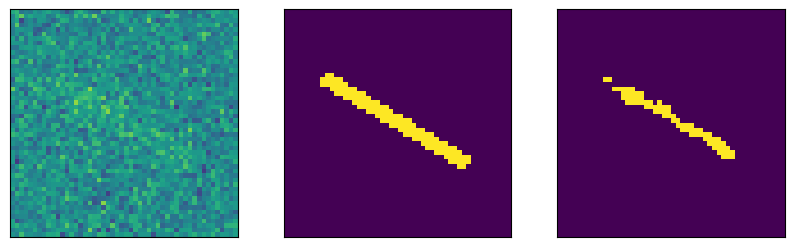

N: 26.0  x: 1592.0  y: 917.0  mag: 23.76339272284529  trail: 35.0


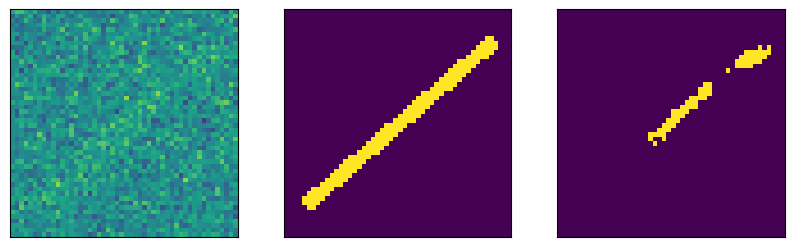

N: 26.0  x: 116.0  y: 904.0  mag: 23.783763259391275  trail: 53.0


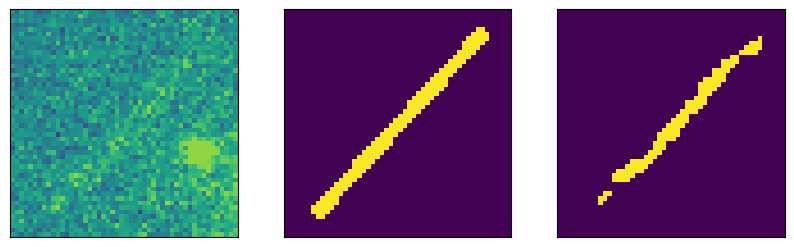

N: 26.0  x: 2402.0  y: 61.0  mag: 23.5524697250584  trail: 53.0


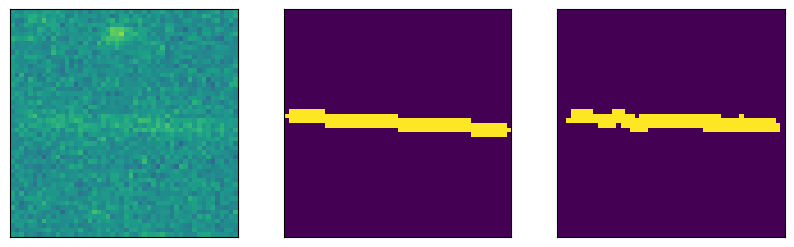

N: 27.0  x: 2169.0  y: 204.0  mag: 23.986877322602847  trail: 47.0


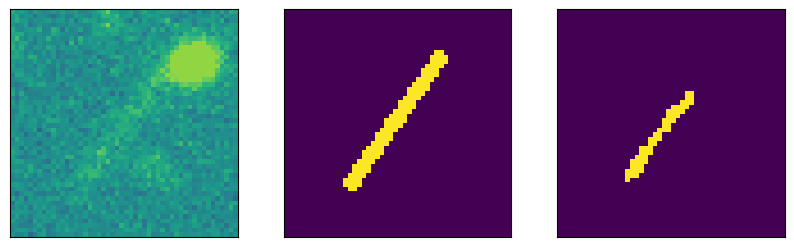

N: 27.0  x: 472.0  y: 1846.0  mag: 23.59975072739263  trail: 34.0


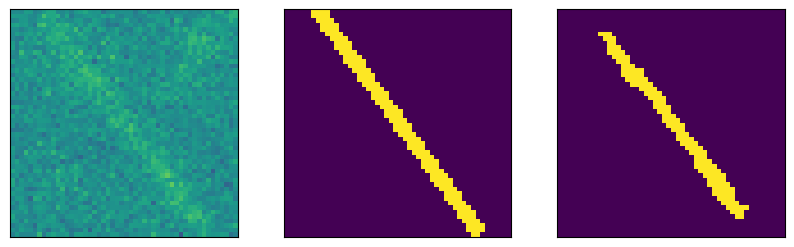

N: 27.0  x: 1996.0  y: 1263.0  mag: 23.671398573202925  trail: 59.0


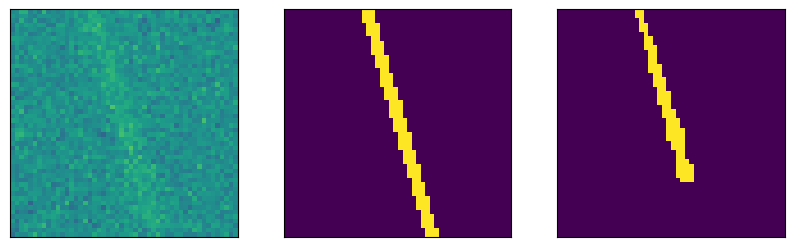

N: 27.0  x: 753.0  y: 820.0  mag: 23.83207090662645  trail: 65.0


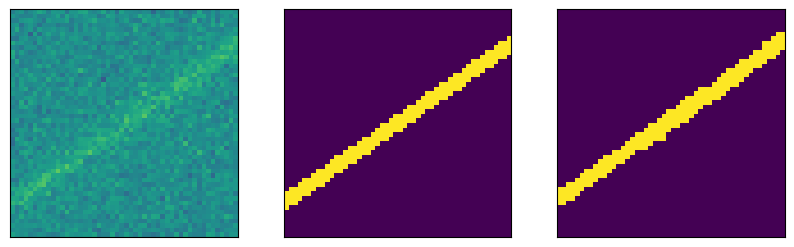

N: 27.0  x: 1442.0  y: 1493.0  mag: 23.687977918213615  trail: 65.0


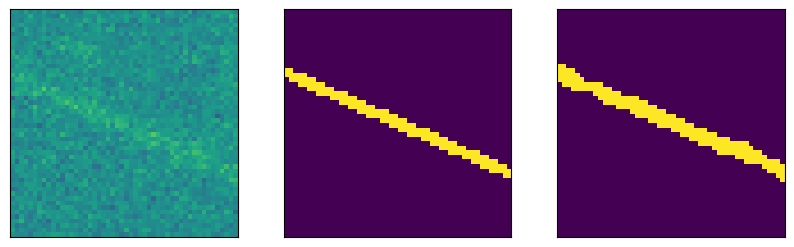

N: 27.0  x: 856.0  y: 722.0  mag: 23.87543360085529  trail: 71.0


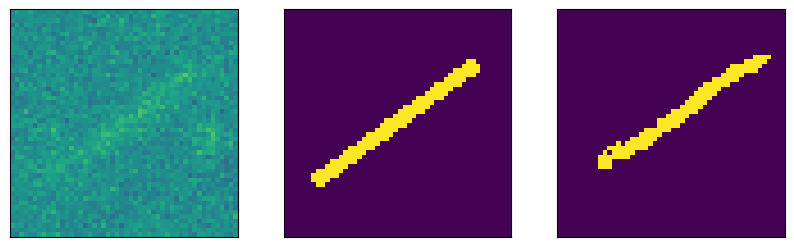

N: 27.0  x: 4031.0  y: 914.0  mag: 23.84341525584488  trail: 42.0


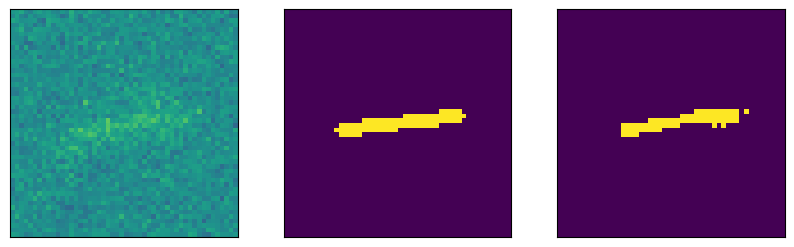

N: 27.0  x: 346.0  y: 1549.0  mag: 23.70619021614686  trail: 27.0


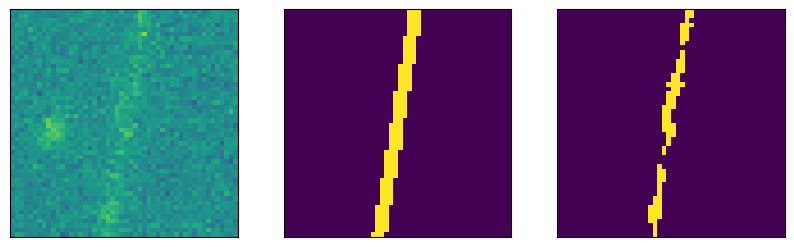

N: 27.0  x: 2232.0  y: 1187.0  mag: 23.879769063087192  trail: 69.0


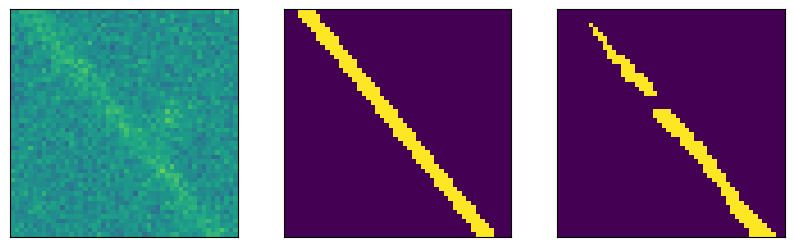

N: 27.0  x: 1924.0  y: 1081.0  mag: 23.66747754403102  trail: 73.0


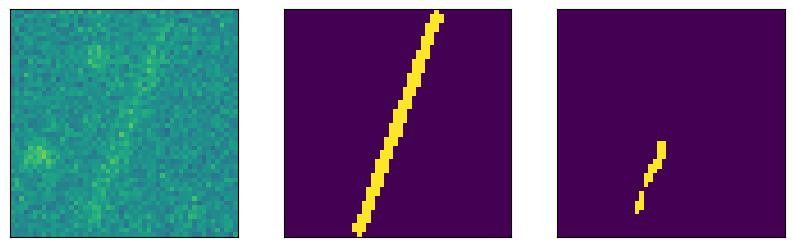

N: 27.0  x: 3002.0  y: 638.0  mag: 23.88540766674212  trail: 50.0


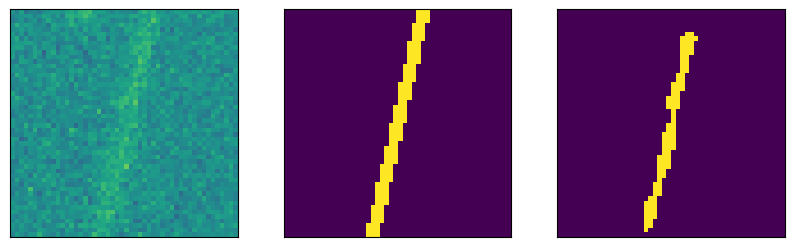

N: 27.0  x: 533.0  y: 1552.0  mag: 23.59265062425837  trail: 50.0


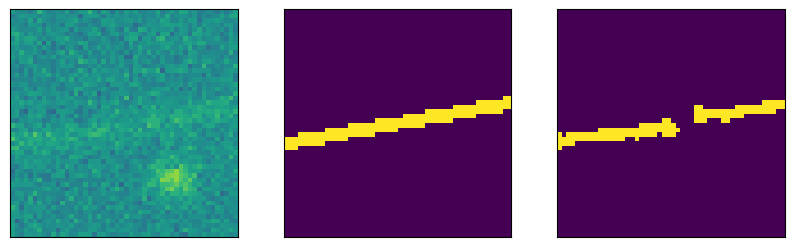

N: 27.0  x: 727.0  y: 253.0  mag: 23.958014440565805  trail: 63.0


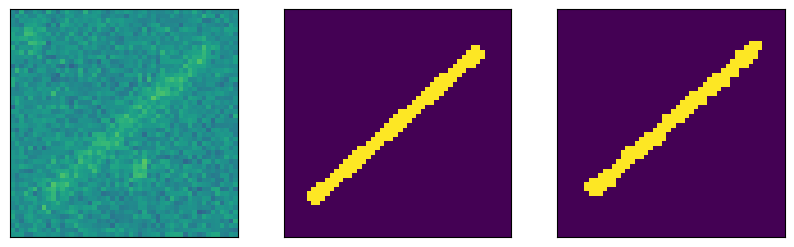

N: 27.0  x: 3862.0  y: 325.0  mag: 23.671859350615552  trail: 49.0


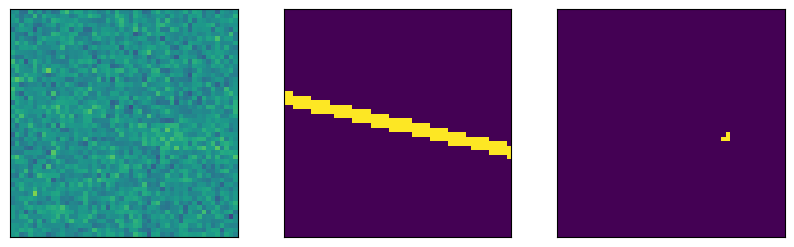

N: 28.0  x: 3665.0  y: 1160.0  mag: 23.886929079005625  trail: 62.0


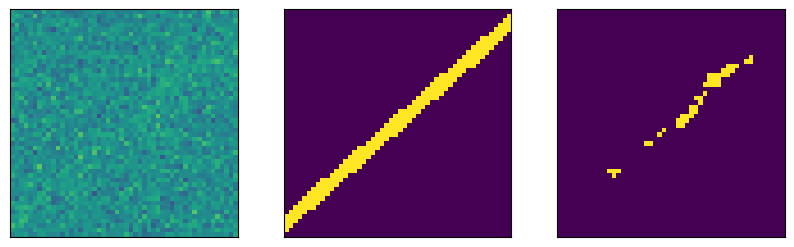

N: 28.0  x: 870.0  y: 1384.0  mag: 23.90998926425569  trail: 71.0


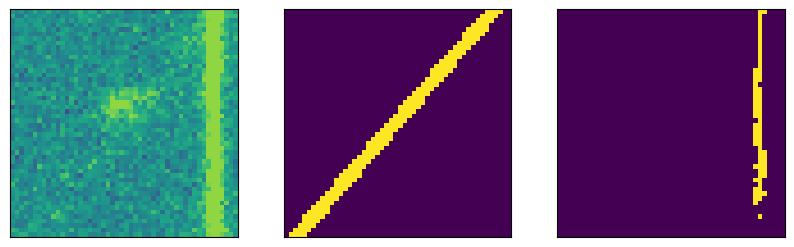

N: 28.0  x: 1006.0  y: 523.0  mag: 23.702566113124856  trail: 73.0


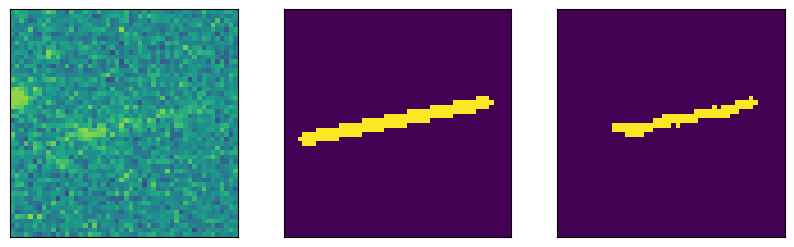

N: 29.0  x: 2551.0  y: 1111.0  mag: 23.76278516141808  trail: 41.0


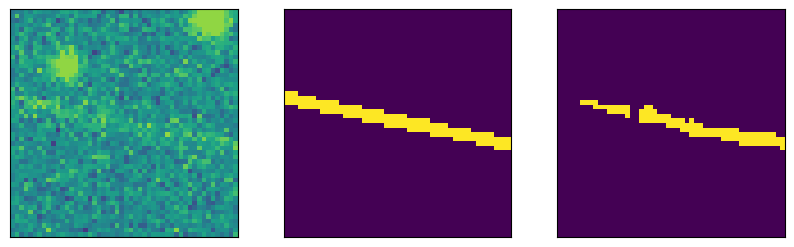

N: 29.0  x: 2840.0  y: 868.0  mag: 23.806816978908174  trail: 59.0


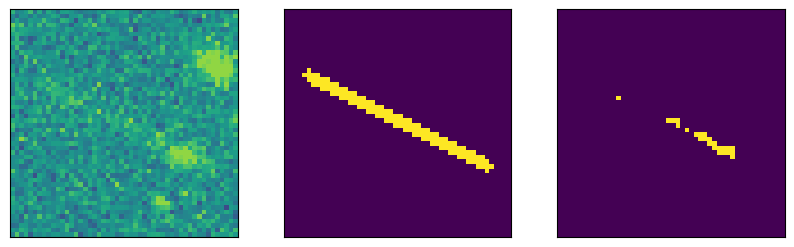

N: 29.0  x: 1013.0  y: 1237.0  mag: 23.984428575770014  trail: 44.0


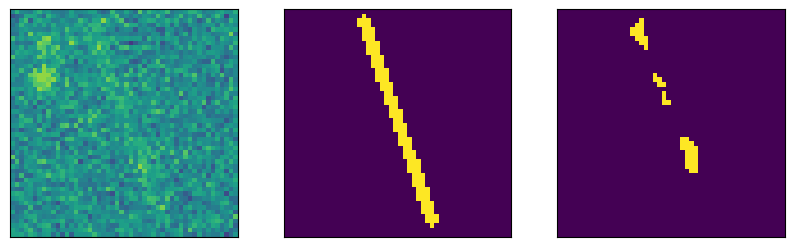

N: 29.0  x: 1340.0  y: 99.0  mag: 23.814956473801615  trail: 47.0


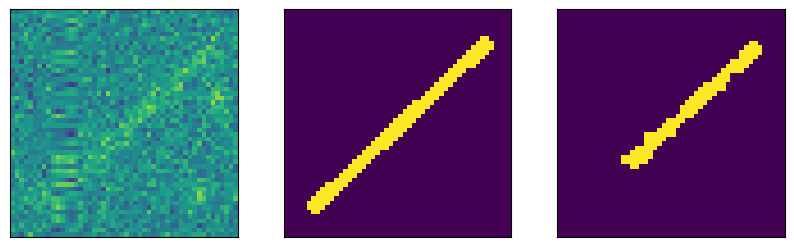

N: 29.0  x: 1097.0  y: 1037.0  mag: 23.601534320560337  trail: 52.0


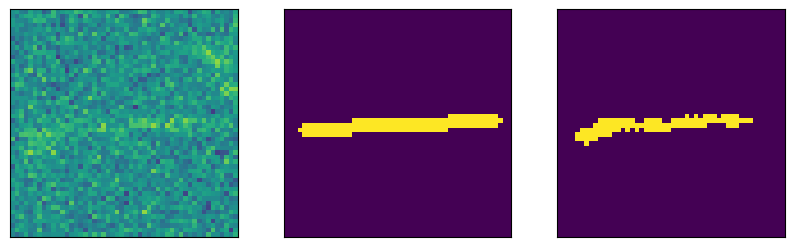

N: 29.0  x: 269.0  y: 1623.0  mag: 23.783262231026182  trail: 42.0


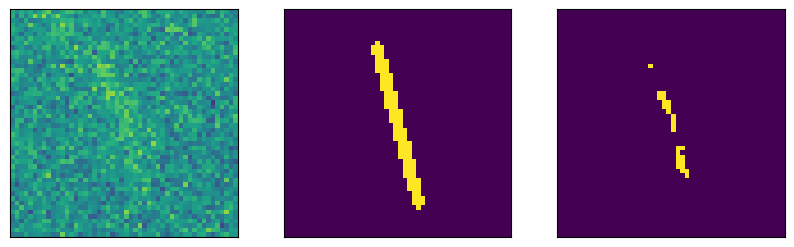

N: 29.0  x: 407.0  y: 1060.0  mag: 23.84324367016922  trail: 35.0


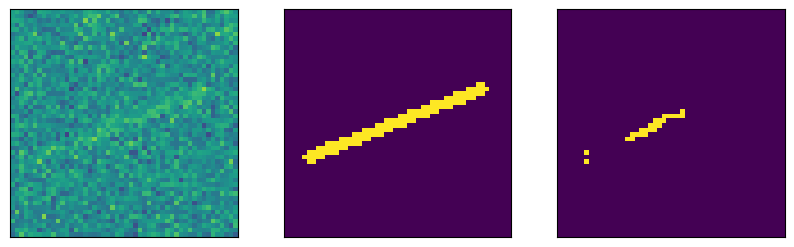

N: 29.0  x: 3122.0  y: 1146.0  mag: 23.8052752261918  trail: 41.0


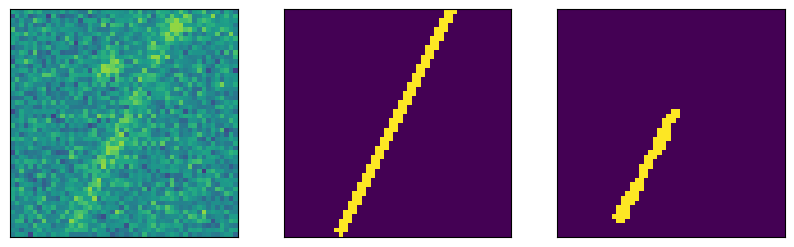

N: 29.0  x: 2822.0  y: 1722.0  mag: 23.548368915744096  trail: 53.0


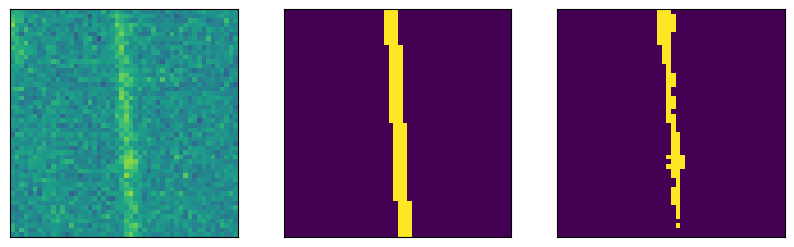

N: 31.0  x: 3488.0  y: 1518.0  mag: 23.681313762555497  trail: 51.0


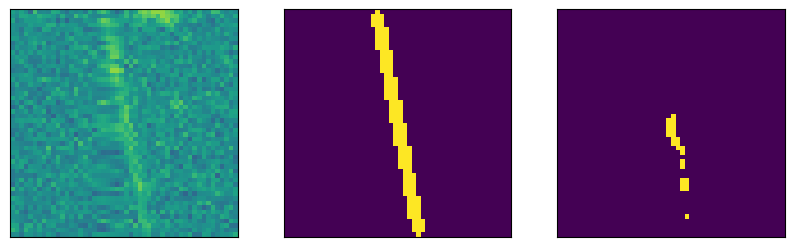

N: 31.0  x: 310.0  y: 1027.0  mag: 23.87776144861473  trail: 48.0


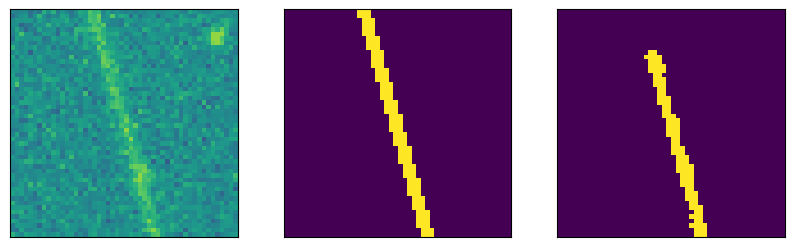

N: 31.0  x: 3985.0  y: 394.0  mag: 23.580794831619915  trail: 65.0


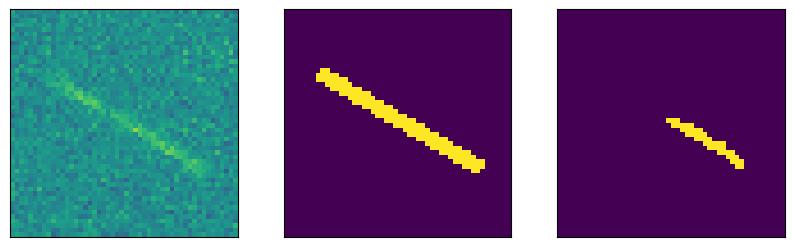

N: 31.0  x: 3714.0  y: 1263.0  mag: 23.79703071461338  trail: 39.0


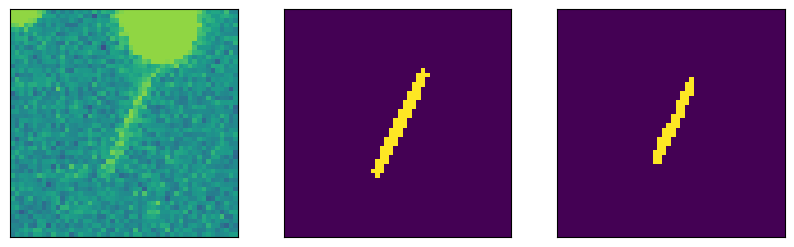

N: 31.0  x: 4001.0  y: 1176.0  mag: 23.61913499438053  trail: 24.0


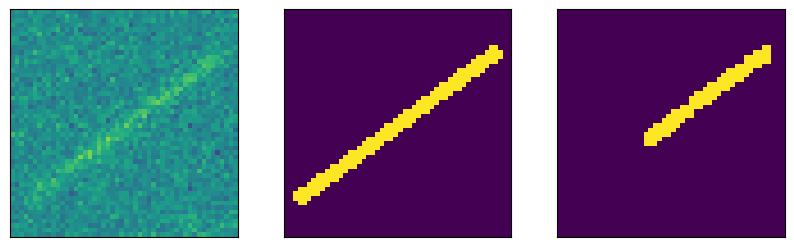

N: 31.0  x: 3061.0  y: 647.0  mag: 23.836689318058983  trail: 53.0


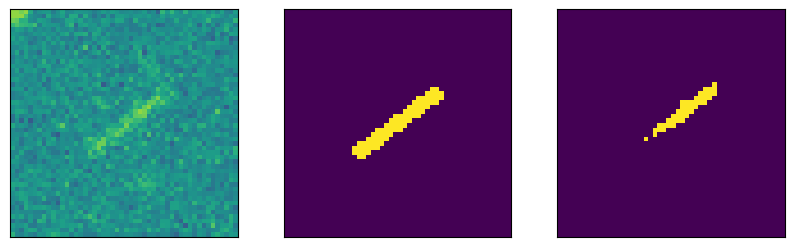

N: 31.0  x: 2886.0  y: 1366.0  mag: 23.6015885333818  trail: 21.0


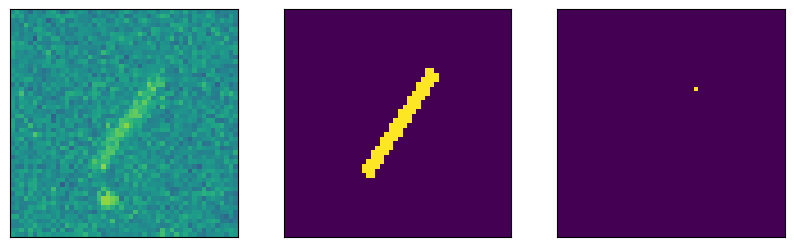

N: 31.0  x: 2697.0  y: 641.0  mag: 23.59100196790533  trail: 25.0


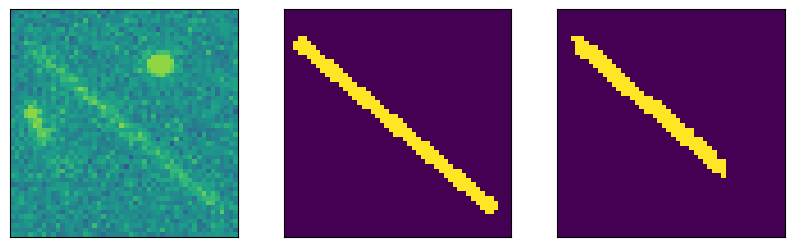

N: 31.0  x: 2991.0  y: 1395.0  mag: 23.82619251563422  trail: 55.0


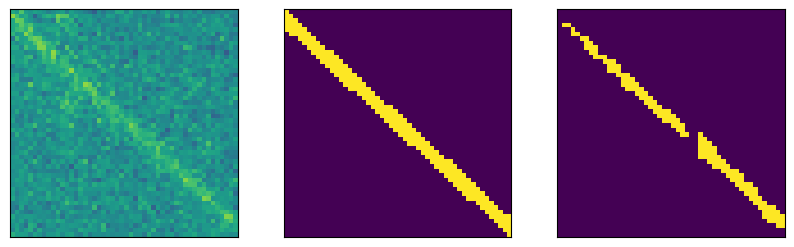

N: 31.0  x: 1616.0  y: 1915.0  mag: 23.816432143160828  trail: 71.0


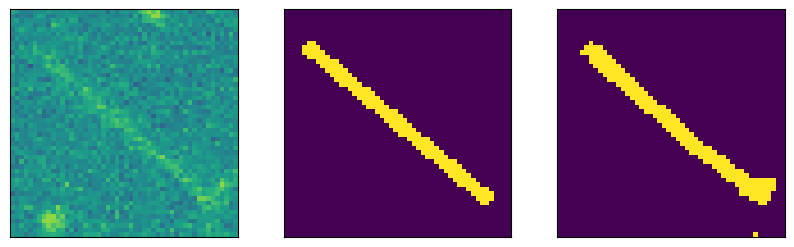

N: 31.0  x: 1244.0  y: 575.0  mag: 23.932109056143247  trail: 51.0


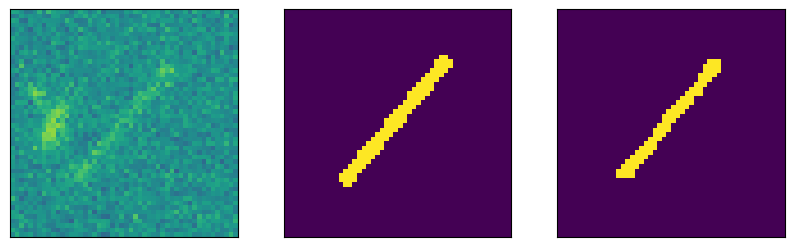

N: 31.0  x: 3912.0  y: 441.0  mag: 23.955693575570926  trail: 34.0


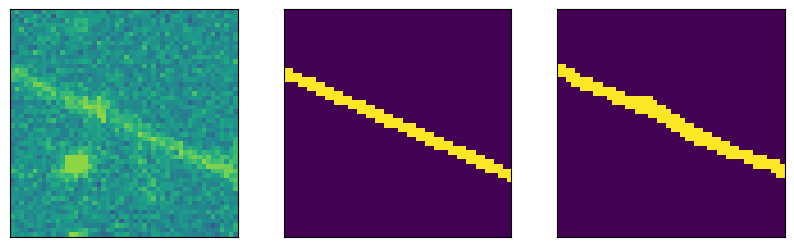

N: 32.0  x: 3639.0  y: 1736.0  mag: 23.5453897243304  trail: 73.0


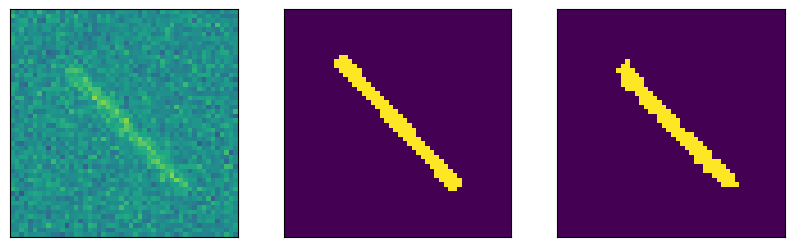

N: 32.0  x: 1774.0  y: 1932.0  mag: 23.590250337567976  trail: 37.0


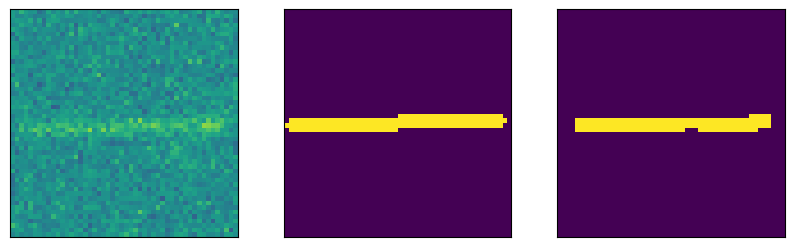

N: 32.0  x: 1258.0  y: 406.0  mag: 23.739728781176684  trail: 46.0


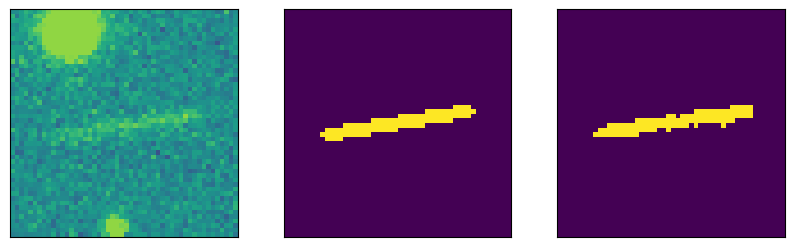

N: 32.0  x: 1078.0  y: 213.0  mag: 23.690887728107423  trail: 32.0


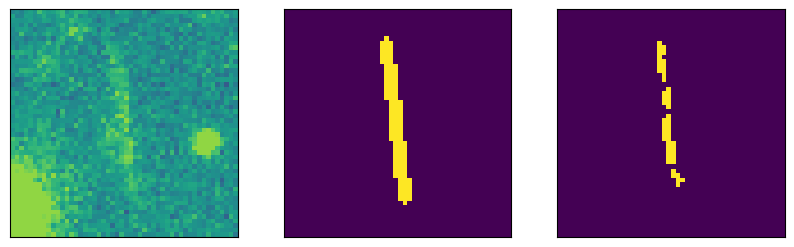

N: 32.0  x: 4024.0  y: 1166.0  mag: 23.719813697981422  trail: 34.0


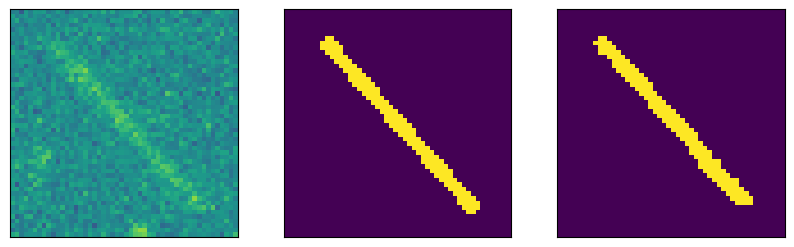

N: 32.0  x: 3692.0  y: 1214.0  mag: 23.705298703016354  trail: 49.0


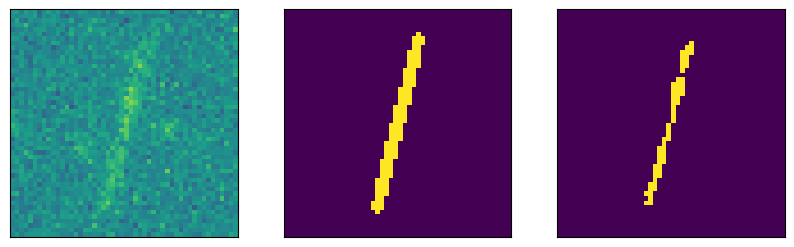

N: 32.0  x: 355.0  y: 614.0  mag: 23.838709794365034  trail: 39.0


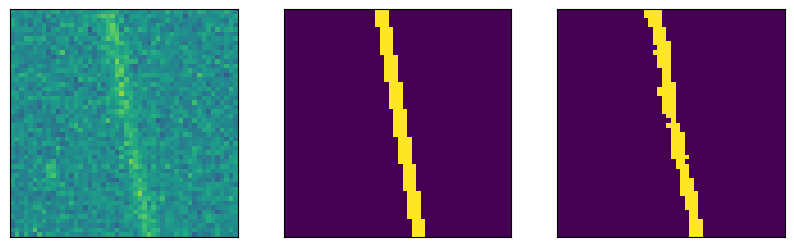

N: 32.0  x: 3396.0  y: 1701.0  mag: 23.724342818911577  trail: 62.0


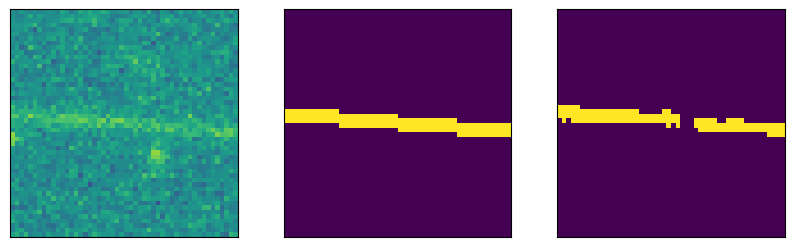

N: 32.0  x: 3479.0  y: 1149.0  mag: 23.652865948078652  trail: 63.0


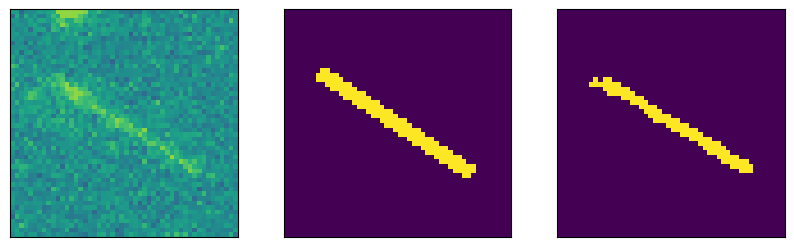

N: 32.0  x: 3401.0  y: 1619.0  mag: 23.539804070489918  trail: 38.0


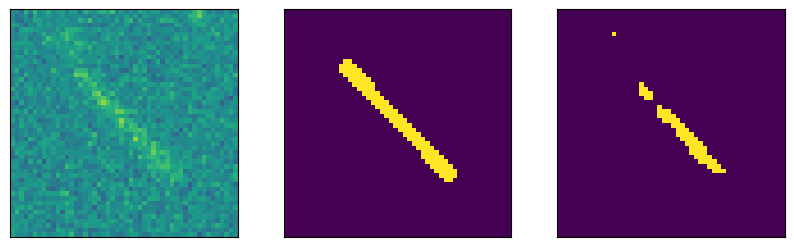

N: 32.0  x: 1924.0  y: 1439.0  mag: 23.651147856463965  trail: 34.0


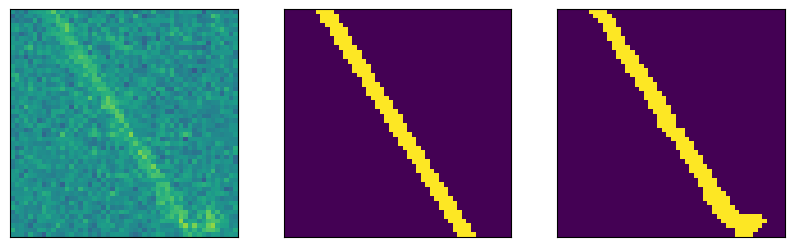

N: 32.0  x: 2373.0  y: 1891.0  mag: 23.6250982082746  trail: 68.0


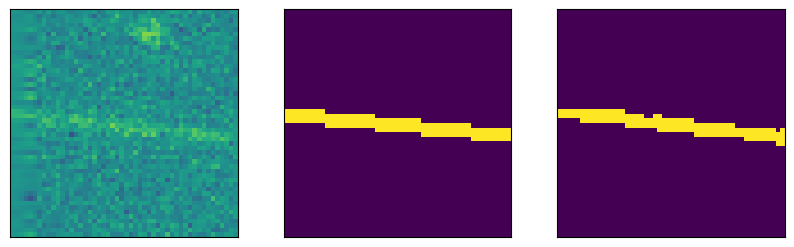

N: 32.0  x: 3318.0  y: 38.0  mag: 23.979521711112277  trail: 63.0


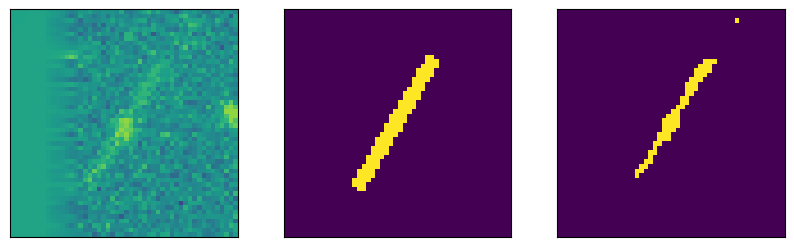

N: 32.0  x: 1825.0  y: 29.0  mag: 23.858343100563832  trail: 32.0


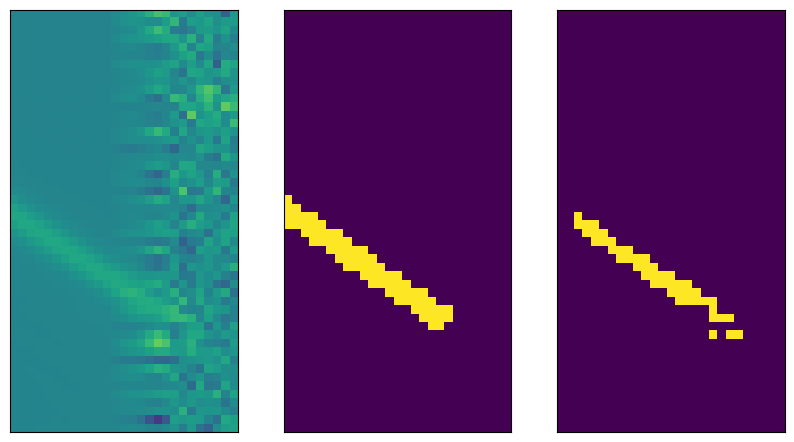

N: 32.0  x: 211.0  y: 2.0  mag: 23.918925325517407  trail: 41.0


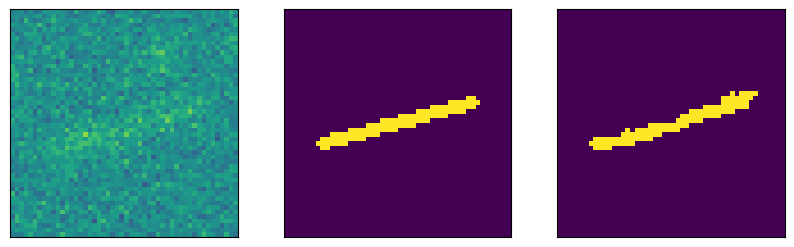

N: 36.0  x: 4071.0  y: 1335.0  mag: 23.837569181768533  trail: 35.0


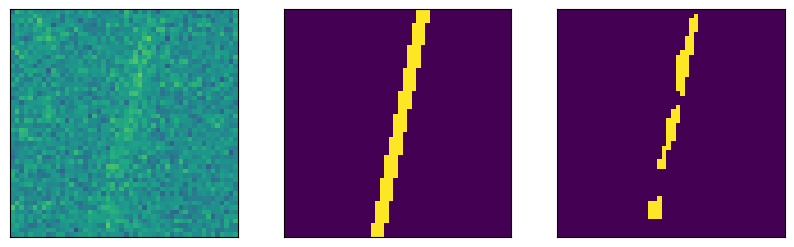

N: 36.0  x: 4040.0  y: 177.0  mag: 23.987602369903843  trail: 50.0


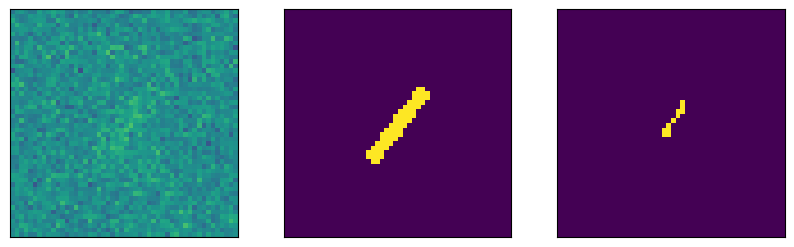

N: 36.0  x: 3832.0  y: 192.0  mag: 23.910076153357235  trail: 18.0


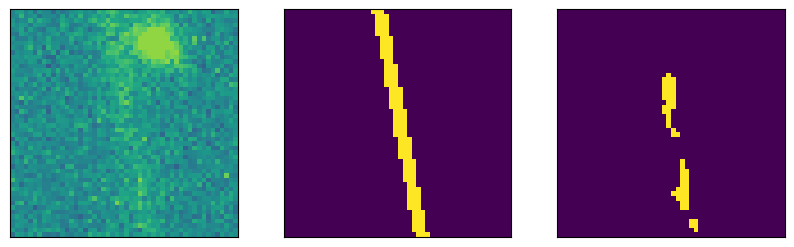

N: 36.0  x: 2624.0  y: 938.0  mag: 23.916633901301534  trail: 67.0


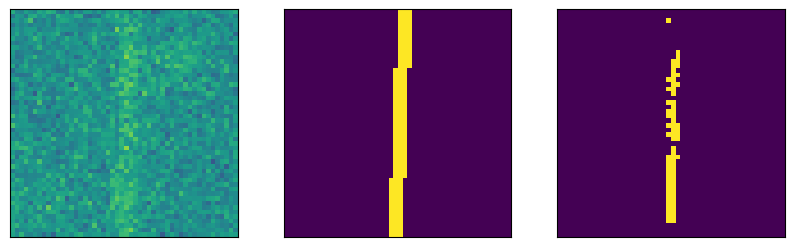

N: 36.0  x: 2987.0  y: 1880.0  mag: 23.65276694382936  trail: 49.0


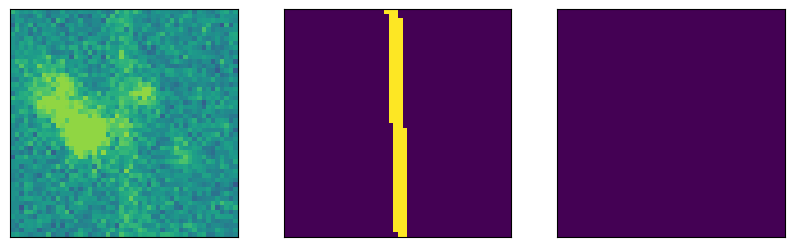

N: 36.0  x: 2662.0  y: 651.0  mag: 23.95221420990143  trail: 72.0


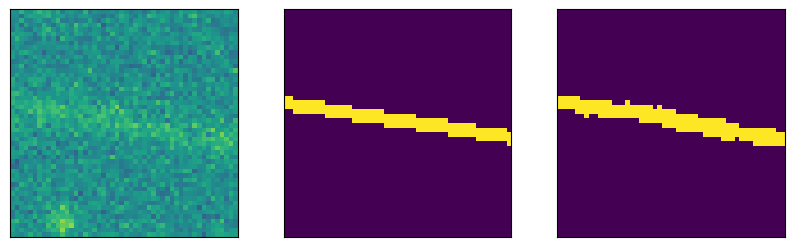

N: 36.0  x: 3296.0  y: 1972.0  mag: 23.724057595957262  trail: 54.0


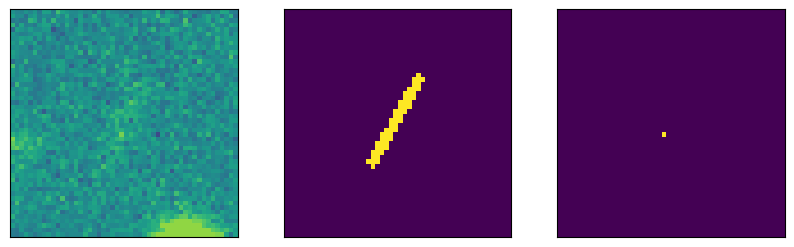

N: 36.0  x: 2675.0  y: 907.0  mag: 23.894176085632203  trail: 20.0


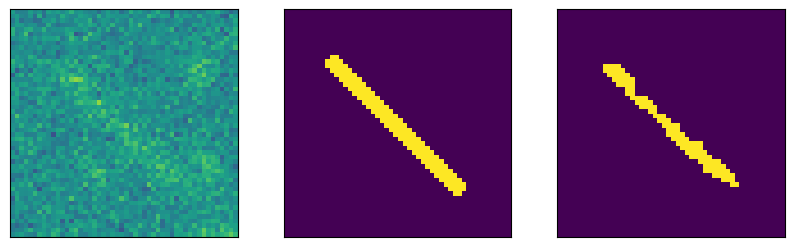

N: 36.0  x: 1842.0  y: 1578.0  mag: 23.826006430175777  trail: 40.0


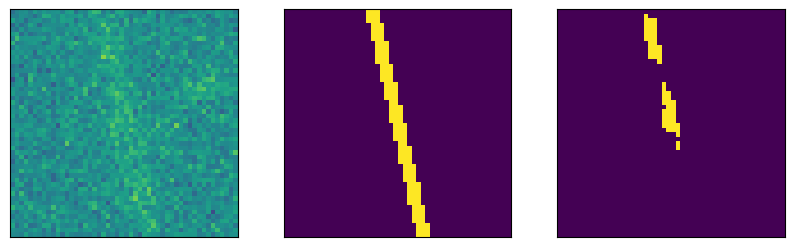

N: 36.0  x: 1952.0  y: 504.0  mag: 23.91735030031512  trail: 50.0


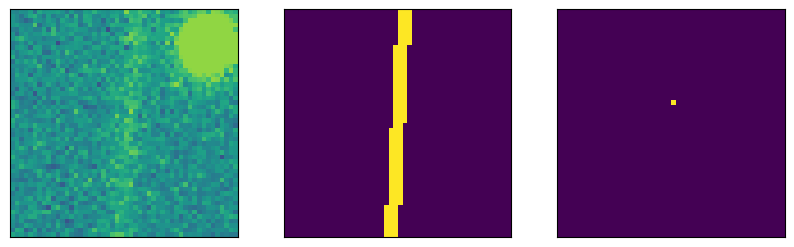

N: 36.0  x: 1788.0  y: 1541.0  mag: 23.648512073808618  trail: 52.0


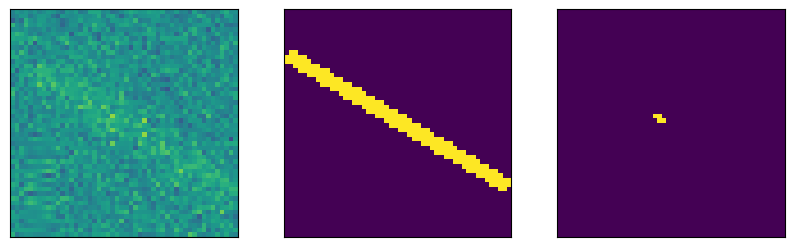

N: 36.0  x: 2024.0  y: 1524.0  mag: 23.993978478539546  trail: 54.0


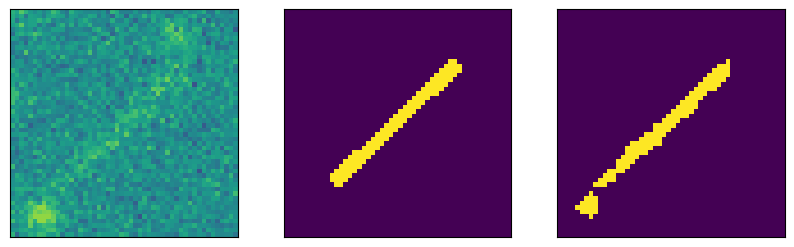

N: 36.0  x: 613.0  y: 667.0  mag: 23.813771058872366  trail: 36.0


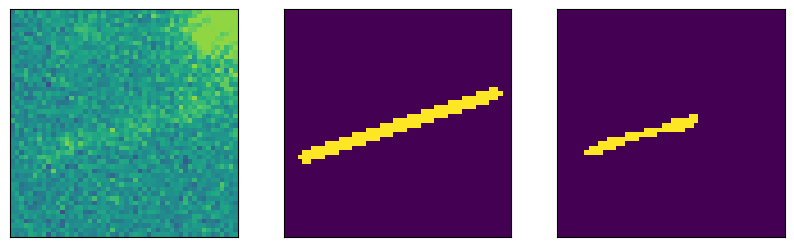

N: 36.0  x: 879.0  y: 1885.0  mag: 23.936423206326594  trail: 44.0


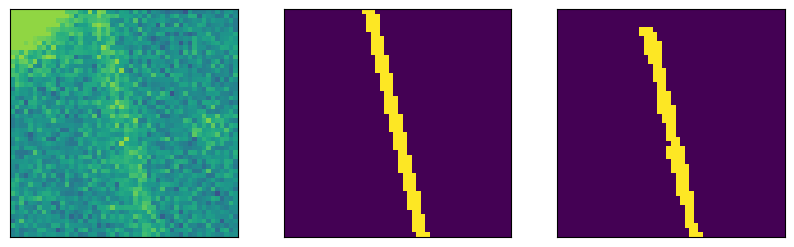

N: 36.0  x: 278.0  y: 1563.0  mag: 23.590130496334236  trail: 63.0


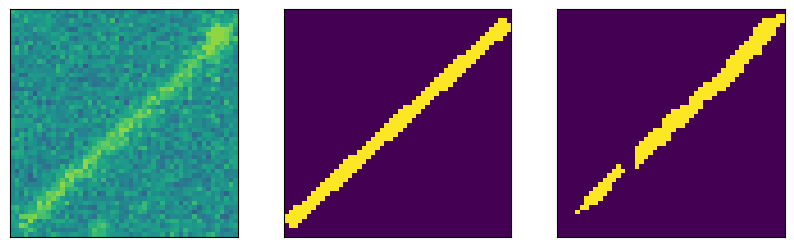

N: 37.0  x: 2987.0  y: 1161.0  mag: 23.59841146727984  trail: 64.0


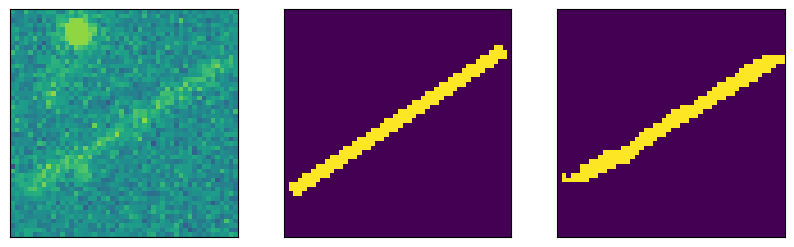

N: 37.0  x: 4069.0  y: 1629.0  mag: 23.878026327962736  trail: 54.0


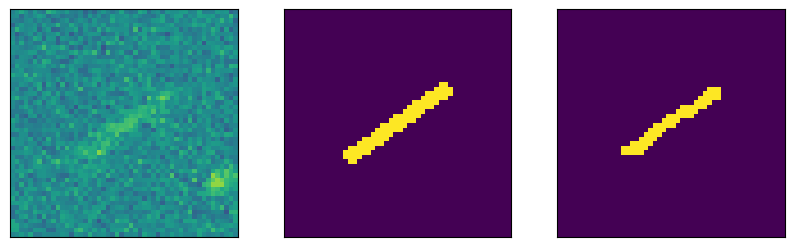

N: 37.0  x: 4013.0  y: 596.0  mag: 23.908331366976487  trail: 25.0


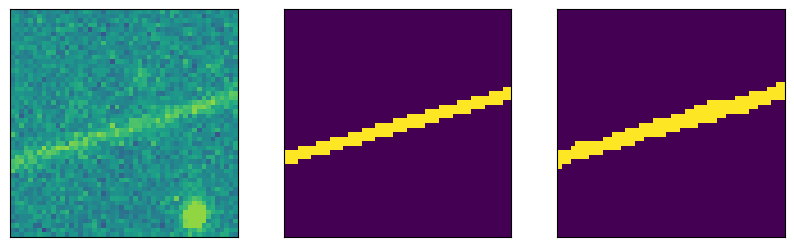

N: 37.0  x: 3298.0  y: 208.0  mag: 23.63618085128255  trail: 64.0


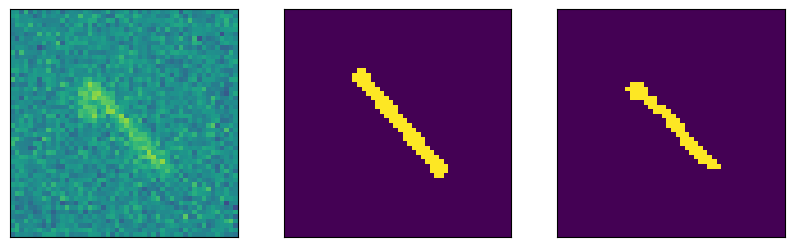

N: 37.0  x: 3651.0  y: 1980.0  mag: 23.609528310540583  trail: 28.0


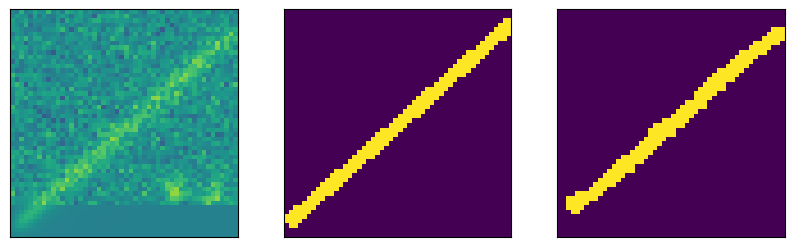

N: 37.0  x: 4137.0  y: 1180.0  mag: 23.74283031386644  trail: 65.0


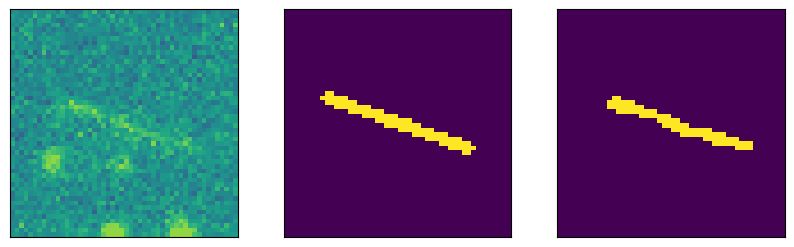

N: 37.0  x: 3178.0  y: 949.0  mag: 23.89474484966924  trail: 33.0


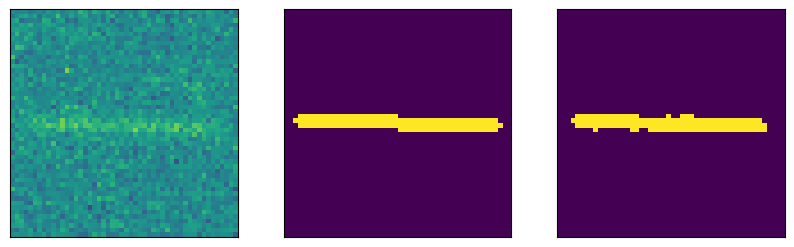

N: 37.0  x: 2257.0  y: 680.0  mag: 23.958558403894415  trail: 43.0


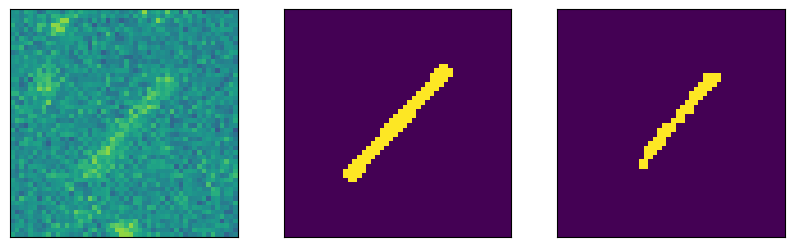

N: 37.0  x: 2368.0  y: 1928.0  mag: 23.882780507035545  trail: 31.0


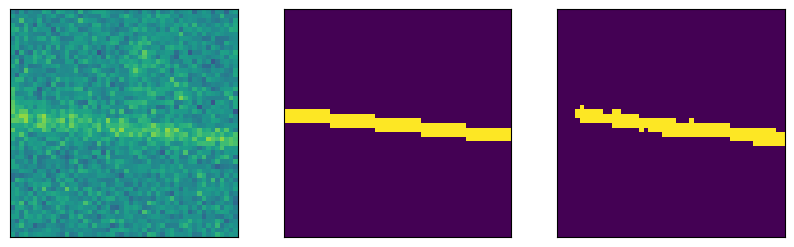

N: 37.0  x: 1710.0  y: 278.0  mag: 23.692506067579583  trail: 62.0


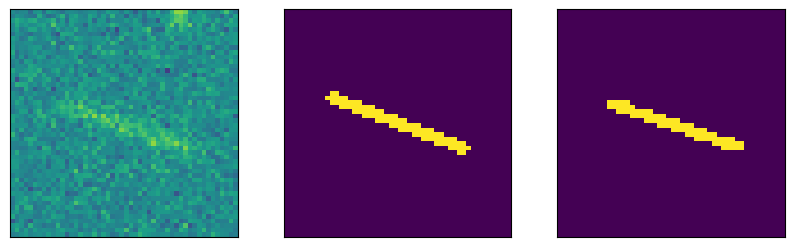

N: 37.0  x: 1476.0  y: 569.0  mag: 23.6233171710072  trail: 31.0


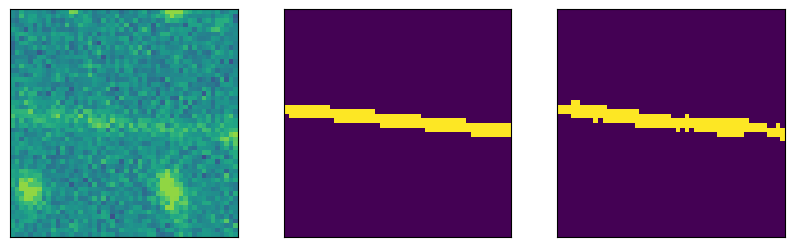

N: 37.0  x: 1184.0  y: 1054.0  mag: 23.97627749406169  trail: 60.0


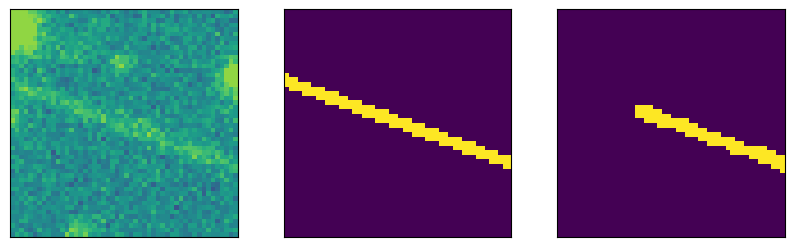

N: 37.0  x: 2712.0  y: 521.0  mag: 23.820370656297616  trail: 55.0


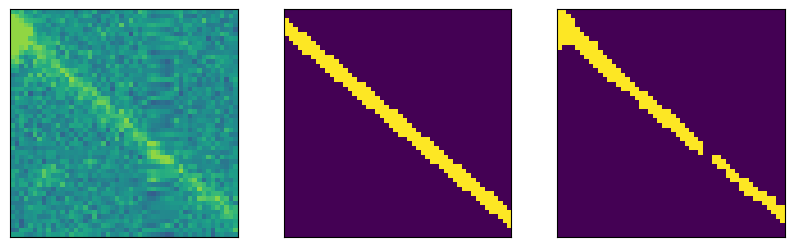

N: 37.0  x: 2020.0  y: 1016.0  mag: 23.67071843253377  trail: 72.0


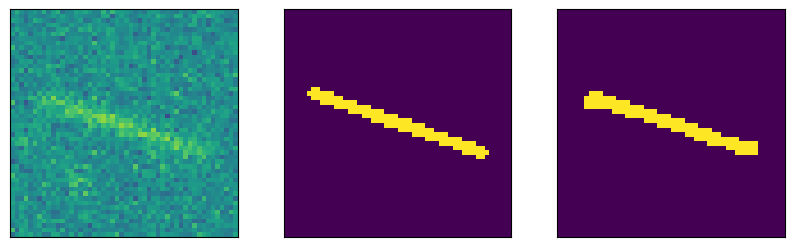

N: 37.0  x: 694.0  y: 1308.0  mag: 23.572011846353067  trail: 39.0


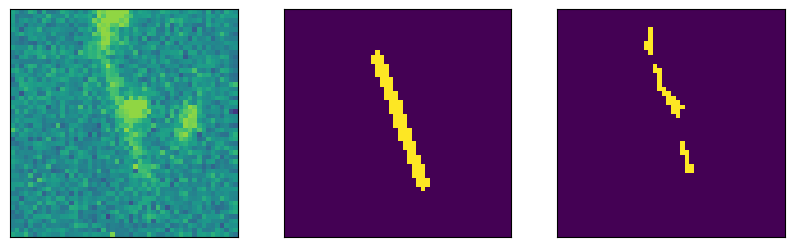

N: 37.0  x: 418.0  y: 998.0  mag: 23.8893322800939  trail: 30.0


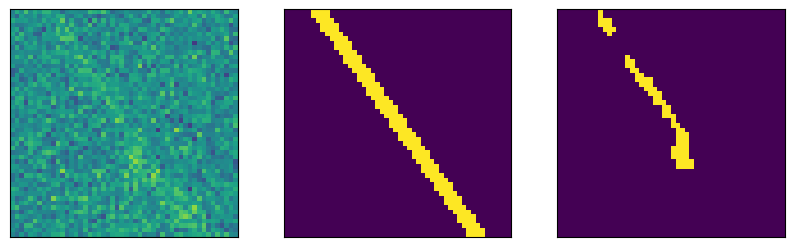

N: 38.0  x: 3828.0  y: 403.0  mag: 23.83036620083924  trail: 67.0


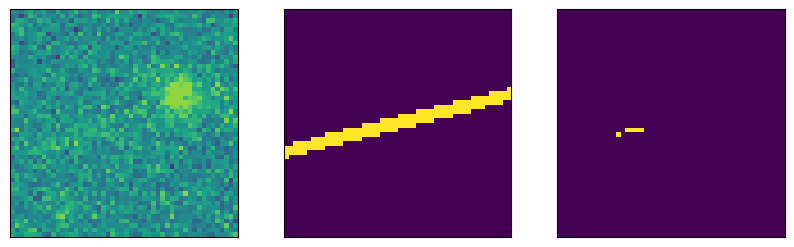

N: 38.0  x: 3873.0  y: 192.0  mag: 23.816466270654637  trail: 52.0


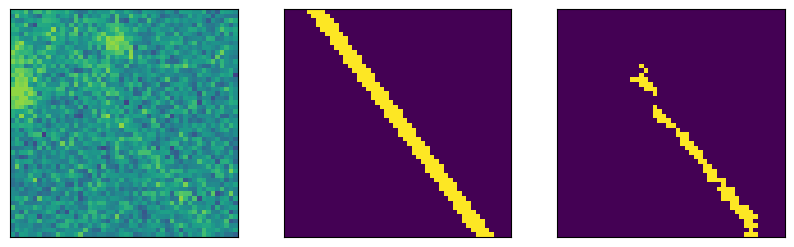

N: 38.0  x: 1824.0  y: 949.0  mag: 23.93641255037762  trail: 73.0


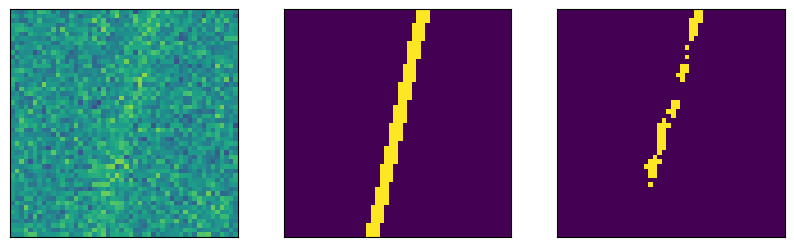

N: 38.0  x: 3055.0  y: 1293.0  mag: 23.512274181482358  trail: 69.0


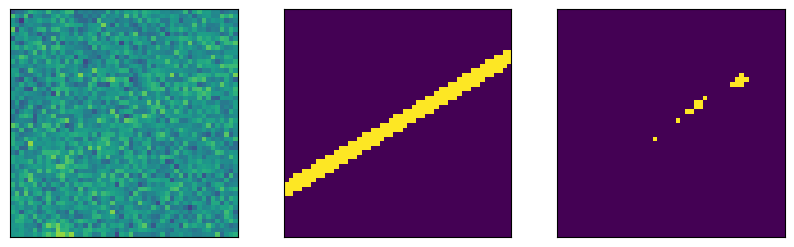

N: 38.0  x: 3004.0  y: 1968.0  mag: 23.932037966244508  trail: 69.0


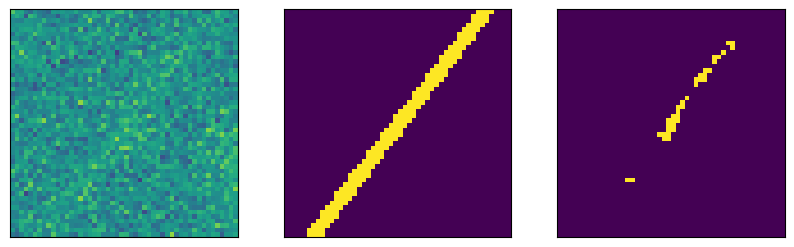

N: 38.0  x: 1530.0  y: 1469.0  mag: 23.987454646509995  trail: 70.0


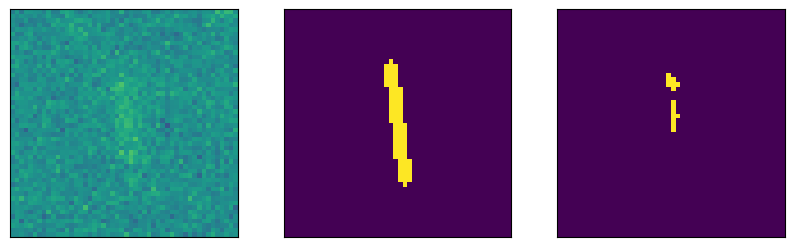

N: 39.0  x: 3700.0  y: 1689.0  mag: 23.695260742552307  trail: 25.0


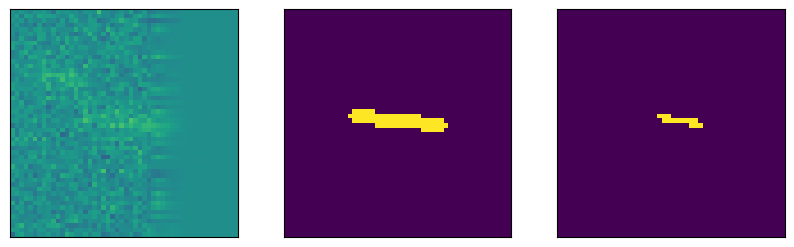

N: 39.0  x: 655.0  y: 2019.0  mag: 23.700355194156757  trail: 19.0


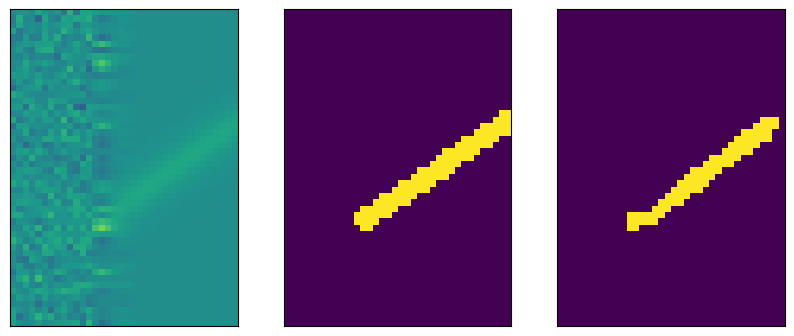

N: 39.0  x: 2842.0  y: 2037.0  mag: 23.91647506060736  trail: 31.0


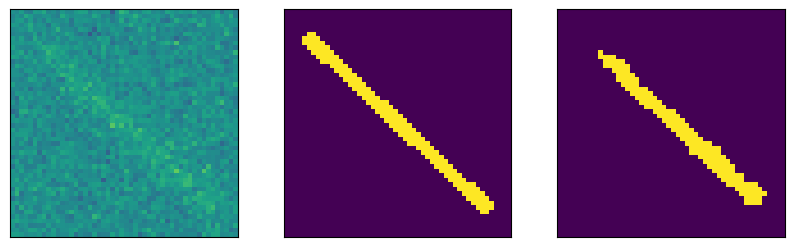

N: 39.0  x: 3985.0  y: 1641.0  mag: 23.956598161165726  trail: 54.0


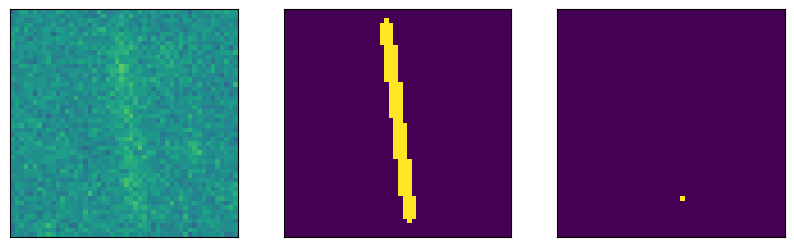

N: 39.0  x: 2956.0  y: 1665.0  mag: 23.636359561857166  trail: 42.0


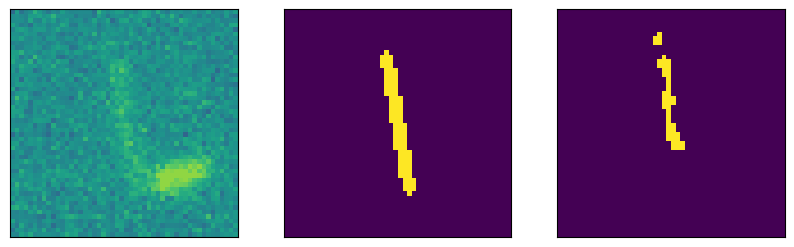

N: 39.0  x: 2168.0  y: 218.0  mag: 23.70363790105904  trail: 29.0


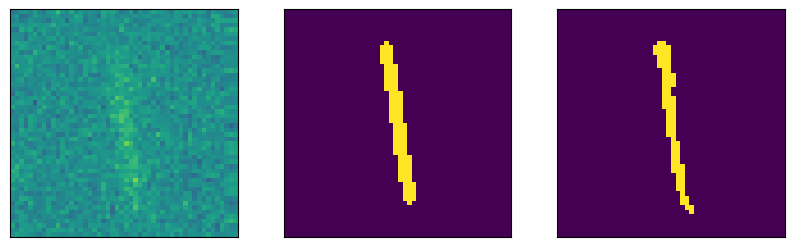

N: 39.0  x: 829.0  y: 816.0  mag: 23.60324482192538  trail: 34.0


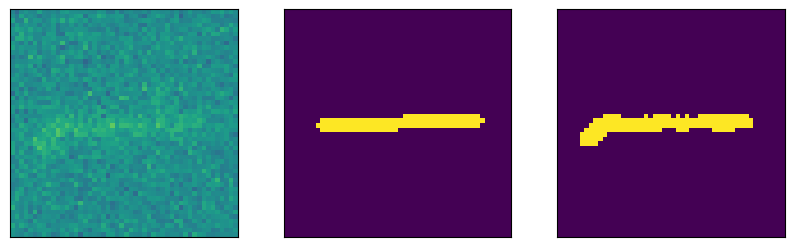

N: 39.0  x: 1893.0  y: 609.0  mag: 23.718024056704238  trail: 34.0


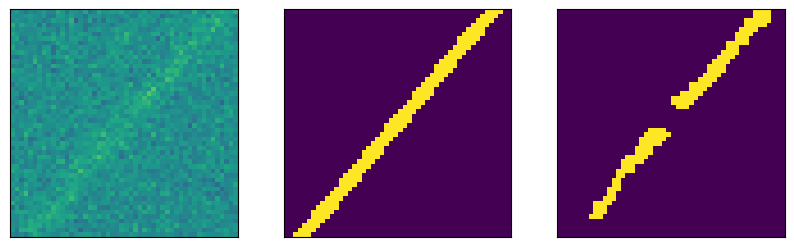

N: 39.0  x: 3201.0  y: 1299.0  mag: 23.96354322481042  trail: 67.0


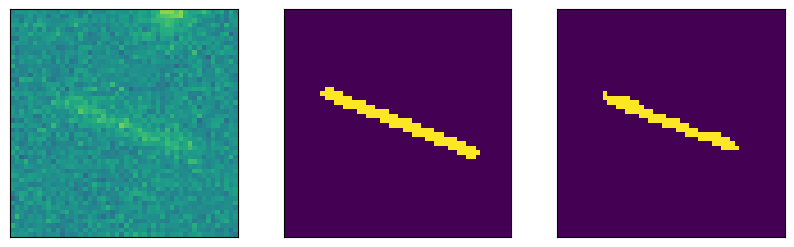

N: 39.0  x: 3785.0  y: 854.0  mag: 23.56128362218698  trail: 34.0


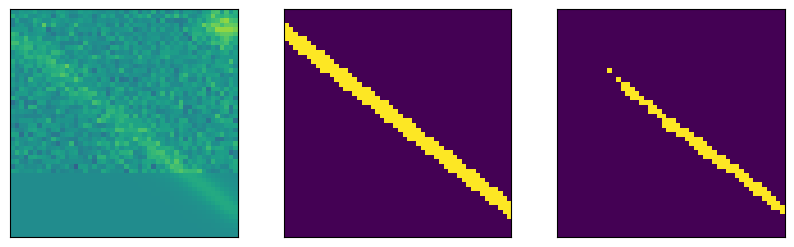

N: 39.0  x: 4144.0  y: 1467.0  mag: 23.627841207102506  trail: 65.0


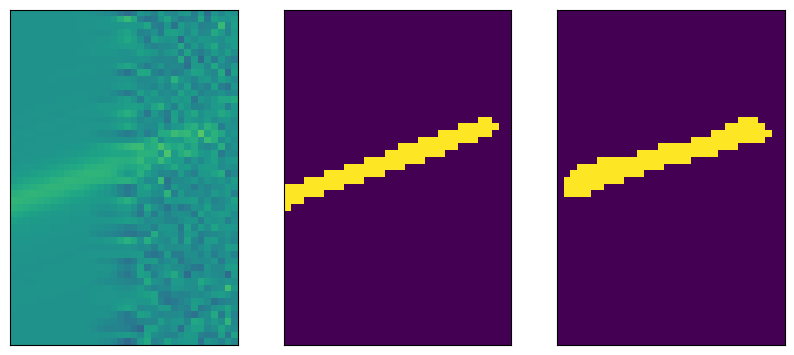

N: 39.0  x: 414.0  y: 9.0  mag: 23.53433343265013  trail: 46.0


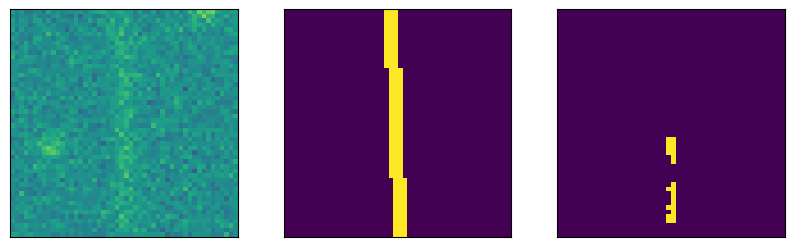

N: 40.0  x: 2431.0  y: 1559.0  mag: 23.954468239235073  trail: 49.0


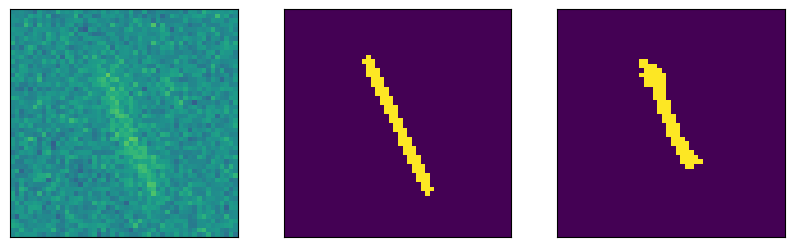

N: 40.0  x: 1141.0  y: 150.0  mag: 23.58246139779244  trail: 31.0


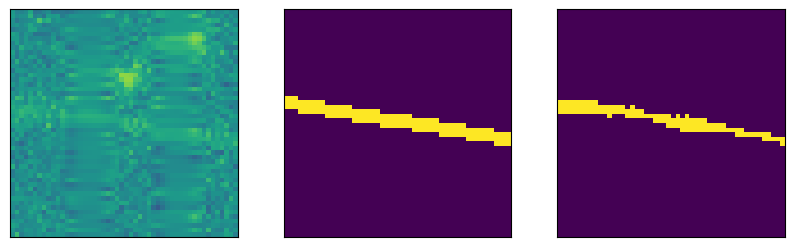

N: 40.0  x: 1321.0  y: 1187.0  mag: 23.879526537843986  trail: 63.0


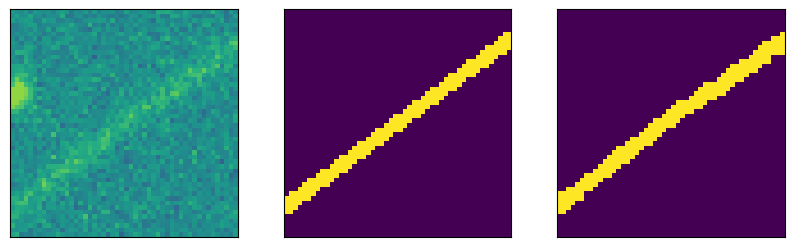

N: 40.0  x: 2153.0  y: 1116.0  mag: 23.54770469894371  trail: 68.0


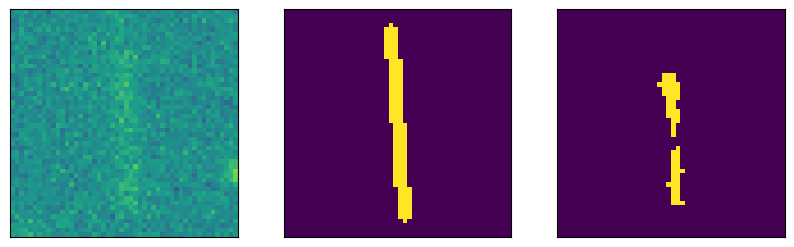

N: 40.0  x: 396.0  y: 801.0  mag: 23.909092810109797  trail: 41.0


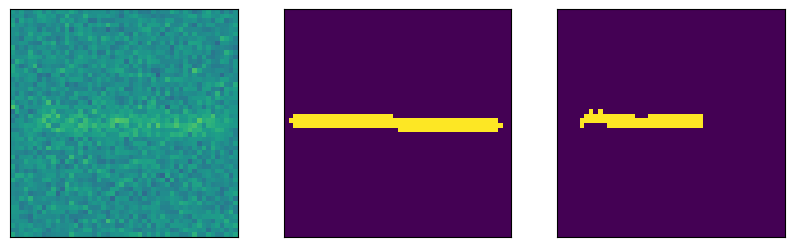

N: 40.0  x: 3020.0  y: 760.0  mag: 23.748363150096697  trail: 44.0


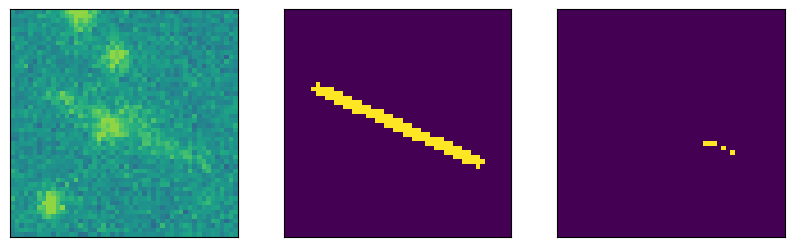

N: 40.0  x: 1194.0  y: 915.0  mag: 23.57971590611945  trail: 39.0


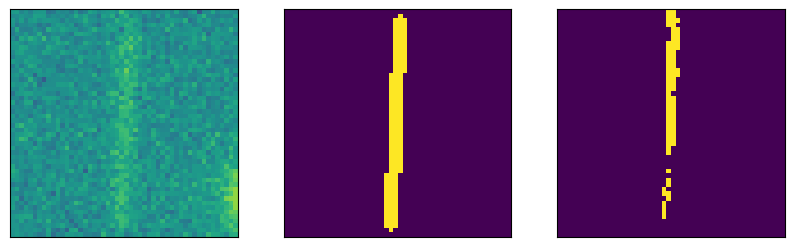

N: 40.0  x: 3385.0  y: 567.0  mag: 23.55974450745592  trail: 45.0


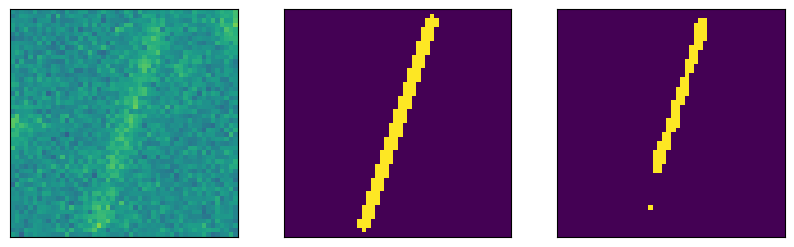

N: 40.0  x: 3670.0  y: 262.0  mag: 23.515219438623443  trail: 48.0


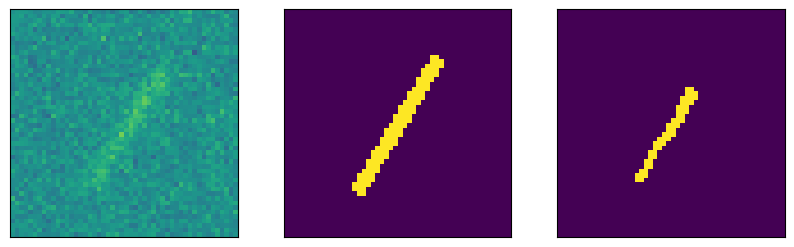

N: 40.0  x: 3593.0  y: 691.0  mag: 23.532747346025854  trail: 32.0


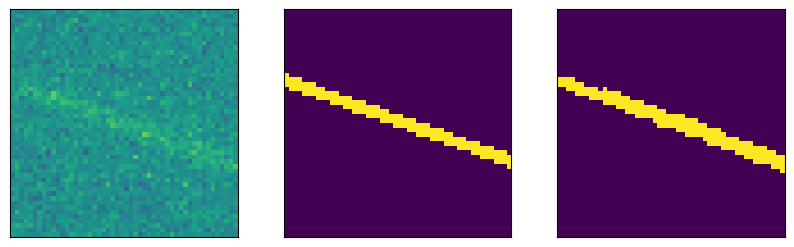

N: 40.0  x: 186.0  y: 736.0  mag: 23.90920139902473  trail: 71.0


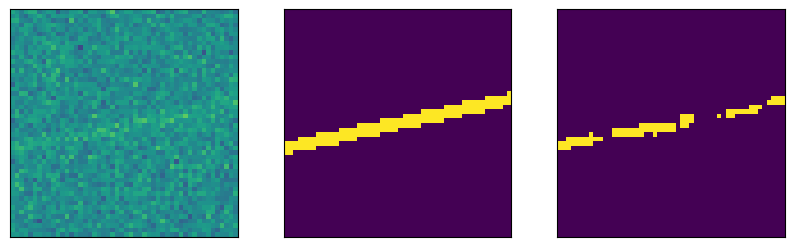

N: 41.0  x: 1313.0  y: 1912.0  mag: 23.606064370271614  trail: 62.0


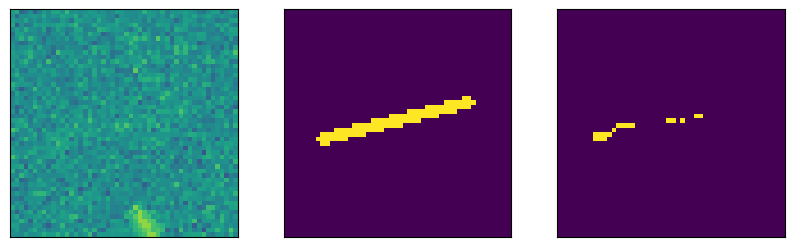

N: 41.0  x: 3472.0  y: 1575.0  mag: 23.572968139691493  trail: 33.0


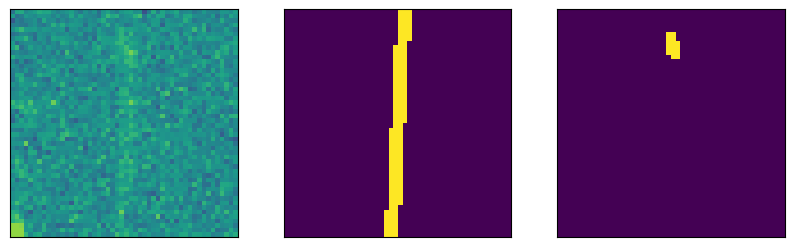

N: 41.0  x: 2499.0  y: 1963.0  mag: 23.6994626964158  trail: 54.0


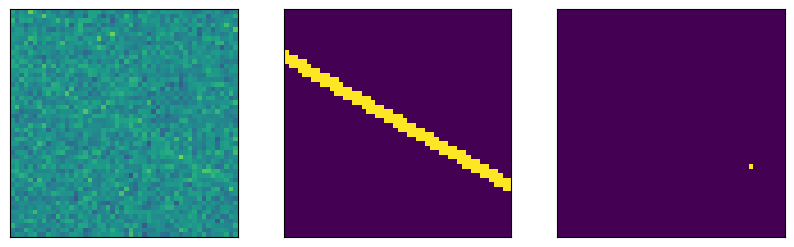

N: 41.0  x: 2994.0  y: 179.0  mag: 23.929158193531176  trail: 67.0


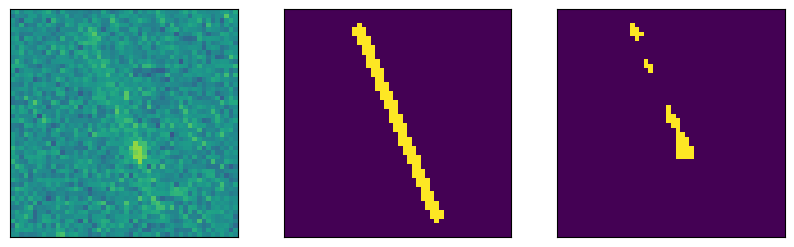

N: 41.0  x: 2234.0  y: 294.0  mag: 23.50916507377306  trail: 45.0


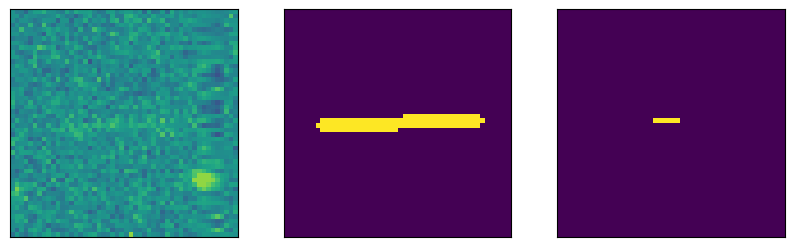

N: 41.0  x: 2509.0  y: 1005.0  mag: 23.68591470643972  trail: 34.0


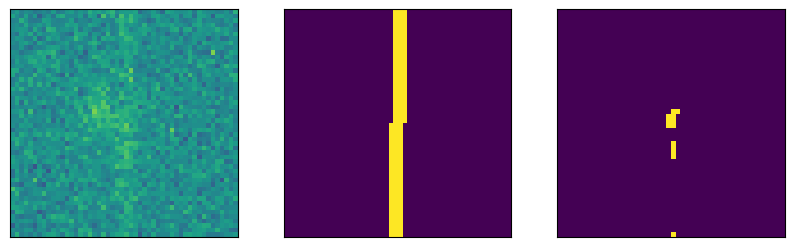

N: 41.0  x: 2633.0  y: 1481.0  mag: 23.503814764484677  trail: 57.0


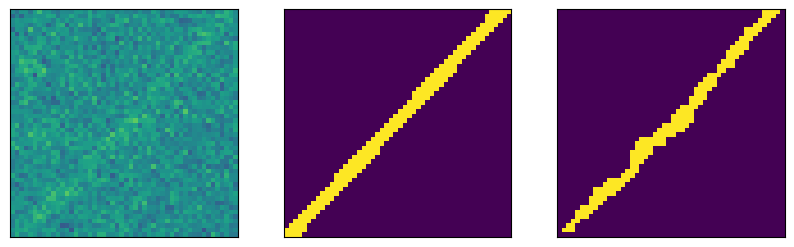

N: 42.0  x: 2533.0  y: 173.0  mag: 23.506789943727004  trail: 73.0


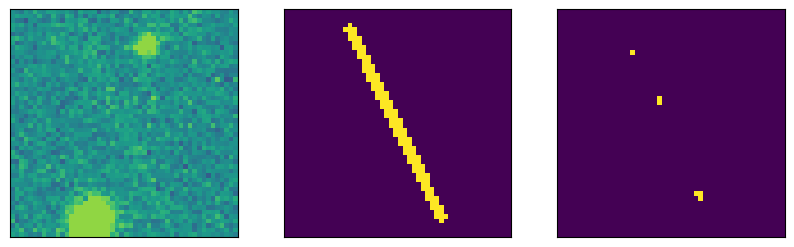

N: 42.0  x: 2157.0  y: 652.0  mag: 23.66062591824636  trail: 45.0


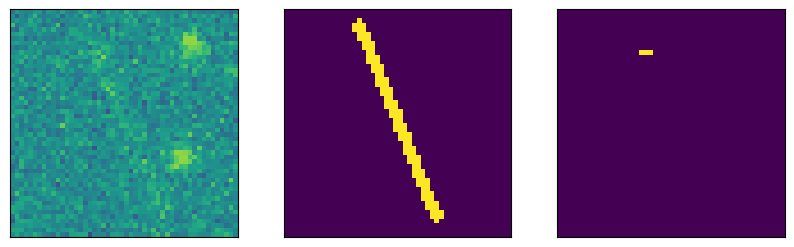

N: 42.0  x: 949.0  y: 1880.0  mag: 23.607226998656078  trail: 45.0


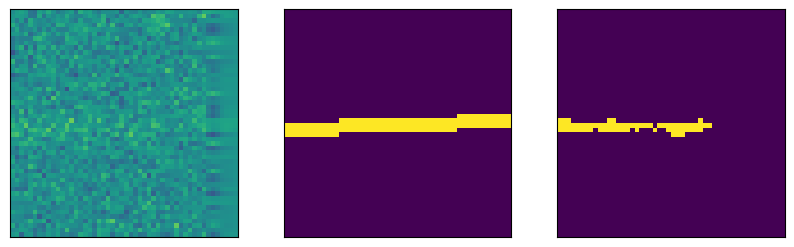

N: 42.0  x: 2446.0  y: 2007.0  mag: 23.677975087711808  trail: 53.0


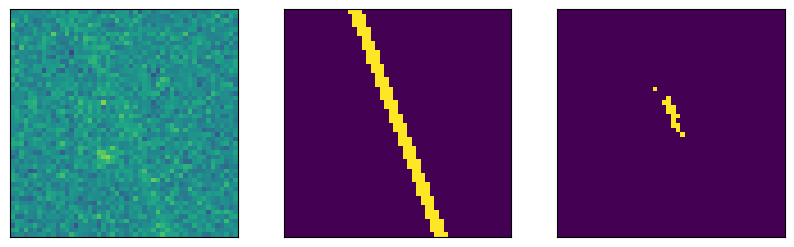

N: 42.0  x: 3651.0  y: 1579.0  mag: 23.553241512499046  trail: 65.0


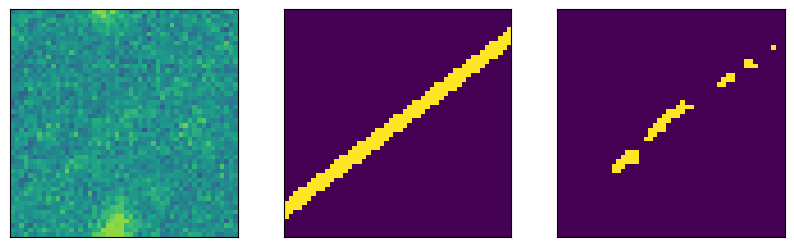

N: 42.0  x: 3915.0  y: 1894.0  mag: 23.76678060922747  trail: 64.0


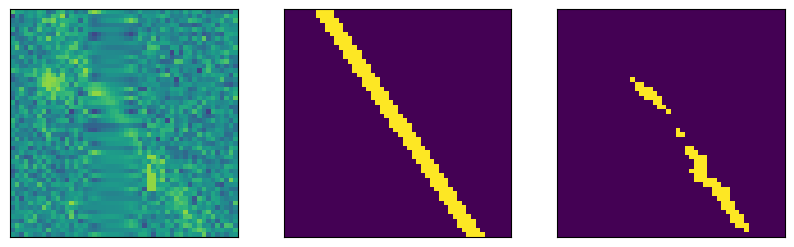

N: 43.0  x: 2116.0  y: 846.0  mag: 23.631556612292464  trail: 60.0


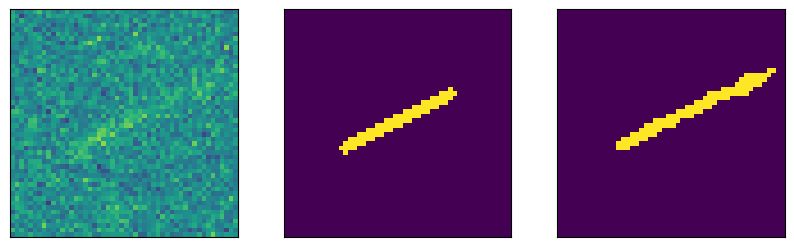

N: 43.0  x: 1807.0  y: 1967.0  mag: 23.711740125125523  trail: 26.0


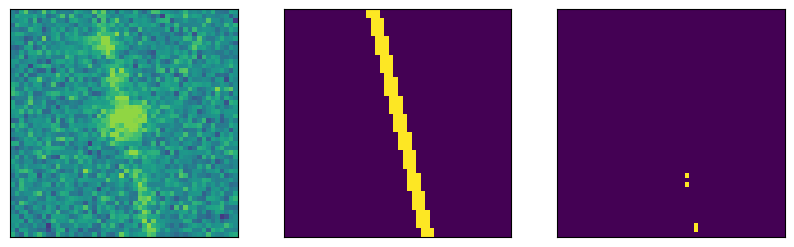

N: 43.0  x: 2507.0  y: 98.0  mag: 23.5205727530916  trail: 61.0


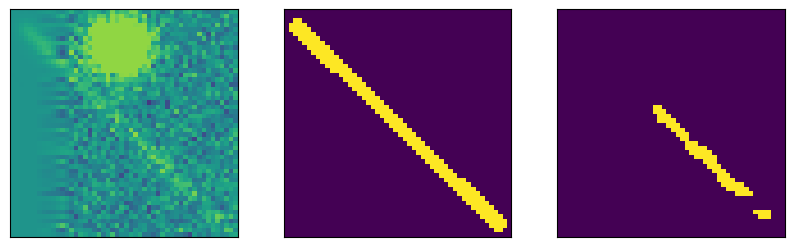

N: 43.0  x: 2565.0  y: 31.0  mag: 23.84450267069204  trail: 63.0


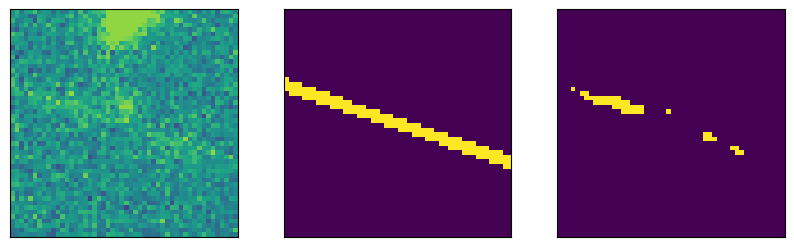

N: 43.0  x: 4129.0  y: 1748.0  mag: 23.98357112962465  trail: 66.0


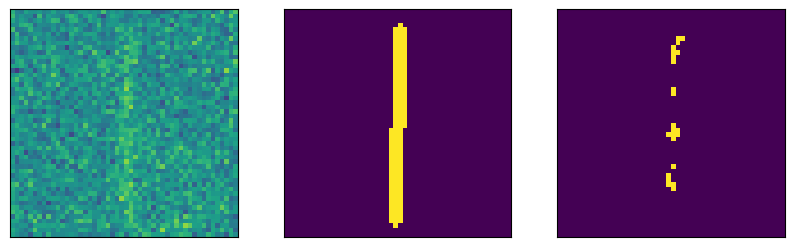

N: 43.0  x: 3887.0  y: 1546.0  mag: 23.56369748386008  trail: 42.0


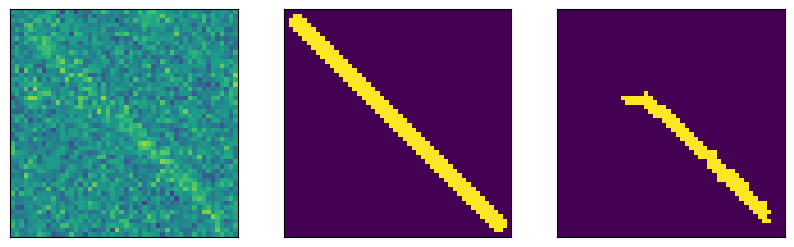

N: 43.0  x: 3977.0  y: 559.0  mag: 23.70026422290592  trail: 63.0


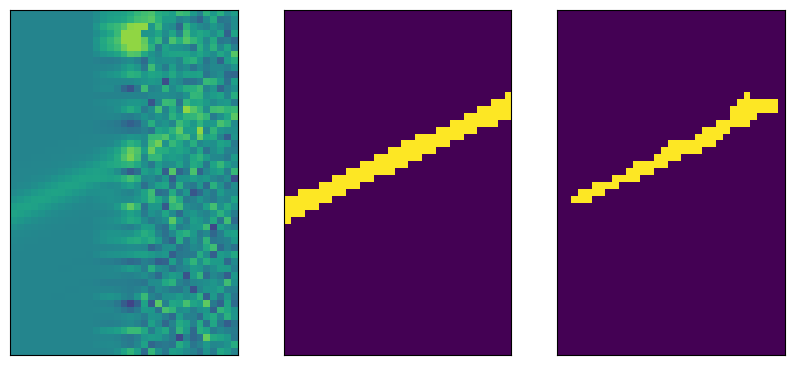

N: 43.0  x: 820.0  y: 8.0  mag: 23.790469889325706  trail: 55.0


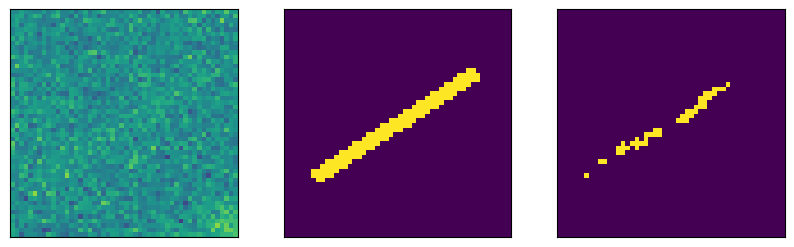

N: 45.0  x: 496.0  y: 1627.0  mag: 23.620518477440854  trail: 41.0


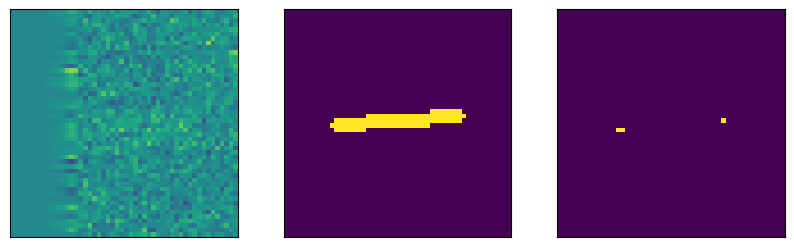

N: 45.0  x: 233.0  y: 29.0  mag: 23.501571141231903  trail: 28.0


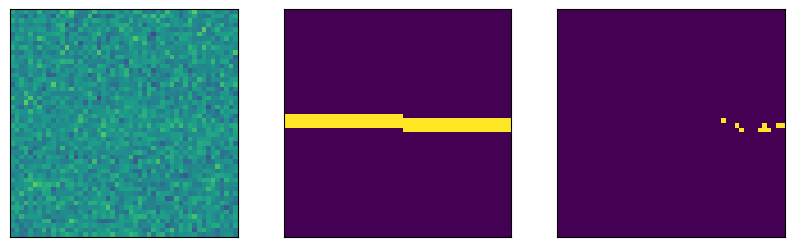

N: 45.0  x: 3567.0  y: 44.0  mag: 23.63380657817718  trail: 72.0


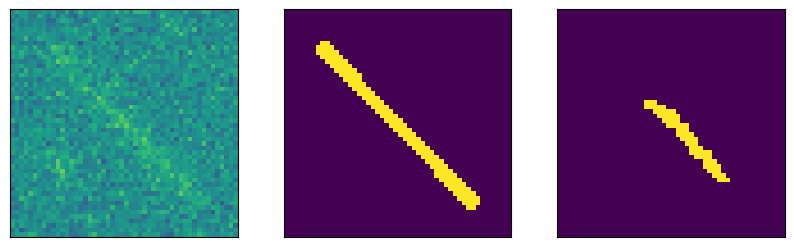

N: 46.0  x: 2054.0  y: 882.0  mag: 23.90916128465691  trail: 47.0


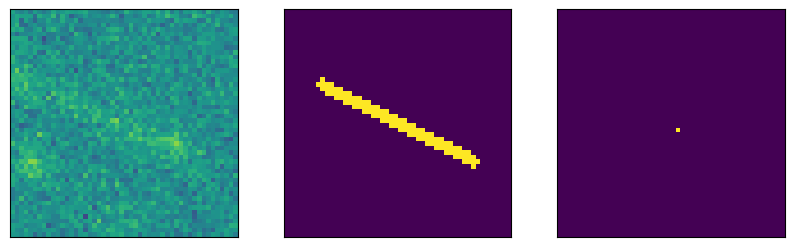

N: 46.0  x: 2543.0  y: 1928.0  mag: 23.92475980422683  trail: 37.0


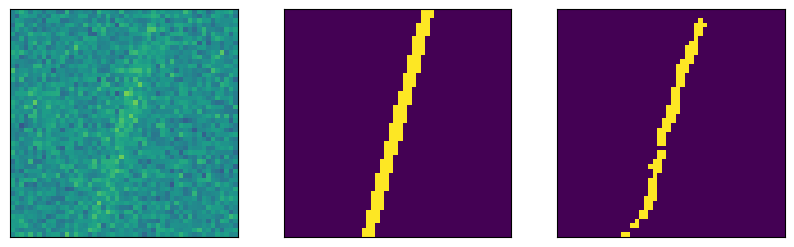

N: 46.0  x: 3488.0  y: 819.0  mag: 23.94143306250702  trail: 51.0


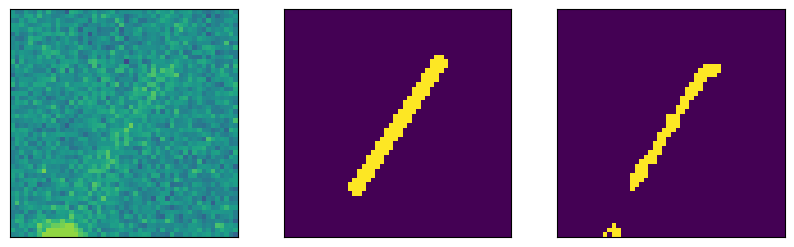

N: 46.0  x: 2337.0  y: 329.0  mag: 23.96364743439146  trail: 34.0


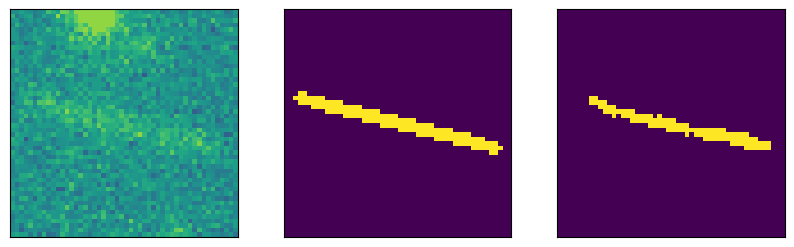

N: 46.0  x: 3505.0  y: 1083.0  mag: 23.657954709640716  trail: 45.0


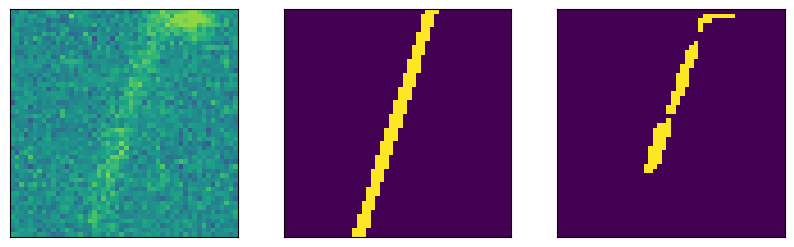

N: 46.0  x: 1780.0  y: 878.0  mag: 23.64085732651174  trail: 71.0


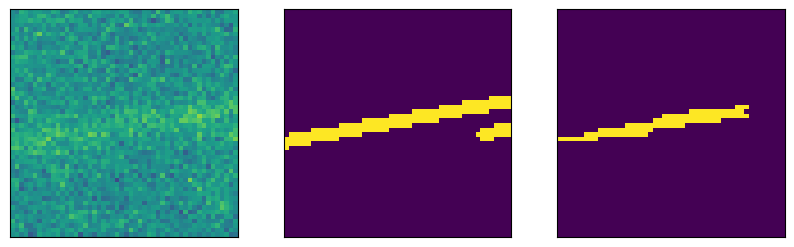

N: 46.0  x: 456.0  y: 110.0  mag: 23.770036333047784  trail: 67.0


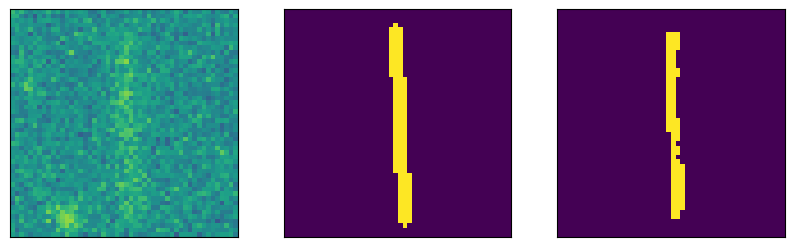

N: 46.0  x: 956.0  y: 971.0  mag: 23.687932014123337  trail: 42.0


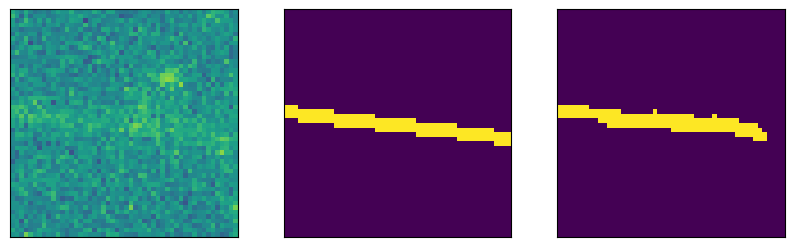

N: 46.0  x: 46.0  y: 874.0  mag: 23.73117410138513  trail: 70.0


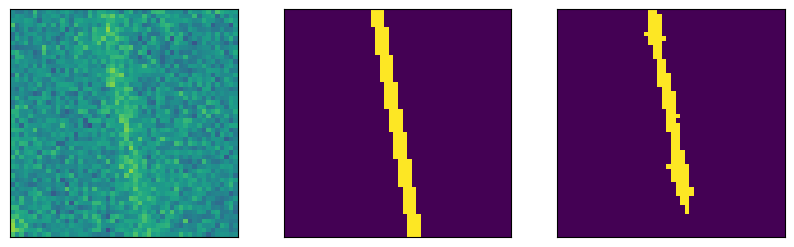

N: 46.0  x: 233.0  y: 1230.0  mag: 23.56455209179907  trail: 59.0


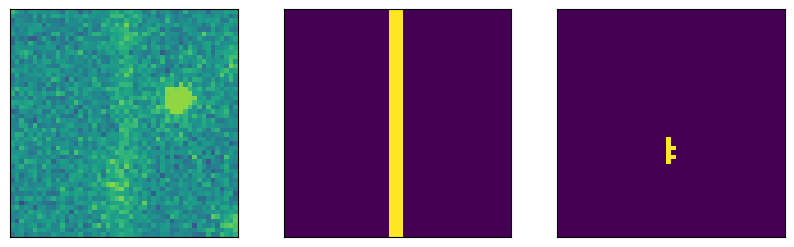

N: 46.0  x: 1234.0  y: 1144.0  mag: 23.919593419800723  trail: 68.0


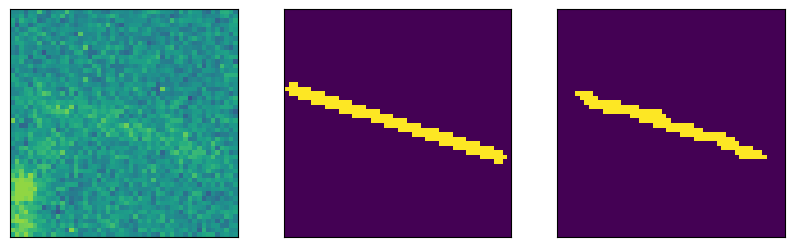

N: 46.0  x: 1513.0  y: 79.0  mag: 23.885097211472843  trail: 48.0


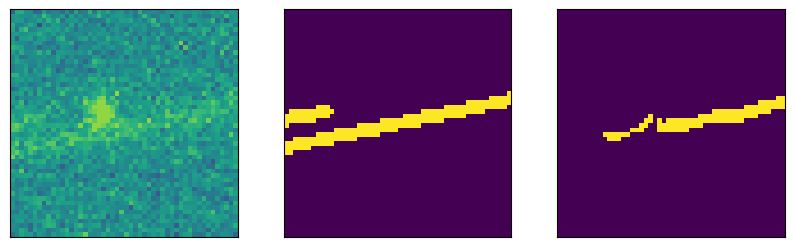

N: 46.0  x: 452.0  y: 159.0  mag: 23.657402500746045  trail: 63.0


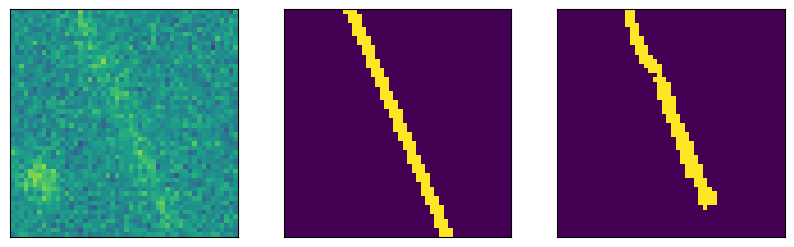

N: 46.0  x: 236.0  y: 354.0  mag: 23.830474120239916  trail: 63.0


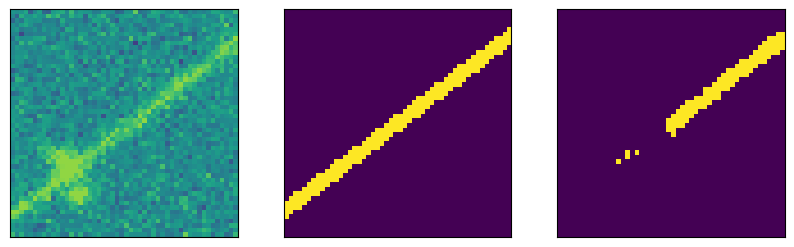

N: 47.0  x: 457.0  y: 1922.0  mag: 23.52490752441673  trail: 67.0


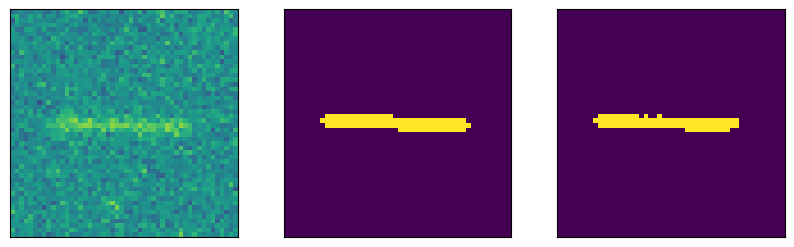

N: 47.0  x: 1756.0  y: 1719.0  mag: 23.58999418732965  trail: 30.0


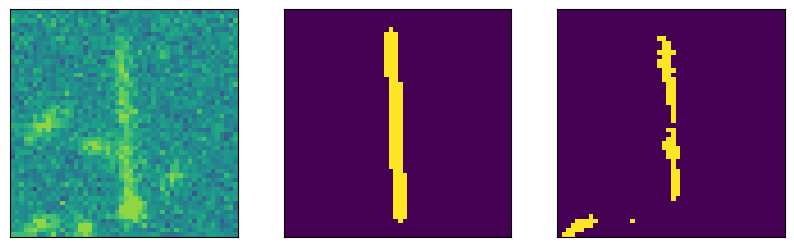

N: 47.0  x: 1390.0  y: 761.0  mag: 23.644293190811652  trail: 40.0


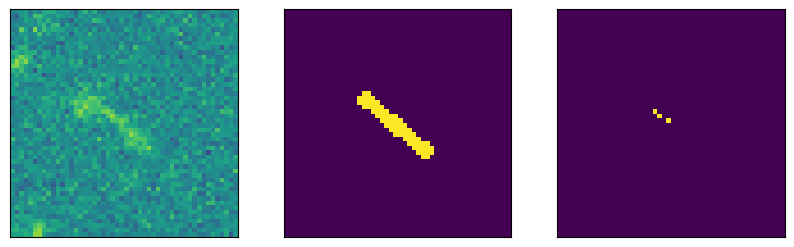

N: 47.0  x: 1528.0  y: 1174.0  mag: 23.712376245282847  trail: 18.0


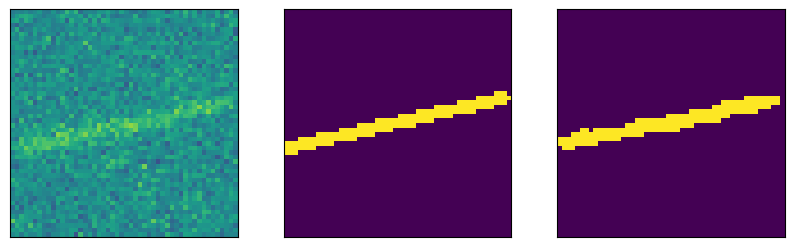

N: 47.0  x: 1049.0  y: 798.0  mag: 23.81856751374302  trail: 49.0


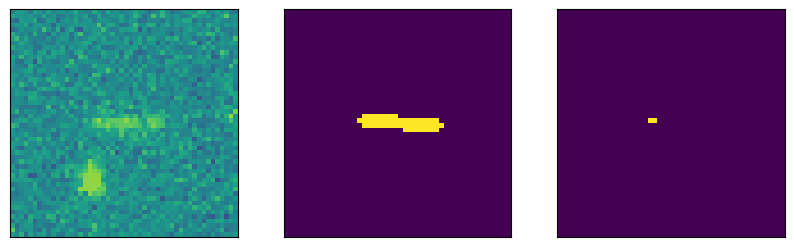

N: 47.0  x: 2103.0  y: 1992.0  mag: 23.572080480645845  trail: 16.0


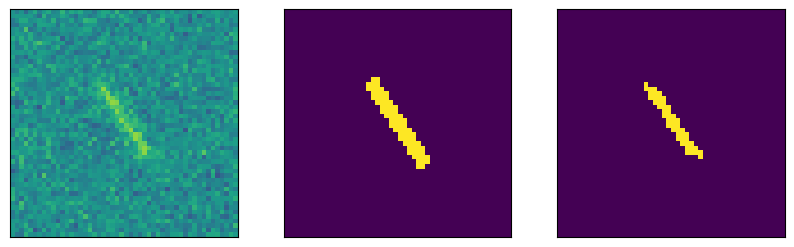

N: 47.0  x: 3955.0  y: 1967.0  mag: 23.61492612320215  trail: 20.0


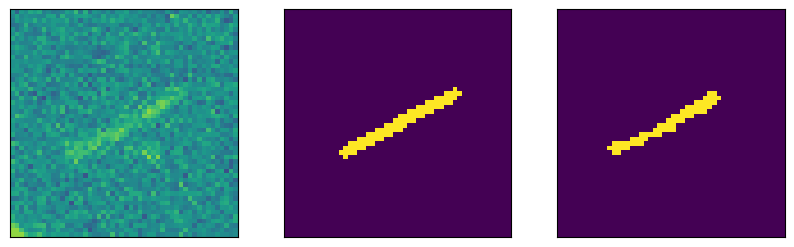

N: 47.0  x: 276.0  y: 884.0  mag: 23.72474598595809  trail: 28.0


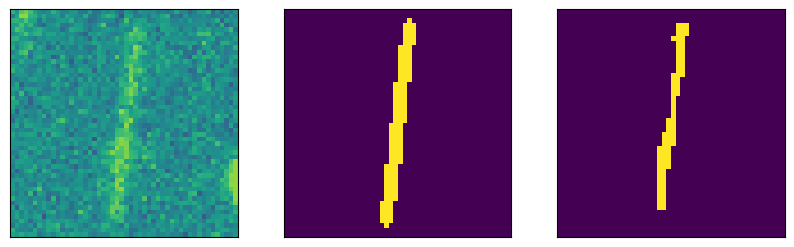

N: 47.0  x: 2766.0  y: 1549.0  mag: 23.721132424017107  trail: 43.0


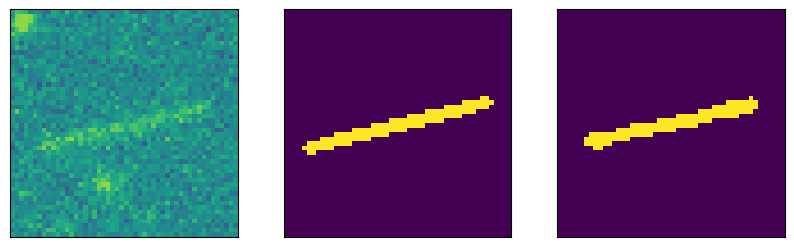

N: 47.0  x: 2530.0  y: 742.0  mag: 23.894652891414033  trail: 40.0


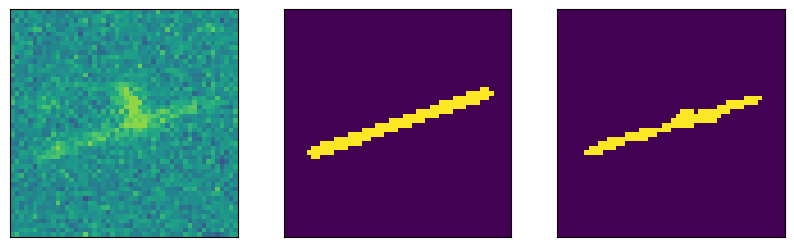

N: 47.0  x: 2637.0  y: 568.0  mag: 23.92465271631591  trail: 40.0


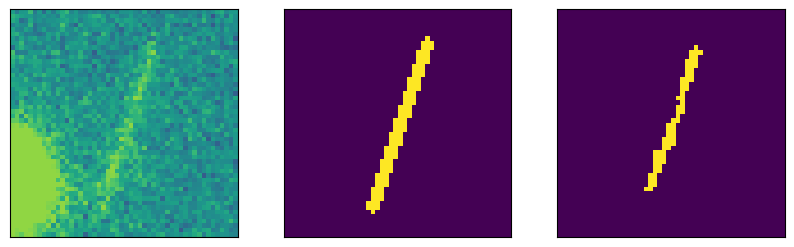

N: 47.0  x: 3043.0  y: 459.0  mag: 23.79368535075889  trail: 38.0


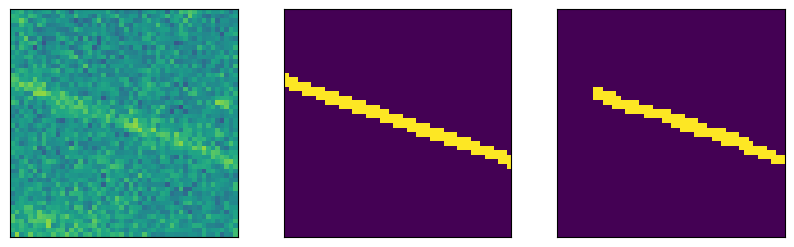

N: 47.0  x: 978.0  y: 530.0  mag: 23.931226901912904  trail: 60.0


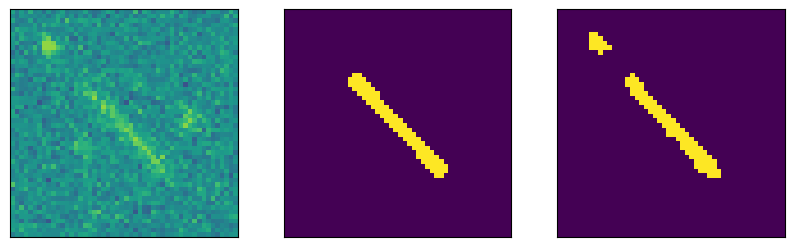

N: 47.0  x: 3505.0  y: 428.0  mag: 23.720474562041247  trail: 28.0


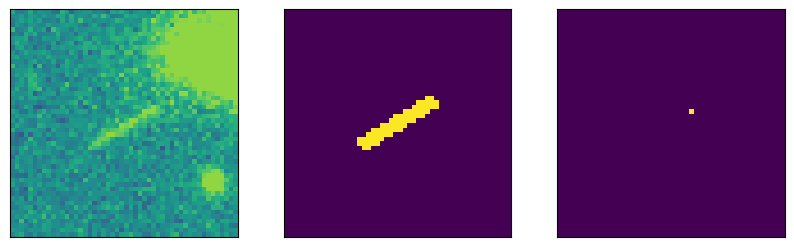

N: 47.0  x: 2351.0  y: 477.0  mag: 23.669439086711858  trail: 18.0


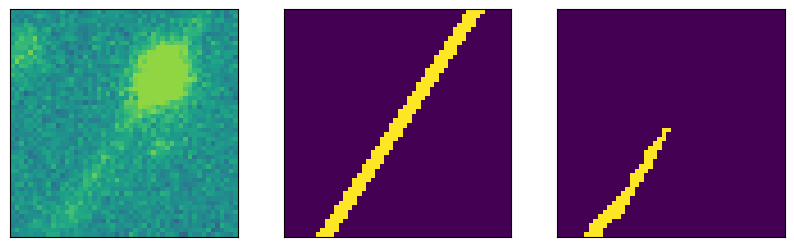

N: 48.0  x: 1986.0  y: 1688.0  mag: 23.671704075606797  trail: 61.0


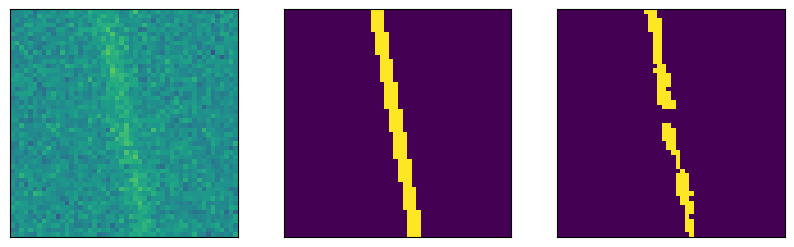

N: 48.0  x: 1537.0  y: 502.0  mag: 23.654729342559897  trail: 57.0


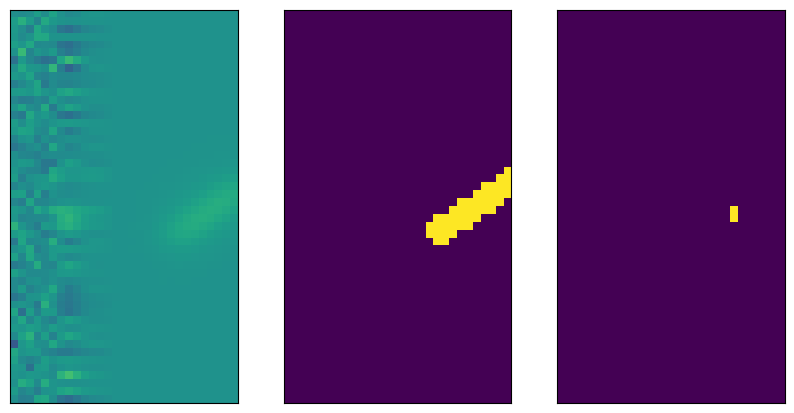

N: 48.0  x: 504.0  y: 2044.0  mag: 23.681442870587244  trail: 12.0


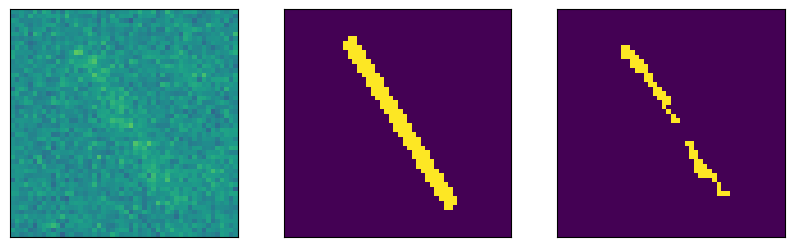

N: 48.0  x: 961.0  y: 709.0  mag: 23.859539094764788  trail: 42.0


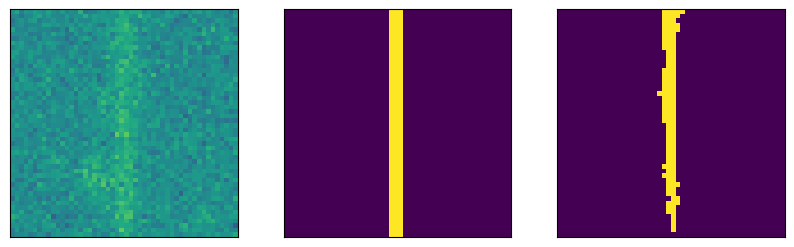

N: 48.0  x: 926.0  y: 361.0  mag: 23.54787697044023  trail: 53.0


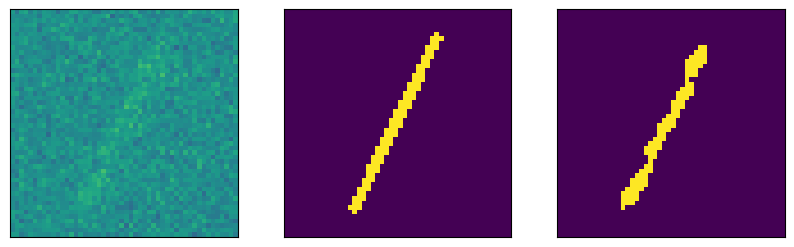

N: 48.0  x: 2200.0  y: 1596.0  mag: 23.997237274817515  trail: 41.0


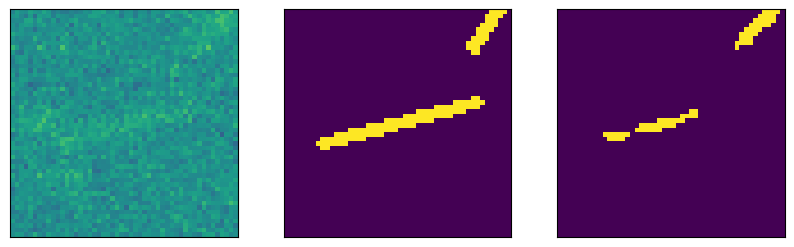

N: 48.0  x: 2028.0  y: 1655.0  mag: 23.946379486936458  trail: 35.0


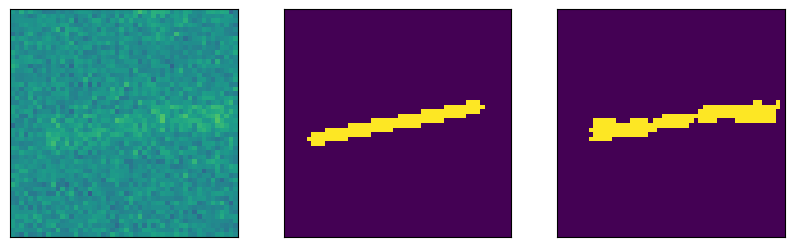

N: 48.0  x: 2893.0  y: 1597.0  mag: 23.935359126890713  trail: 37.0


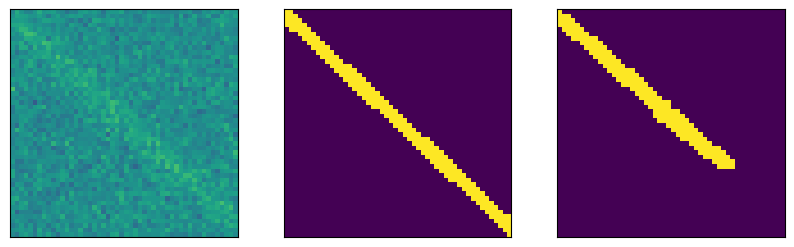

N: 48.0  x: 885.0  y: 443.0  mag: 23.90622489263035  trail: 72.0


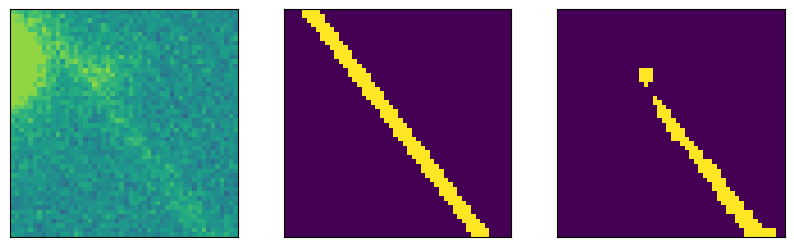

N: 48.0  x: 2457.0  y: 151.0  mag: 23.73468569675249  trail: 69.0


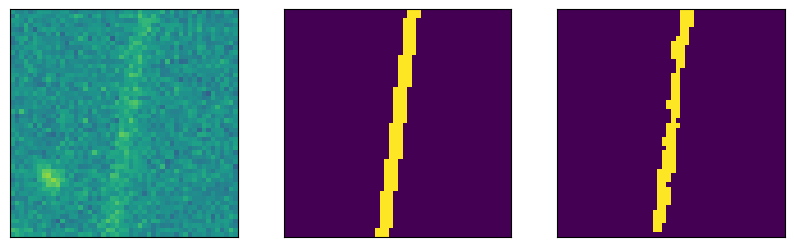

N: 49.0  x: 1110.0  y: 1684.0  mag: 23.629475015834  trail: 54.0


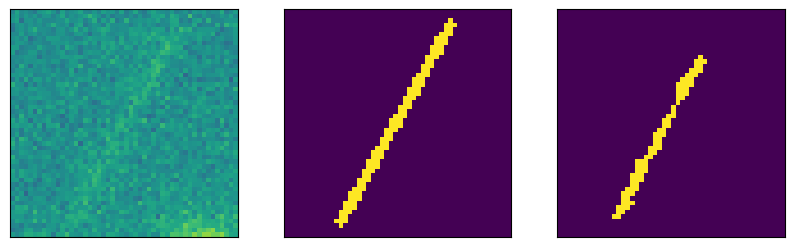

N: 49.0  x: 3216.0  y: 1601.0  mag: 23.989979506453665  trail: 49.0


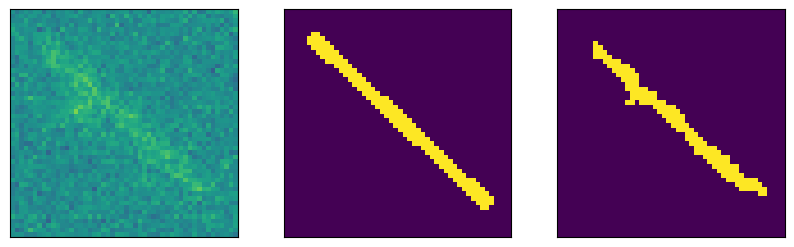

N: 49.0  x: 1004.0  y: 1088.0  mag: 23.60466148193602  trail: 53.0


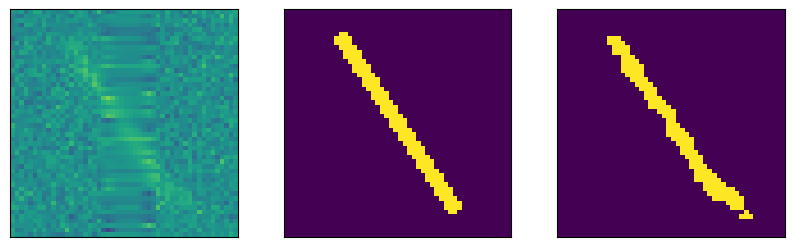

N: 49.0  x: 204.0  y: 1460.0  mag: 23.727116922802804  trail: 44.0


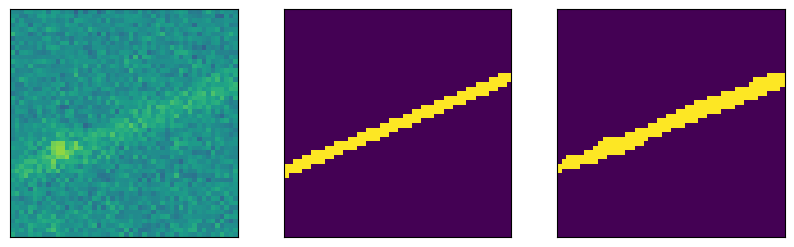

N: 49.0  x: 3019.0  y: 354.0  mag: 23.649992639295263  trail: 65.0


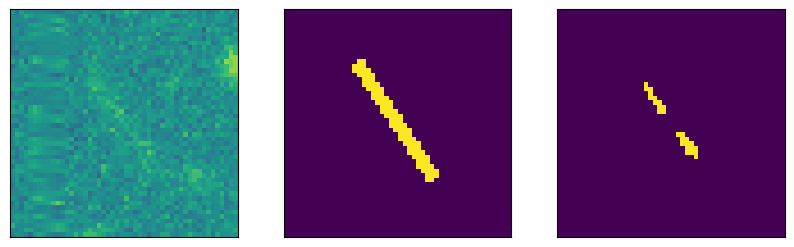

N: 49.0  x: 374.0  y: 565.0  mag: 23.780184467444325  trail: 29.0


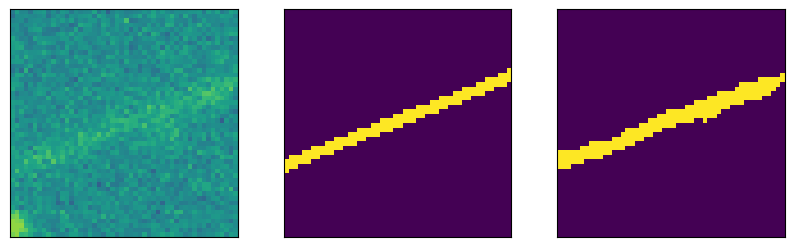

N: 49.0  x: 2901.0  y: 1105.0  mag: 23.691983884918873  trail: 55.0


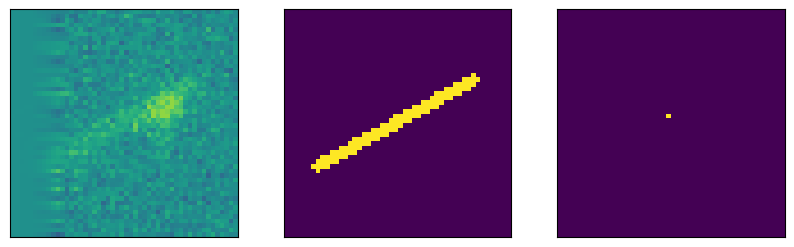

N: 49.0  x: 3962.0  y: 32.0  mag: 23.665569705754002  trail: 39.0


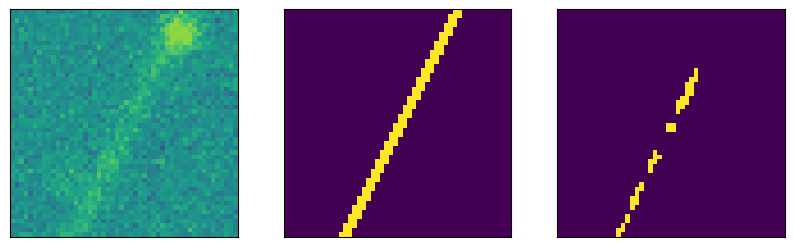

N: 49.0  x: 3067.0  y: 279.0  mag: 23.624641747089363  trail: 63.0


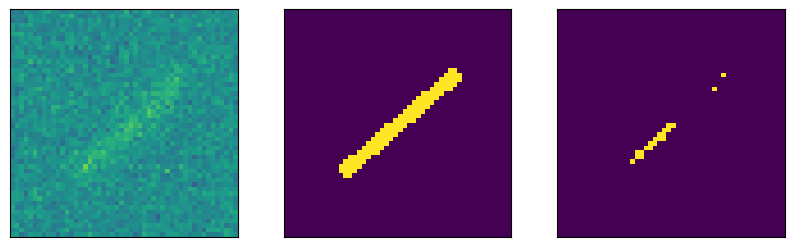

N: 49.0  x: 880.0  y: 1918.0  mag: 23.512037605442274  trail: 32.0


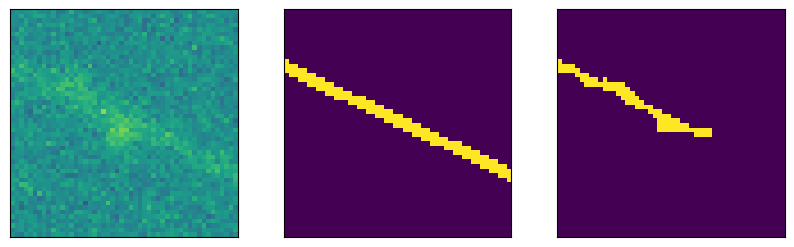

N: 49.0  x: 372.0  y: 629.0  mag: 23.67511348429699  trail: 70.0


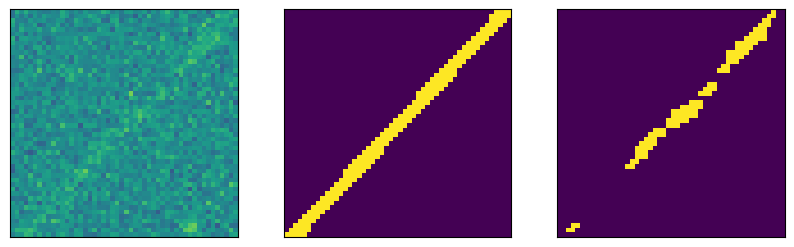

N: 51.0  x: 1888.0  y: 1163.0  mag: 23.637980375927963  trail: 70.0


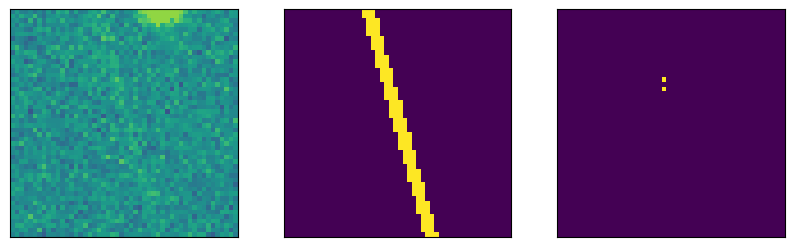

N: 51.0  x: 1804.0  y: 1500.0  mag: 23.644314232779454  trail: 52.0


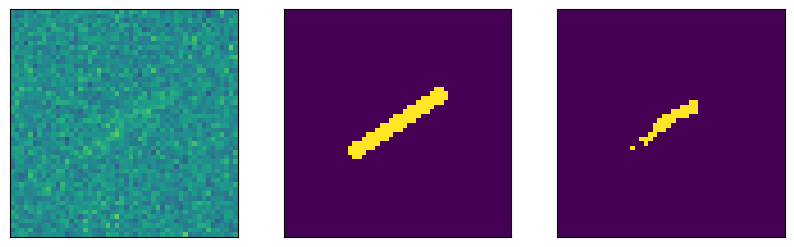

N: 51.0  x: 3924.0  y: 503.0  mag: 23.643833083483507  trail: 24.0


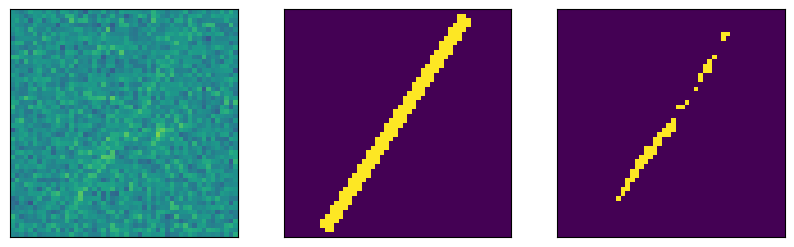

N: 51.0  x: 3684.0  y: 457.0  mag: 23.879539395254234  trail: 54.0


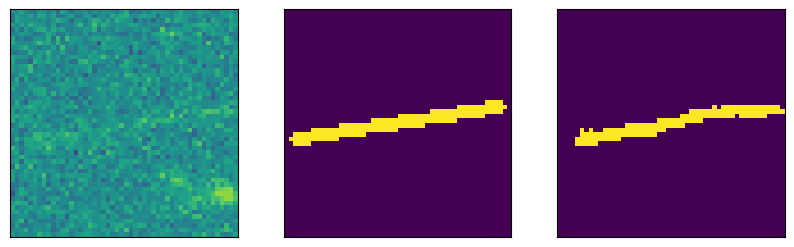

N: 51.0  x: 3438.0  y: 1565.0  mag: 23.781123396425713  trail: 46.0


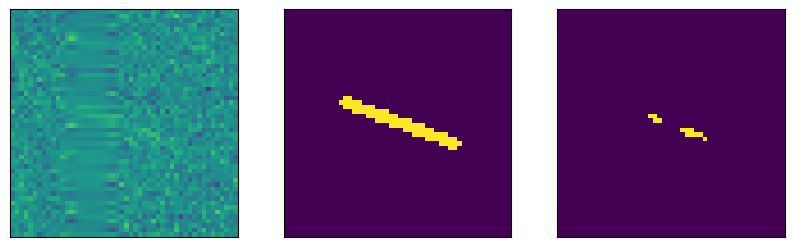

N: 51.0  x: 309.0  y: 1468.0  mag: 23.69688043544843  trail: 26.0


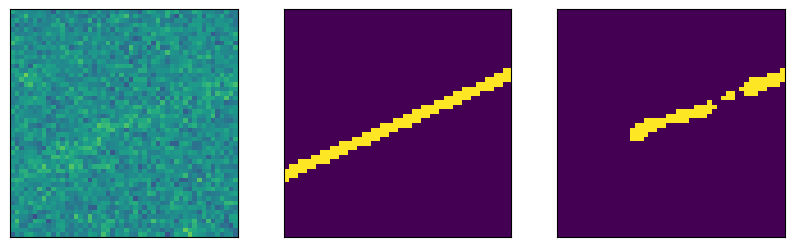

N: 52.0  x: 181.0  y: 1675.0  mag: 23.618652296543804  trail: 59.0


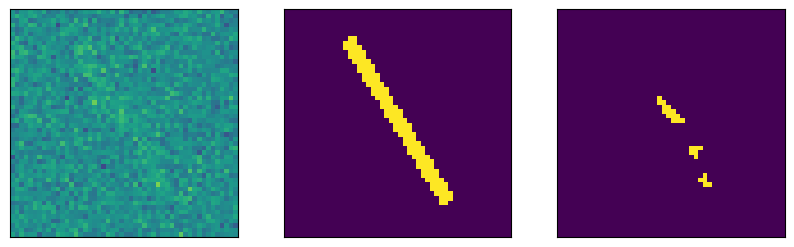

N: 52.0  x: 1939.0  y: 1848.0  mag: 23.60050490921614  trail: 40.0


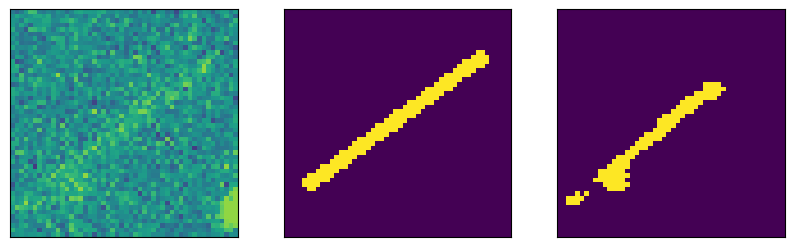

N: 53.0  x: 842.0  y: 1779.0  mag: 23.592354233165906  trail: 47.0


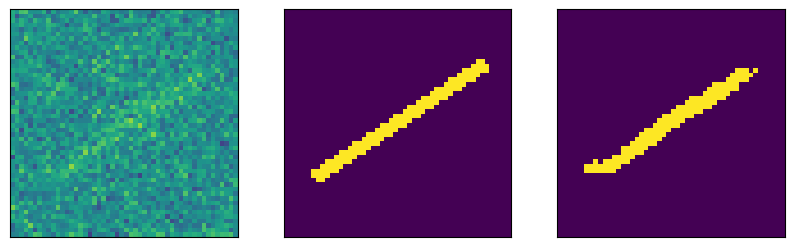

N: 53.0  x: 65.0  y: 1708.0  mag: 23.627128777591473  trail: 44.0


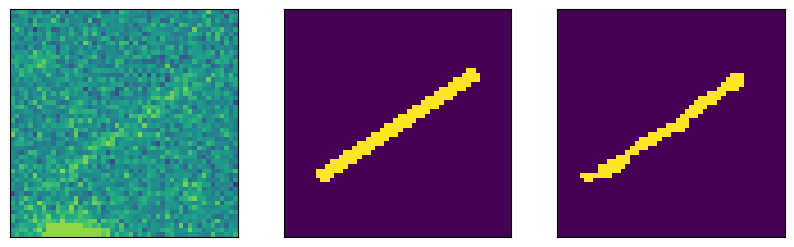

N: 53.0  x: 311.0  y: 1722.0  mag: 23.662039945601723  trail: 40.0


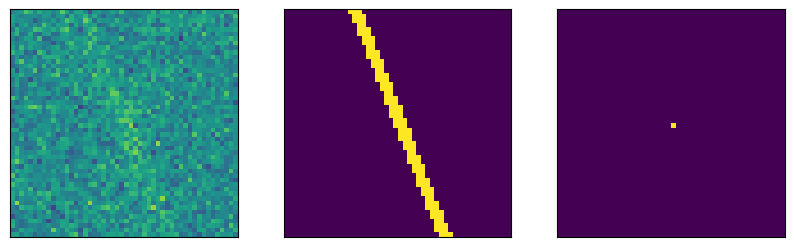

N: 53.0  x: 3044.0  y: 257.0  mag: 23.978113688183953  trail: 66.0


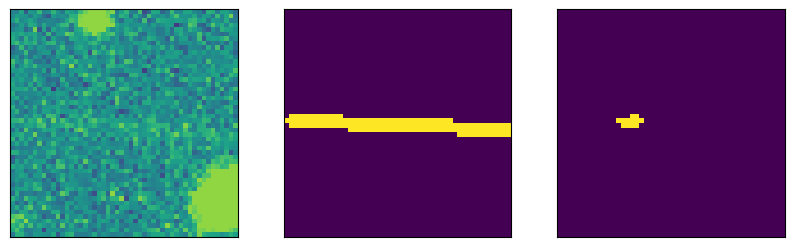

N: 53.0  x: 738.0  y: 382.0  mag: 23.97071253534908  trail: 48.0


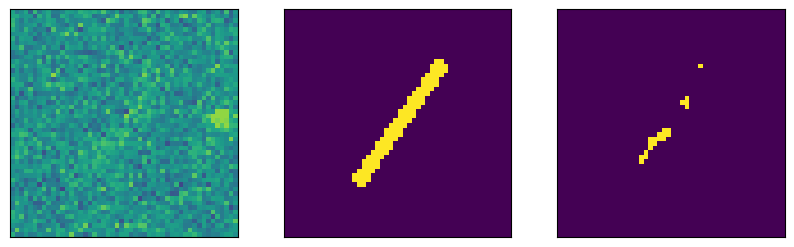

N: 53.0  x: 1993.0  y: 1900.0  mag: 23.974734299542497  trail: 31.0


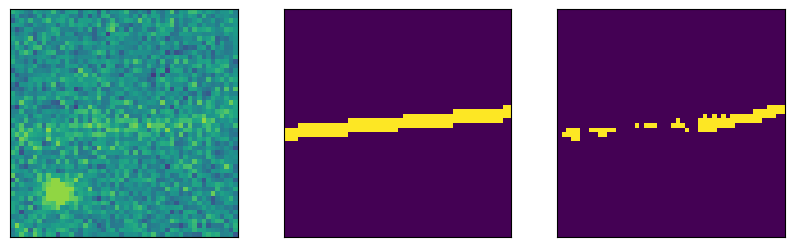

N: 53.0  x: 3041.0  y: 1147.0  mag: 23.757904131785008  trail: 56.0


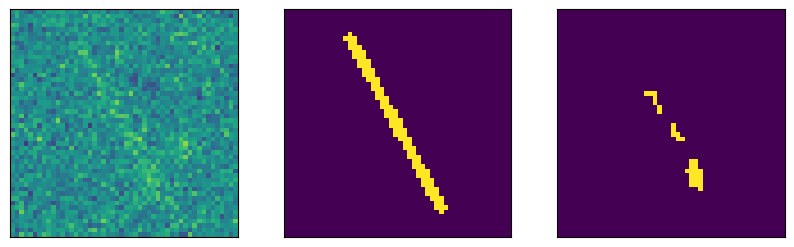

N: 53.0  x: 2315.0  y: 853.0  mag: 23.91737578161592  trail: 42.0


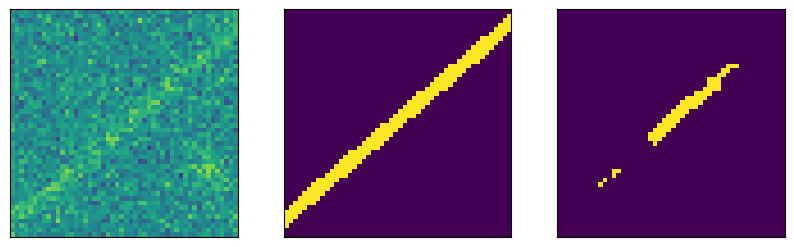

N: 53.0  x: 2831.0  y: 903.0  mag: 23.565857661950744  trail: 67.0


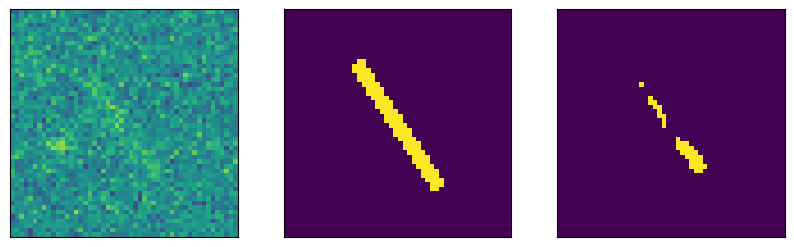

N: 53.0  x: 3258.0  y: 972.0  mag: 23.70979221755474  trail: 31.0


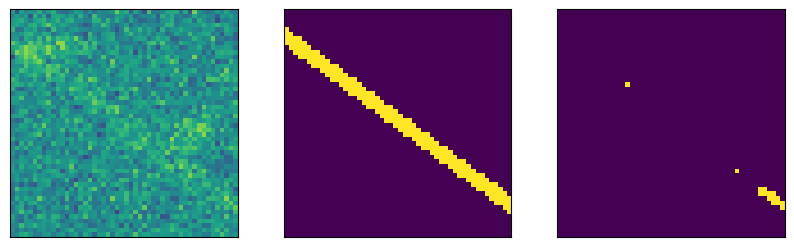

N: 53.0  x: 3867.0  y: 1447.0  mag: 23.891113737649707  trail: 73.0


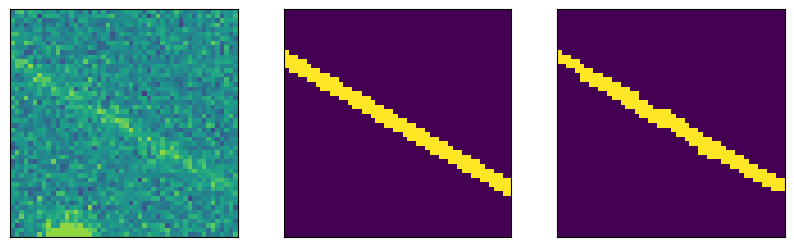

N: 53.0  x: 3172.0  y: 723.0  mag: 23.532205057182914  trail: 72.0


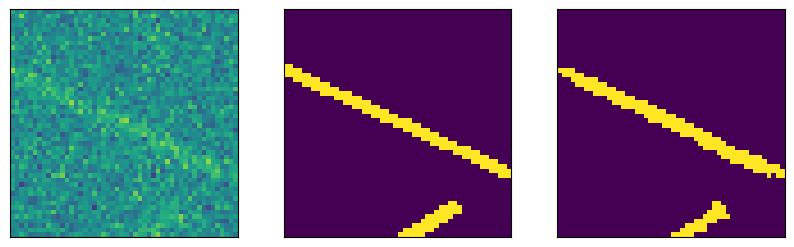

N: 53.0  x: 3376.0  y: 574.0  mag: 23.514140662796105  trail: 57.0


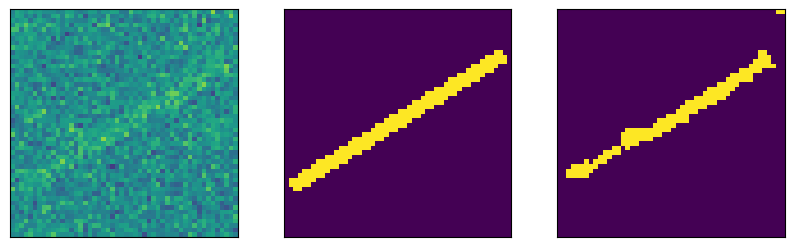

N: 53.0  x: 3409.0  y: 564.0  mag: 23.653378139862124  trail: 53.0


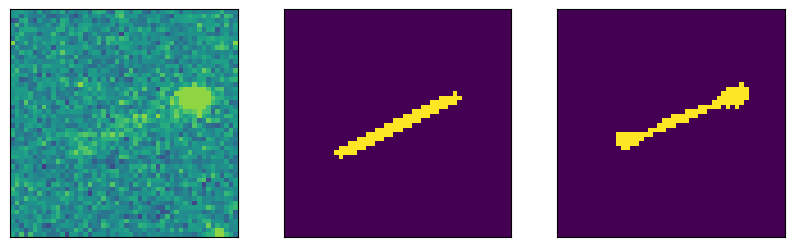

N: 53.0  x: 3415.0  y: 494.0  mag: 23.651524863544783  trail: 28.0


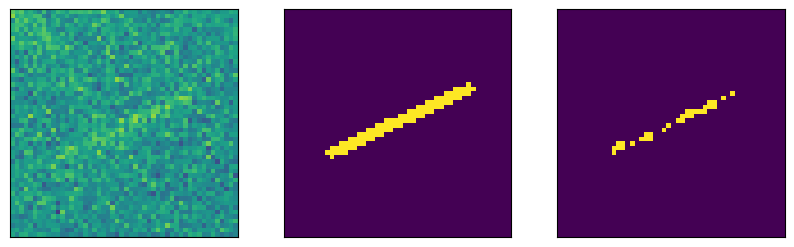

N: 53.0  x: 2271.0  y: 681.0  mag: 23.678676428431086  trail: 33.0


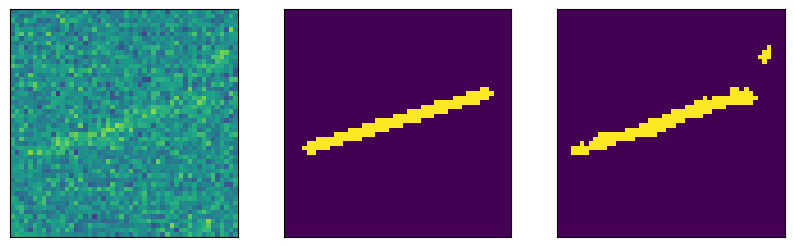

N: 53.0  x: 2131.0  y: 804.0  mag: 23.709003468515714  trail: 41.0


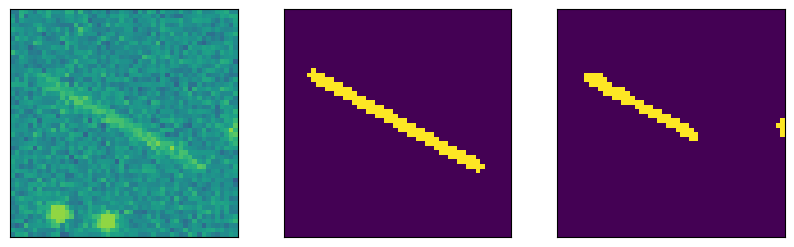

N: 55.0  x: 3405.0  y: 121.0  mag: 23.724078362846235  trail: 41.0


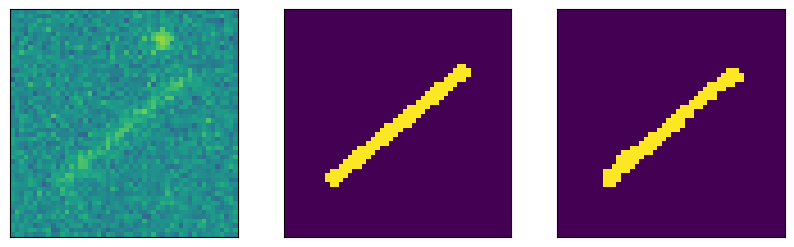

N: 55.0  x: 2981.0  y: 1075.0  mag: 23.858744217049413  trail: 38.0


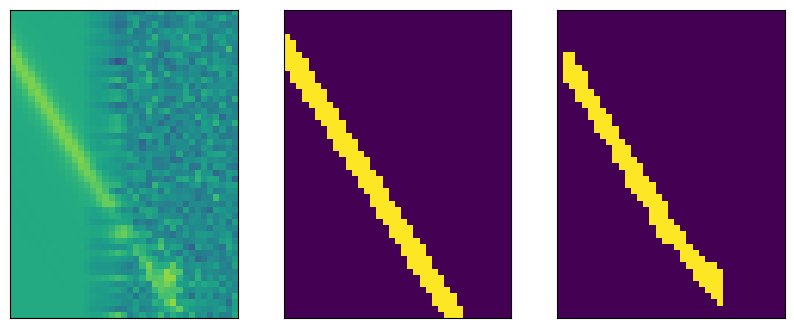

N: 55.0  x: 3157.0  y: 12.0  mag: 23.774231165245283  trail: 58.0


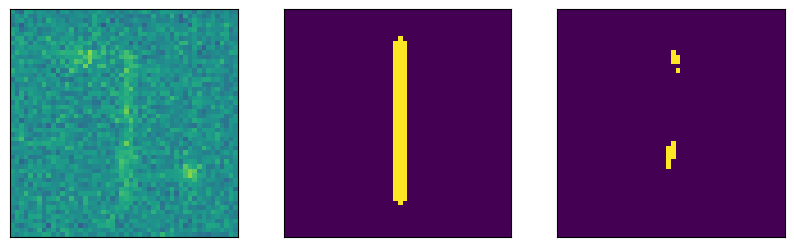

N: 55.0  x: 3375.0  y: 866.0  mag: 23.98734145214685  trail: 34.0


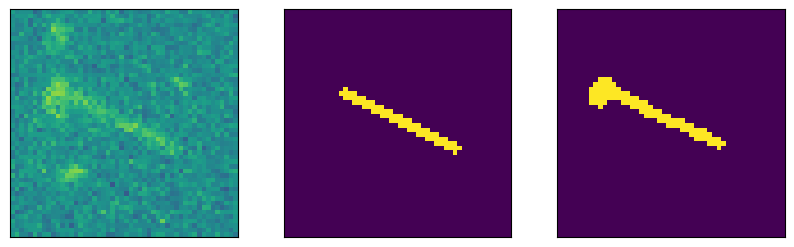

N: 55.0  x: 4048.0  y: 1847.0  mag: 23.614346084881852  trail: 27.0


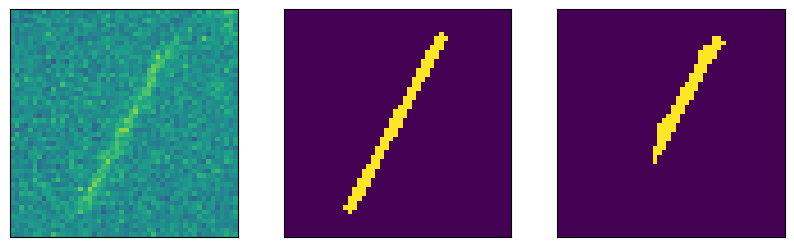

N: 55.0  x: 2660.0  y: 773.0  mag: 23.73550219175159  trail: 42.0


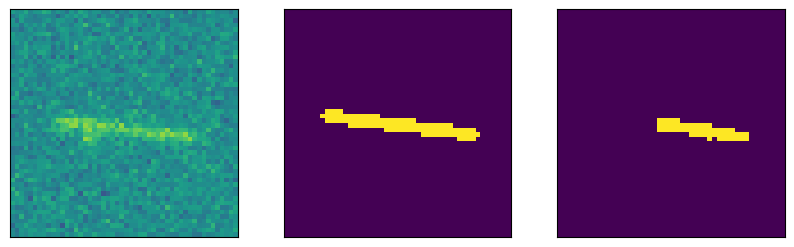

N: 55.0  x: 2655.0  y: 644.0  mag: 23.502969227964194  trail: 32.0


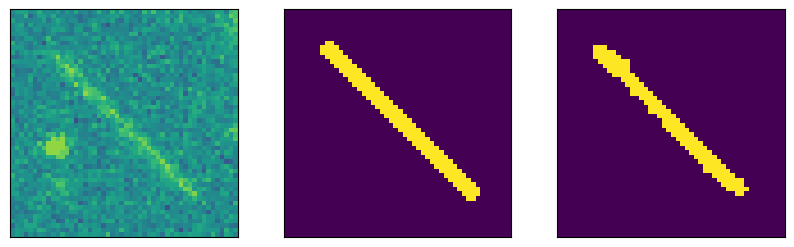

N: 55.0  x: 366.0  y: 1854.0  mag: 23.554857276612502  trail: 45.0


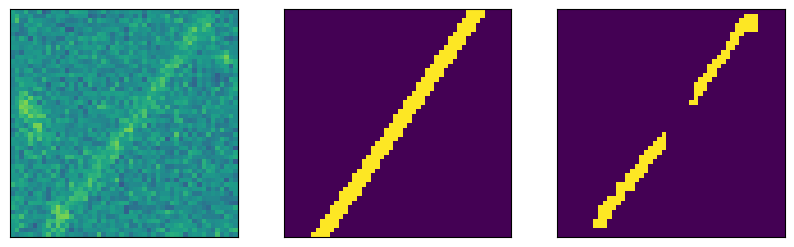

N: 55.0  x: 767.0  y: 1277.0  mag: 23.966647382551535  trail: 61.0


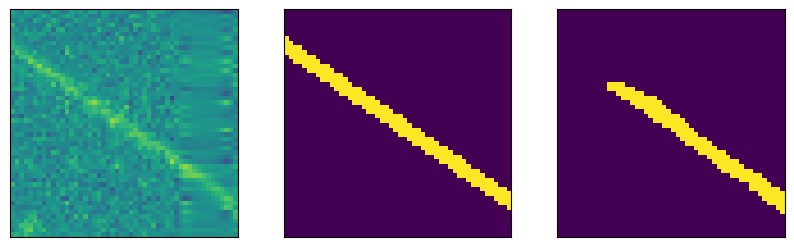

N: 55.0  x: 1546.0  y: 1443.0  mag: 23.614405762437013  trail: 63.0


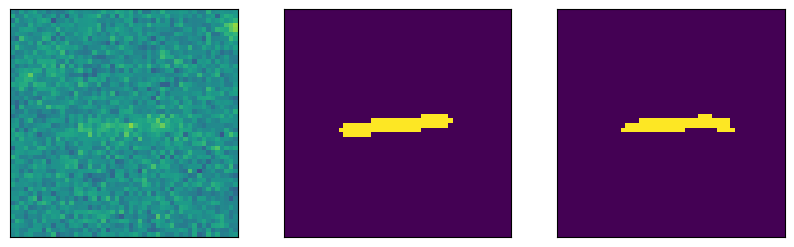

N: 55.0  x: 577.0  y: 1084.0  mag: 23.934246218116602  trail: 22.0


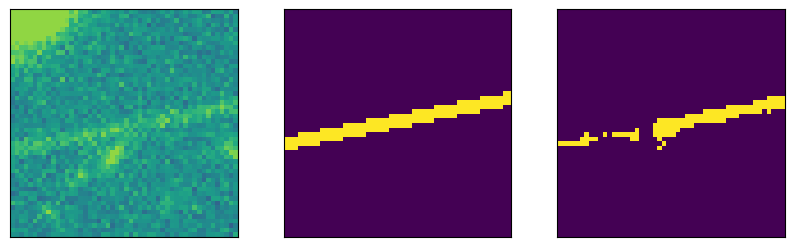

N: 55.0  x: 1739.0  y: 901.0  mag: 23.81840968337246  trail: 61.0


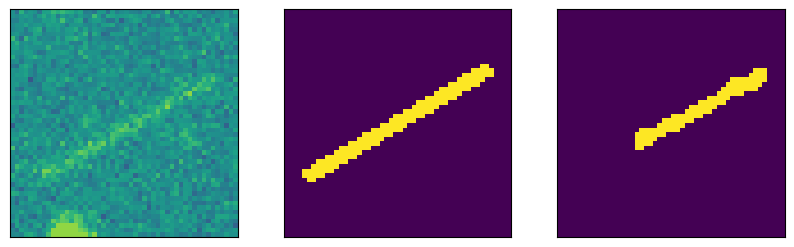

N: 55.0  x: 1526.0  y: 905.0  mag: 23.78647949277099  trail: 45.0


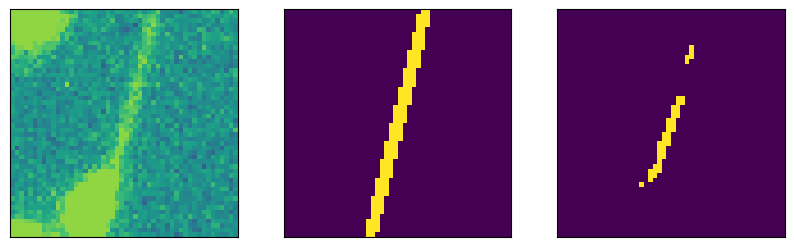

N: 55.0  x: 903.0  y: 729.0  mag: 23.507447695633612  trail: 54.0


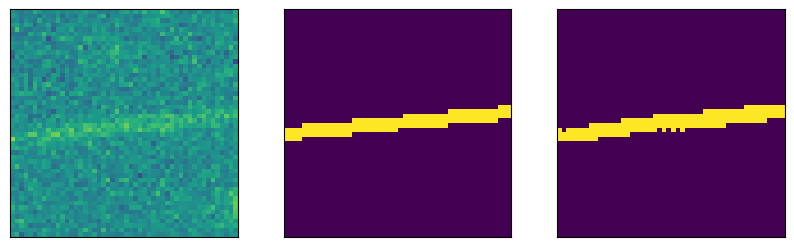

N: 56.0  x: 2672.0  y: 1893.0  mag: 23.769558774168228  trail: 54.0


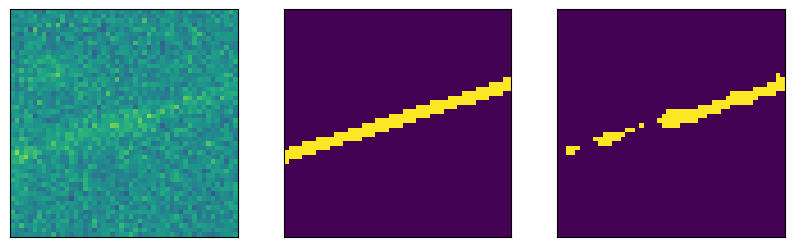

N: 56.0  x: 940.0  y: 387.0  mag: 23.979374871002523  trail: 52.0


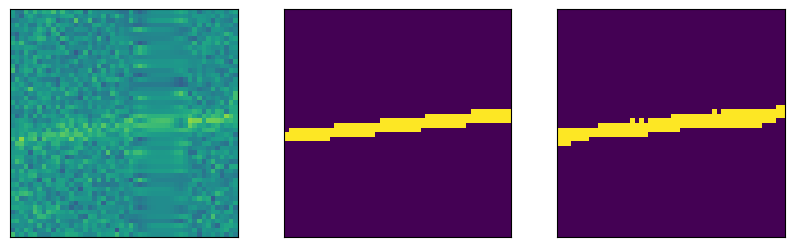

N: 56.0  x: 1294.0  y: 1453.0  mag: 23.723782125023586  trail: 60.0


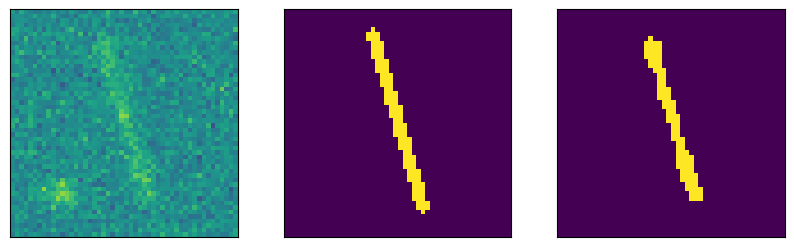

N: 56.0  x: 532.0  y: 89.0  mag: 23.619523460608285  trail: 39.0


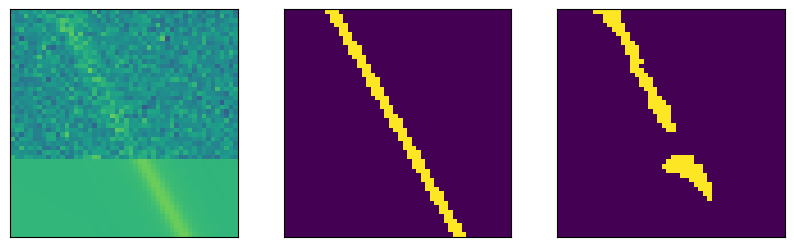

N: 56.0  x: 4147.0  y: 1266.0  mag: 23.990826606020036  trail: 66.0


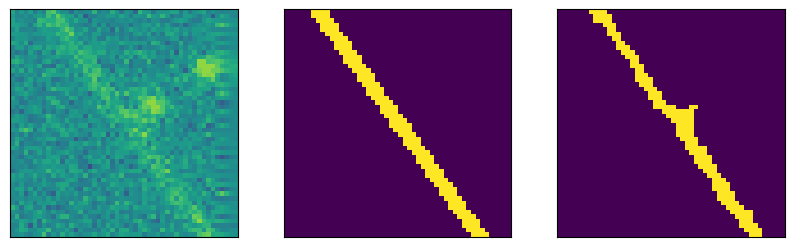

N: 56.0  x: 2113.0  y: 2005.0  mag: 23.648012177381634  trail: 62.0


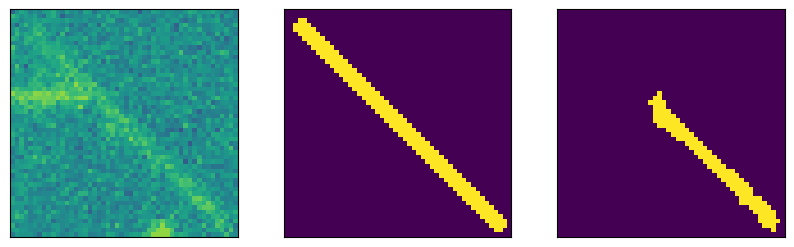

N: 56.0  x: 3373.0  y: 1157.0  mag: 23.624704469362513  trail: 63.0


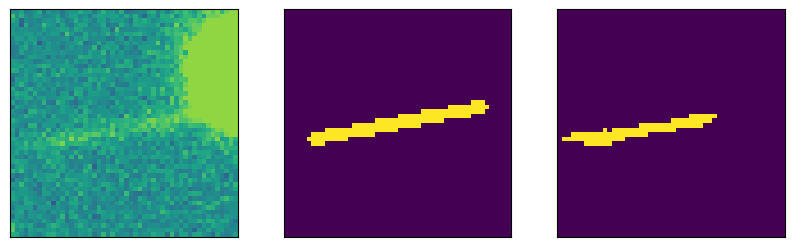

N: 56.0  x: 3889.0  y: 1180.0  mag: 23.55735392758499  trail: 38.0


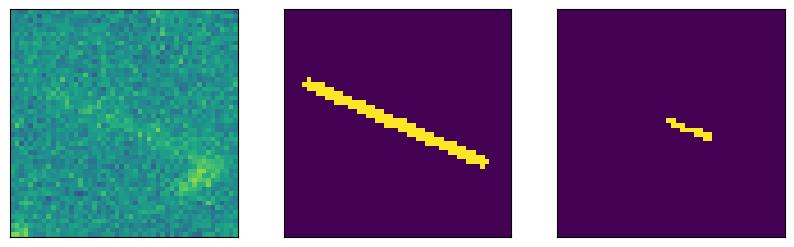

N: 56.0  x: 2205.0  y: 1578.0  mag: 23.997444600446947  trail: 41.0


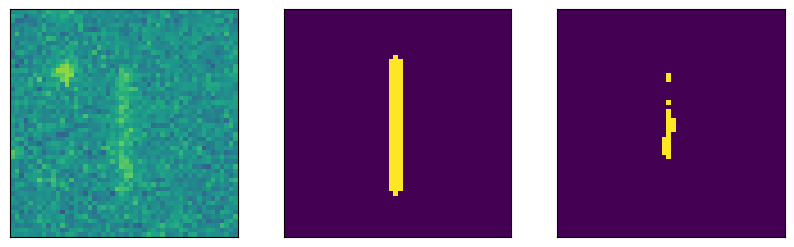

N: 56.0  x: 4086.0  y: 1712.0  mag: 23.73130707717502  trail: 28.0


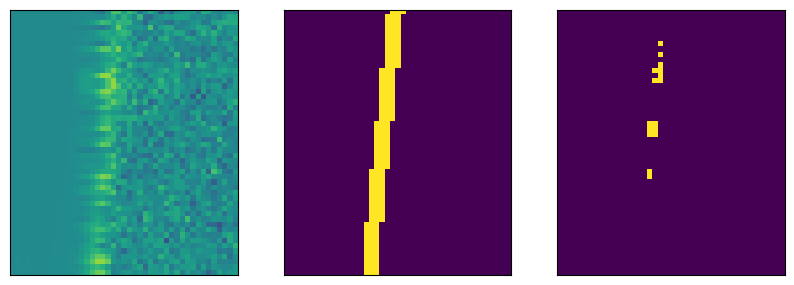

N: 56.0  x: 1205.0  y: 18.0  mag: 23.828097695256407  trail: 59.0


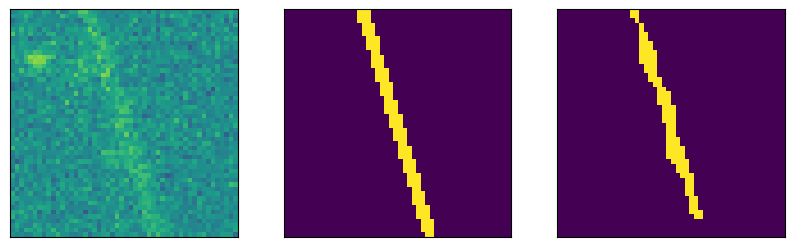

N: 56.0  x: 4073.0  y: 1380.0  mag: 23.73225521327281  trail: 63.0


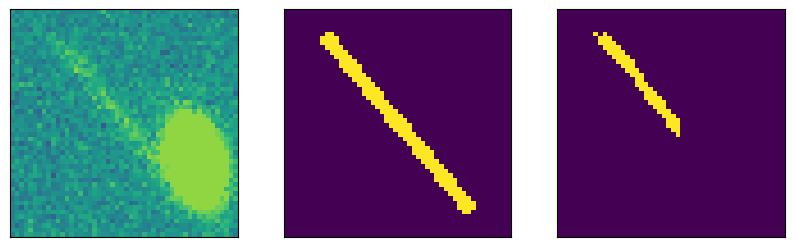

N: 56.0  x: 3052.0  y: 466.0  mag: 23.606332974466834  trail: 48.0


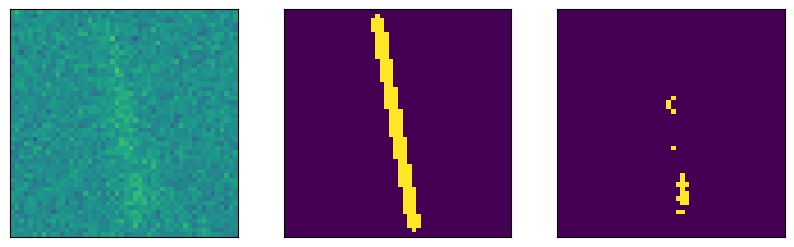

N: 57.0  x: 2073.0  y: 514.0  mag: 23.724632189052866  trail: 46.0


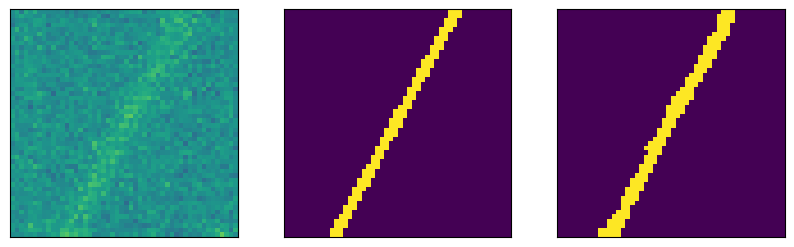

N: 57.0  x: 1885.0  y: 1247.0  mag: 23.514762597138873  trail: 67.0


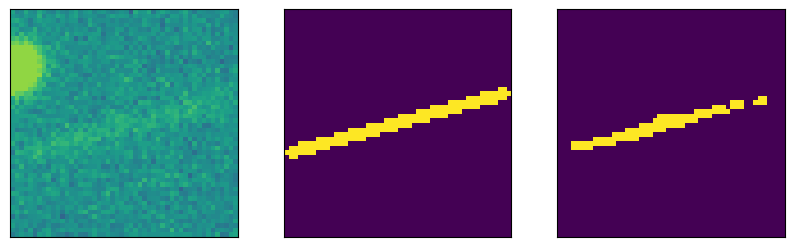

N: 57.0  x: 2215.0  y: 1569.0  mag: 23.641314327964004  trail: 49.0


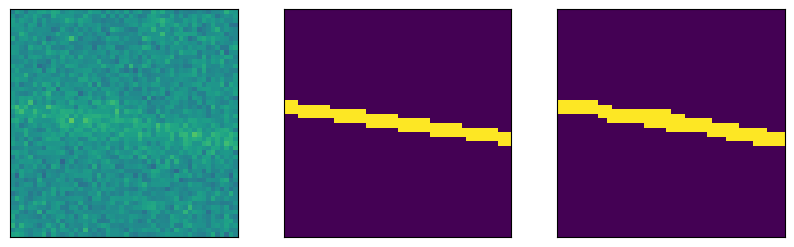

N: 57.0  x: 3409.0  y: 2001.0  mag: 23.902597337530604  trail: 66.0


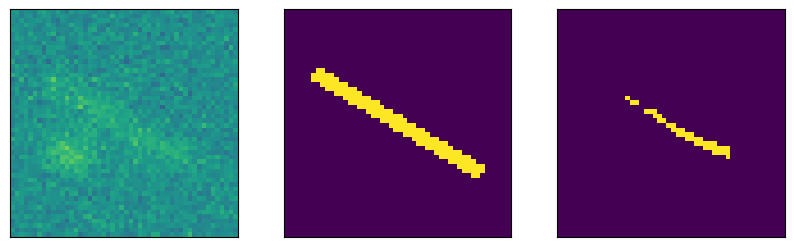

N: 57.0  x: 2585.0  y: 878.0  mag: 23.523817582937905  trail: 41.0


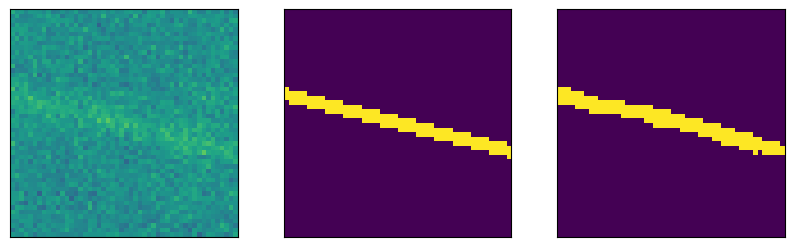

N: 57.0  x: 702.0  y: 50.0  mag: 23.57680400411009  trail: 69.0


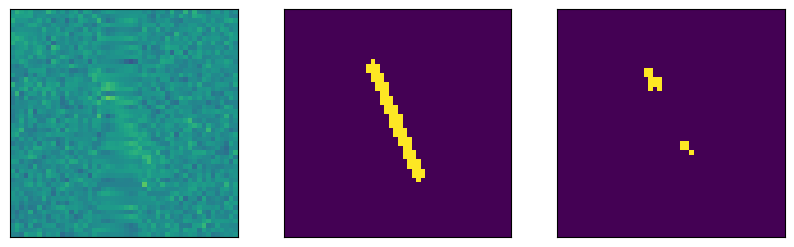

N: 57.0  x: 2751.0  y: 1463.0  mag: 23.81577437554786  trail: 26.0


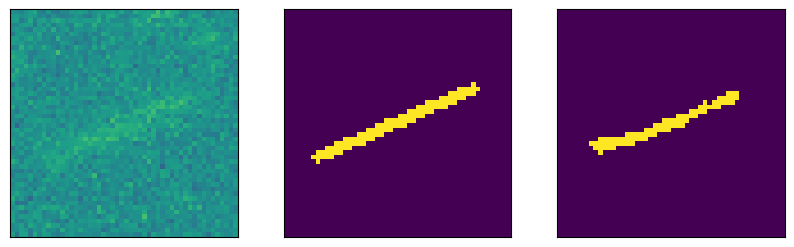

N: 57.0  x: 3552.0  y: 1309.0  mag: 23.589305187003742  trail: 37.0


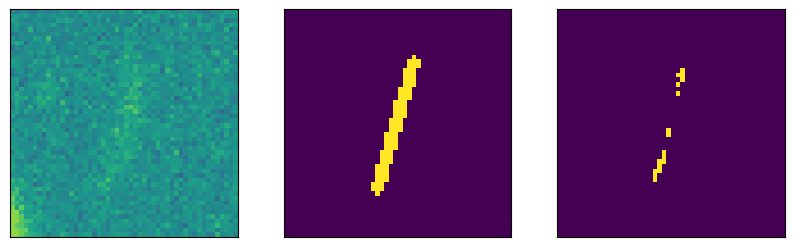

N: 57.0  x: 1390.0  y: 1747.0  mag: 23.750741167969174  trail: 29.0


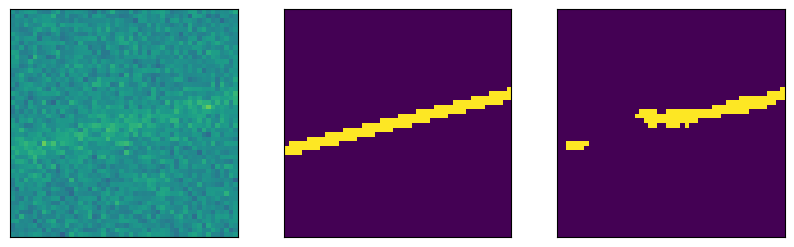

N: 57.0  x: 1150.0  y: 906.0  mag: 23.851135301784296  trail: 70.0


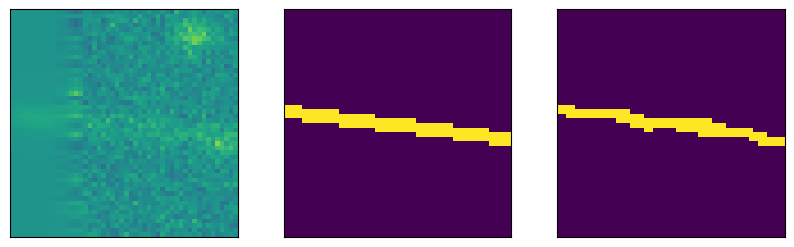

N: 57.0  x: 3566.0  y: 28.0  mag: 23.98404685531277  trail: 51.0


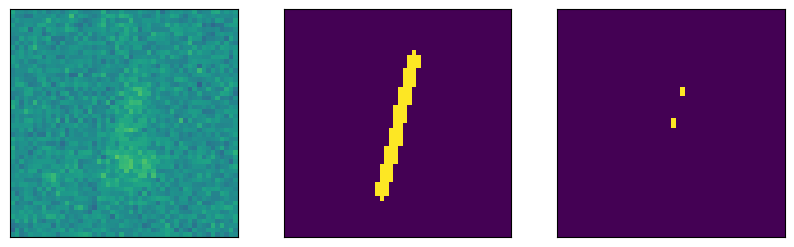

N: 57.0  x: 3044.0  y: 1507.0  mag: 23.86025072243501  trail: 31.0
0


In [85]:
size=25
count = 0
for [n, y_pos, x_pos, detected, trail_len, mag] in true_asteroids_0:
    x_start = max(0, int(x_pos-size))
    x_end = min(x.shape[1], int(x_pos+size))
    y_start = max(0, int(y_pos-size))
    y_end = min(x.shape[2], int(y_pos+size))
    raw         = x[int(n), x_start:x_end, y_start:y_end]
    truths      = y[int(n), x_start:x_end, y_start:y_end]
    predictions = p[int(n), x_start:x_end, y_start:y_end]
    if detected == 1:
        if truths.sum()!=0:
            fig, ax = plt.subplots (1, 3, figsize=(10,10))
            ax[0].imshow(raw, vmin=-150, vmax=150)
            ax[1].imshow(truths)
            ax[2].imshow(predictions)
            for k in ax:
                k.set_xticks([])
                k.set_yticks([])
            plt.show()
            print ("N:",n, " x:", x_pos, " y:", y_pos, " mag:", mag, " trail:", trail_len)
        else:
            count+=1
            print ("N:",n, " x:", x_pos, " y:", y_pos, " mag:", mag, " trail:", trail_len)
print (count)

In [61]:
def NN_comparation_histogram_data1 (model_path, tf_dataset_path, val_index_path, repo, output_coll, 
                                   column_name="trail_length"):
    print ("NN predicting")
    predictions = create_NN_prediction (tf_dataset_path, model_path)
    with open(val_index_path, 'rb') as f:
        val_index = np.load(f)
        val_index.sort()
    print ("Comparing to true catalog")
    cat = compare_NN_predictions (predictions, repo, output_coll, val_index = val_index)
    return cat

In [62]:
catalog_test = NN_comparation_histogram_data1 (model,
                                               tfrecord_path,
                                               val_index_path,
                                               repo_path,
                                               collection,
                                               column_name=["n", "x", "y", "detected", "trail_length", "mag"])


NN predicting
240/240 [==============================] - 13s 54ms/step
Comparing to true catalog


In [67]:
catalog_test[catalog_test["n"]==0]

injection_id          ra       dec  trail_length        beta        mag  \
0            171  150.272432  2.099011             5  120.854705  23.668941   
1            172  150.303614  2.144203            26   70.610273  23.840837   
2            173  150.393477  2.094302            68  153.842533  23.844356   
3            174  150.385364  2.130805            62   73.742795  23.782956   
4            175  150.275832  2.126369            29  150.242595  23.945194   
5            176  150.262383  2.155671            39  125.673853  23.895281   
6            177  150.234002  2.168409            45  160.300640  23.809692   
7            178  150.359121  2.175700            33  129.724542  23.817049   
8            179  150.350372  2.101015            31    6.539896  23.914122   
9            180  150.252367  2.151603            56  178.366120  23.775630   
10           181  150.360628  2.088606            42   65.917557  23.549710   
11           182  150.400510  2.157922            67  170.834281  23.684203   
12           183  150.329965  2.101208            31  115.755335  23.864140   
13           184  150.256314  2.136822            62  114.640787  23.772761   
14           185  150.249114  2.155134             5    1.038495  23.529672   
15           186  150.328653  2.132455            64  101.346374  23.714527   
16           187  150.315066  2.158367            63  120.571592  23.729296   
17           188  150.327520  2.087511            38   99.390747  23.573825   
18           189  150.374399  2.107867            41  176.805345  23.962171   
19           190  150.257665  2.162387            43   63.196610  23.570461   
20          2466  150.208582  2.182521            33    5.914842  23.744446   

    n     x     y  detected  
0   0  1700  2748         0  
1   0   736  2083         0  
2   0  1808   161         1  
3   0  1026   336         0  
4   0  1116  2676         0  
5   0   489  2962         1  
6   0   217  3567         1  
7   0    65   898         0  
8   0  1661  1084         0  
9   0   576  3176         1  
10  0  1927   864         0  
11  0   447    11         1  
12  0  1656  1520         0  
13  0   892  3092         1  
14  0   500  3245         0  
15  0   988  1548         1  
16  0   434  1839         1  
17  0  1949  1572         1  
18  0  1516   570         0  
19  0   346  3063         1  
20  0   -85  4109         0

In [23]:
for [n, x_pos, y_pos] in NN_detected_asteroids_0:
    print (y_pos)

3771
885
1737
2769
917
2373
2669
2534
1681
41
2336
239
4153
2244
2633
1150
4092
3878
2034
730
3489
15
2181
3337
3288
907
2427
3661
2052
2382
1036
457
3414
4058
2734
434
1170
533
404
3887
674
3530
2360
3022
2607
1339
204
3518
86
1038
3885
1470
659
50
3175
3387
4078
3323
4020
1557
3757
1784
2768
1425
1974
2883
973
1422
2734
2248
2051
3422
1085
1777
1520
998
3599
3702
2159
337
1579
3617
1413
3579
2083
2904
908
276
3114
3318
2854
4129
47
1734
1243
3852
2183
1946
3139
3101
2803
949
1950
887
555
2675
2699
2662
3434
556
851
1937
1690
721
4021
2815
697
3307
2265
1625
460
395
2404
1360
1759
2687
1519
3358
259
1149
3096
3103
1516
1767
2350
2854
3021
2334
3016
1101
896
467
3460
3507
3380
628
3652
4124
3549
2094
2010
2133
860
3658
2107
2766
2810
3797
32
1257
1052
3041
2065
3481
4161
800
2302
168
2801
2863
953
3261
3919
109
2939
268
519
873
3075
2935
143
2911
135
2195
3864
3933
104
1618
2637
2806
2583
691
2791
2929
3028
1179
3937
1320
2902
1459
1443
3992
1418
1089
3491
2340
3557
1347
612
230
698
14